In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Literal, Optional

import numpy as np
import pandas as pd

# class for filling in for frames where ball is not detected
@dataclass(frozen=True)
class BallImputationReport:
    """Summary of the ball imputation step."""
    n_rows: int
    n_frames: int
    n_not_detected_frames: int
    n_filled_frames: int
    method: str
    max_gap_filled: Optional[int]


def impute_ball_when_not_detected(
    df: pd.DataFrame,
    *,
    frame_col: str = "frame",
    period_col: str = "period",
    ball_x_col: str = "ball_x",
    ball_y_col: str = "ball_y",
    ball_z_col: str = "ball_z",
    detected_col: str = "is_detected_ball",
    method: Literal["locf", "interpolate"] = "interpolate",
    max_gap_frames: Optional[int] = 25,
) -> tuple[pd.DataFrame, BallImputationReport]:
    """
    Fill ball position in frames where the ball is not detected.

    Requirements:
        - df contains ball_x, ball_y, is_detected_ball, frame, and ideally period.
        - df is "long" player-tracking format (multiple rows per frame). This function
          imputes ball values per frame and writes them back to all player rows.

    Parameters:
        method:
            - "locf": forward fill (last observed ball position).
            - "interpolate": linear interpolation between known detections (then optional ffill/bfill edges).
        max_gap_frames:
            Maximum consecutive missing frames to fill. If None, fill all gaps.

    Returns:
        (df_out, report)
    """
    required = {frame_col, ball_x_col, ball_y_col, detected_col}
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {sorted(missing)}")

    df_out = df.copy()

    # ---- Build a per-frame table (one row per frame) ----
    group_cols = [frame_col]
    if period_col in df_out.columns:
        group_cols = [period_col, frame_col]

    frame_ball = (
        df_out.groupby(group_cols, as_index=False)
        .agg(
            {
                ball_x_col: "first",
                ball_y_col: "first",
                detected_col: "first",
                **({ball_z_col: "first"} if ball_z_col in df_out.columns else {}),
            }
        )
        .sort_values(group_cols)
        .reset_index(drop=True)
    )

    # Mark missing ball frames
    not_detected = ~frame_ball[detected_col].astype(bool)
    n_not_detected_frames = int(not_detected.sum())

    # Replace "not detected" frames with NaN so we can fill them
    frame_ball.loc[not_detected, [ball_x_col, ball_y_col]] = np.nan
    if ball_z_col in frame_ball.columns:
        frame_ball.loc[not_detected, [ball_z_col]] = np.nan

    # ---- Fill strategy ----
    if method == "locf":
        frame_ball[[ball_x_col, ball_y_col]] = frame_ball[[ball_x_col, ball_y_col]].ffill()
        if ball_z_col in frame_ball.columns:
            frame_ball[[ball_z_col]] = frame_ball[[ball_z_col]].ffill()

    elif method == "interpolate":
        # Interpolate within each period if available
        if period_col in frame_ball.columns:
            frame_ball[[ball_x_col, ball_y_col]] = (
                frame_ball.groupby(period_col)[[ball_x_col, ball_y_col]]
                .apply(lambda g: g.interpolate(method="linear", limit=max_gap_frames, limit_direction="both"))
                .reset_index(level=0, drop=True)
            )
            if ball_z_col in frame_ball.columns:
                frame_ball[[ball_z_col]] = (
                    frame_ball.groupby(period_col)[[ball_z_col]]
                    .apply(lambda g: g.interpolate(method="linear", limit=max_gap_frames, limit_direction="both"))
                    .reset_index(level=0, drop=True)
                )
        else:
            frame_ball[[ball_x_col, ball_y_col]] = frame_ball[[ball_x_col, ball_y_col]].interpolate(
                method="linear",
                limit=max_gap_frames,
                limit_direction="both",
            )
            if ball_z_col in frame_ball.columns:
                frame_ball[[ball_z_col]] = frame_ball[[ball_z_col]].interpolate(
                    method="linear",
                    limit=max_gap_frames,
                    limit_direction="both",
                )

        # If there are missing values at the very start/end (no bracketing detections),
        # ffill/bfill can be a pragmatic assumption:
        frame_ball[[ball_x_col, ball_y_col]] = frame_ball[[ball_x_col, ball_y_col]].ffill().bfill()
        if ball_z_col in frame_ball.columns:
            frame_ball[[ball_z_col]] = frame_ball[[ball_z_col]].ffill().bfill()
    else:
        raise ValueError("method must be one of: 'locf', 'interpolate'")

    # ---- Optional: enforce max gap fill by re-nulling large gaps (if requested) ----
    # If max_gap_frames is set, interpolation already respects it. LOCF does not,
    # so we can optionally block filling for long missing runs.
    max_gap_used = max_gap_frames if max_gap_frames is not None else None

    # Create an "imputed" flag: ball value was originally not detected but now is filled
    imputed_flag = not_detected & frame_ball[ball_x_col].notna() & frame_ball[ball_y_col].notna()
    frame_ball["ball_imputed"] = imputed_flag

    # ---- Merge back to the long tracking dataframe ----
    merge_cols = group_cols
    fill_cols = [ball_x_col, ball_y_col]
    if ball_z_col in frame_ball.columns:
        fill_cols.append(ball_z_col)

    df_out = df_out.drop(columns=fill_cols, errors="ignore").merge(
        frame_ball[merge_cols + fill_cols + ["ball_imputed"]],
        on=merge_cols,
        how="left",
        validate="many_to_one",
    )

    report = BallImputationReport(
        n_rows=int(len(df_out)),
        n_frames=int(frame_ball.shape[0]),
        n_not_detected_frames=int(n_not_detected_frames),
        n_filled_frames=int(frame_ball["ball_imputed"].sum()),
        method=str(method),
        max_gap_filled=max_gap_used,
    )

    return df_out, report


In [2]:
from __future__ import annotations
import json
from pathlib import Path
import numpy as np
import pandas as pd
import sys
from pathlib import Path

def time_to_seconds(time_str: str | None, default_seconds: int = 90 * 60) -> int:
    """
    Convert a SkillCorner time string ("HH:MM:SS") to total seconds.

    Requirements:
        - `time_str` must be either None or a string formatted as "HH:MM:SS".

    Parameters:
        time_str:
            Time string from SkillCorner metadata, e.g. "00:45:12". If None, returns `default_seconds`.
        default_seconds:
            Value to return when `time_str` is None (commonly used as a fallback for missing end_time).

    Returns:
        Total time in seconds as an integer.
    """
    if time_str is None:
        return int(default_seconds)

    h, m, s = map(int, time_str.split(":"))
    return int(h * 3600 + m * 60 + s)

# ------------------------------------------------------------
# Current working directory (use this as a base for saving files if you want)
PROJECT_ROOT: Path = Path.cwd()

# Match configuration
MATCH_ID: int = 1899585
MATCH_DIR: Path = PROJECT_ROOT / "data" / "matches" / str(MATCH_ID)

TRACKING_PATH: Path = MATCH_DIR / f"{MATCH_ID}_tracking_extrapolated.jsonl"
MATCH_META_PATH: Path = MATCH_DIR / f"{MATCH_ID}_match.json"

#print("Tracking path:", TRACKING_PATH)
#print("Match meta path:", MATCH_META_PATH)

if not TRACKING_PATH.exists():
    raise FileNotFoundError(f"Tracking file not found: {TRACKING_PATH}")
if not MATCH_META_PATH.exists():
    raise FileNotFoundError(f"Match meta file not found: {MATCH_META_PATH}")


# ------------------------------------------------------------
# 1) Load tracking data -> tracking_df
# ------------------------------------------------------------
raw_data = pd.read_json(TRACKING_PATH, lines=True)

tracking_df = pd.json_normalize(
    raw_data.to_dict("records"),
    record_path="player_data",
    meta=["frame", "timestamp", "period", "possession", "ball_data"],
)

# Extract possession fields safely
tracking_df["possession_player_id"] = tracking_df["possession"].apply(lambda x: x.get("player_id"))
tracking_df["possession_group"] = tracking_df["possession"].apply(lambda x: x.get("group"))

# Expand ball_data (optional but commonly useful)
ball_df = pd.json_normalize(tracking_df["ball_data"])
ball_df = ball_df.rename(
    columns={"x": "ball_x", "y": "ball_y", "z": "ball_z", "is_detected": "is_detected_ball"}
)

# If columns already match expected names in your file, this will still work
# (it will just keep those column names if present).
for col in ["ball_x", "ball_y", "ball_z", "is_detected_ball"]:
    if col not in ball_df.columns and col in tracking_df.columns:
        # In case json_normalize already yielded same naming
        pass

tracking_df = pd.concat([tracking_df.drop(columns=["ball_data"]), ball_df], axis=1)

# Drop the nested possession dict now that we extracted fields
tracking_df = tracking_df.drop(columns=["possession"])

# Add match id
tracking_df["match_id"] = MATCH_ID

display(tracking_df.head())


# ------------------------------------------------------------
# 2) Load match metadata -> players_df
# ------------------------------------------------------------
with MATCH_META_PATH.open("r", encoding="utf-8") as f:
    match_meta = json.load(f)

match_meta_df = pd.json_normalize(match_meta, max_level=2)
match_meta_df["home_team_side"] = match_meta_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    match_meta_df.to_dict("records"),
    record_path="players",
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],
)

# Keep only players who played
players_df = players_df[~((players_df["start_time"].isna()) & (players_df["end_time"].isna()))].copy()

# Total time played
players_df["total_time"] = (
    players_df["end_time"].apply(time_to_seconds) - players_df["start_time"].apply(time_to_seconds)
)

# Goalkeeper flag
players_df["is_gk"] = players_df["player_role.acronym"].eq("GK")

# Match name
players_df["match_name"] = players_df["home_team.name"] + " vs " + players_df["away_team.name"]

# Home/Away label
players_df["home_away_player"] = np.where(
    players_df["team_id"].eq(players_df["home_team.id"]),
    "Home",
    "Away",
)

# Team name
players_df["team_name"] = np.where(
    players_df["team_id"].eq(players_df["home_team.id"]),
    players_df["home_team.name"],
    players_df["away_team.name"],
)

# Split home team direction by half
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)

# Player direction depends on whether they are home or away
players_df["direction_player_1st_half"] = np.where(
    players_df["home_away_player"].eq("Home"),
    players_df["home_team_side_1st_half"],
    players_df["home_team_side_2nd_half"],
)
players_df["direction_player_2nd_half"] = np.where(
    players_df["home_away_player"].eq("Home"),
    players_df["home_team_side_2nd_half"],
    players_df["home_team_side_1st_half"],
)

# Keep only the columns we want
columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep].copy()

display(players_df.head())


# ------------------------------------------------------------
# 3) Merge -> enriched_tracking_data
# ------------------------------------------------------------
enriched_tracking_data = tracking_df.merge(
    players_df,
    left_on="player_id",
    right_on="id",
    how="left",
    validate="many_to_one",  # best practice: each player_id maps to max 1 row in players_df
)
enriched_tracking_data, report = impute_ball_when_not_detected(
    enriched_tracking_data,
    method="interpolate",
    max_gap_frames=25,
)

display(enriched_tracking_data.head())
print("Rows:", len(enriched_tracking_data), "| Cols:", enriched_tracking_data.shape[1])

# ------------------------------------------------------------
# Add Dynamic Events Aggregator to Python path
# ------------------------------------------------------------
AGGREGATOR_DIR = (
    PROJECT_ROOT
    / "resources"
    / "Tutorials"
    / "[Advanced] Aggregating Dynamic Events"
)

sys.path.append(str(AGGREGATOR_DIR))

from DynamicEventsAggregator import DynamicEventAggregator

# ------------------------------------------------------------
# 4) Example: save outputs in the working directory
# ------------------------------------------------------------
output_path = PROJECT_ROOT / f"{MATCH_ID}_enriched_tracking.parquet"
#enriched_tracking_data.to_parquet(output_path, index=False)
#print("Saved:", output_path)


,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.61,0.71,34718,False,10,2026-01-06,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
1,-18.99,10.85,698137,True,10,2026-01-06,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
2,-17.05,-11.54,799092,True,10,2026-01-06,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
3,-20.05,1.28,42510,True,10,2026-01-06,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
4,-1.41,-30.06,51017,True,10,2026-01-06,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585


,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,01:34:37,None,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,957734,C. Piper,3,867,Wellington Phoenix FC,Full Back,-277,Left Wing Back,LWB,False,left_to_right,right_to_left
1,00:00:00,01:19:45,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,27003,K. Nagasawa,25,867,Wellington Phoenix FC,Center Forward,4785,Center Forward,CF,False,left_to_right,right_to_left
2,00:00:00,00:21:41,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,14736,L. Verstraete,6,4177,Auckland FC,Midfield,1301,Right Midfield,RM,False,right_to_left,left_to_right
3,01:00:10,None,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,6799,M. Rojas,21,867,Wellington Phoenix FC,Center Forward,1790,Center Forward,CF,False,left_to_right,right_to_left
4,00:58:04,None,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,965684,L. Toomey,8,4177,Auckland FC,Wide Attacker,1916,Left Winger,LW,False,right_to_left,left_to_right


,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,is_detected_ball,...,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half,ball_x,ball_y,ball_z,ball_imputed
0,-39.61,0.71,34718,False,10,2026-01-06,1.0,23909.0,away team,True,...,5400,Goalkeeper,GK,True,left_to_right,right_to_left,0.73,-0.93,0.26,False
1,-18.99,10.85,698137,True,10,2026-01-06,1.0,23909.0,away team,True,...,5400,Center Back,CB,False,left_to_right,right_to_left,0.73,-0.93,0.26,False
2,-17.05,-11.54,799092,True,10,2026-01-06,1.0,23909.0,away team,True,...,5400,Right Center Back,RCB,False,left_to_right,right_to_left,0.73,-0.93,0.26,False
3,-20.05,1.28,42510,True,10,2026-01-06,1.0,23909.0,away team,True,...,5400,Left Center Back,LCB,False,left_to_right,right_to_left,0.73,-0.93,0.26,False
4,-1.41,-30.06,51017,True,10,2026-01-06,1.0,23909.0,away team,True,...,3610,Right Wing Back,RWB,False,left_to_right,right_to_left,0.73,-0.93,0.26,False


Rows: 894982 | Cols: 33


In [29]:
report

BallImputationReport(n_rows=894982, n_frames=40681, n_not_detected_frames=8855, n_filled_frames=8855, method='interpolate', max_gap_filled=25)

In [4]:
enriched_tracking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894982 entries, 0 to 894981
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   x                           894982 non-null  float64       
 1   y                           894982 non-null  float64       
 2   player_id                   894982 non-null  int64         
 3   is_detected                 894982 non-null  bool          
 4   frame                       894982 non-null  object        
 5   timestamp                   894982 non-null  datetime64[ns]
 6   period                      894982 non-null  object        
 7   possession_player_id        197076 non-null  float64       
 8   possession_group            634656 non-null  object        
 9   is_detected_ball            894982 non-null  bool          
 10  match_id                    894982 non-null  int64         
 11  start_time                  894982 non-

In [3]:
ball_df.is_detected_ball.unique() # checking if ball is detected

array([ True, False])

In [5]:
enriched_tracking_data.possession_group.unique()

array(['away team', 'home team', None], dtype=object)

In [7]:
match_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 63 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         1 non-null      int64  
 1   home_team_score                            1 non-null      int64  
 2   away_team_score                            1 non-null      int64  
 3   date_time                                  1 non-null      object 
 4   home_team_coach                            0 non-null      object 
 5   away_team_coach                            0 non-null      object 
 6   match_periods                              1 non-null      object 
 7   referees                                   1 non-null      object 
 8   players                                    1 non-null      object 
 9   status                                     1 non-null      object 
 10  home_team_side                

In [8]:
HOME_TEAM_ID: int = int(match_meta_df.loc[0, "home_team.id"])
AWAY_TEAM_ID: int = int(match_meta_df.loc[0, "away_team.id"])

# Global team color mapping (adjust colors as you like)
TEAM_COLORS: dict[int, str] = {
    HOME_TEAM_ID: "blue",
    AWAY_TEAM_ID: "red",
}

# Goalkeeper color (used in plotting)
GK_COLOR: str = "green"

print("Home team ID:", HOME_TEAM_ID)
print("Away team ID:", AWAY_TEAM_ID)

Home team ID: 4177
Away team ID: 867


In [9]:
# Sanity checks
print("Rows:", len(enriched_tracking_data))
print("Unique frames:", enriched_tracking_data["frame"].nunique())
print("Unique players:", enriched_tracking_data["player_id"].nunique())
enriched_tracking_data["is_gk"].value_counts()

Rows: 894982
Unique frames: 40681
Unique players: 30


is_gk
False    813620
True      81362
Name: count, dtype: int64

In [10]:
# Basic coordinate sanity check ---
print("x range:", enriched_tracking_data["x"].min(), "to", enriched_tracking_data["x"].max()) 
print("y range:", enriched_tracking_data["y"].min(), "to", enriched_tracking_data["y"].max())

print("ball_x range:", enriched_tracking_data["ball_x"].min(), "to", enriched_tracking_data["ball_x"].max())
print("ball_y range:", enriched_tracking_data["ball_y"].min(), "to", enriched_tracking_data["ball_y"].max())

x range: -57.6 to 56.03
y range: -38.0 to 37.5
ball_x range: -57.5 to 56.86
ball_y range: -37.64 to 36.18


In [12]:
# Pitch constants (SkillCorner)
PITCH_LENGTH: float = 105.0
PITCH_WIDTH: float = 68.0

In [13]:
import pandas as pd

# --- Load dynamic events file ---
de_path = f"data/matches/{MATCH_ID}/{MATCH_ID}_dynamic_events.csv"
de = pd.read_csv(de_path)

# --- Quick look ---
print("Rows:", len(de))
print("Columns:", de.columns.tolist())
de = de.sort_values("index").reset_index(drop=True)
de.head()

Rows: 4713
Columns: ['event_id', 'index', 'match_id', 'frame_start', 'frame_end', 'frame_physical_start', 'time_start', 'time_end', 'minute_start', 'second_start', 'duration', 'period', 'attacking_side_id', 'attacking_side', 'event_type_id', 'event_type', 'event_subtype_id', 'event_subtype', 'player_id', 'player_name', 'player_position_id', 'player_position', 'player_in_possession_id', 'player_in_possession_name', 'player_in_possession_position_id', 'player_in_possession_position', 'team_id', 'team_shortname', 'x_start', 'y_start', 'channel_id_start', 'channel_start', 'third_id_start', 'third_start', 'penalty_area_start', 'x_end', 'y_end', 'channel_id_end', 'channel_end', 'third_id_end', 'third_end', 'penalty_area_end', 'associated_player_possession_event_id', 'associated_player_possession_frame_start', 'associated_player_possession_frame_end', 'associated_player_possession_end_type_id', 'associated_player_possession_end_type', 'associated_off_ball_run_event_id', 'associated_off_ball_r

C:\Users\henri\AppData\Local\Temp\ipykernel_22956\4032140451.py:5: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de = pd.read_csv(de_path)


,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated
0,8_0,0,1899585,12,12,NaN,00:00.2,00:00.2,0,0,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
1,8_1,1,1899585,31,44,NaN,00:02.1,00:03.4,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False
2,7_0,2,1899585,31,32,NaN,00:02.1,00:02.2,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
3,7_1,3,1899585,31,44,NaN,00:02.1,00:03.4,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
4,9_0,4,1899585,37,44,17.0,00:00.7,00:03.4,0,0,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,NaN


In [14]:
from __future__ import annotations

from typing import List
import pandas as pd
def match_context(match_meta_df: pd.DataFrame) -> dict[str, str | int]:
    """
    Extract basic match context (teams and score) from SkillCorner match metadata.

    Requirements:
        - match_meta_df must be a DataFrame created via pd.json_normalize(match_meta, max_level=2)
        - must contain exactly one row
        - required cols: home_team.name, away_team.name, home_team_score, away_team_score
    """
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row (one match).")

    required = {"home_team.name", "away_team.name", "home_team_score", "away_team_score"}
    missing = required.difference(match_meta_df.columns)
    if missing:
        raise KeyError(f"Missing required columns in match_meta_df: {sorted(missing)}")

    row = match_meta_df.iloc[0]

    home_team = str(row["home_team.name"])
    away_team = str(row["away_team.name"])
    home_score = int(row["home_team_score"])
    away_score = int(row["away_team_score"])

    return {
        "home_team": home_team,
        "away_team": away_team,
        "home_score": home_score,
        "away_score": away_score,
        "scoreline": f"{home_score}–{away_score}",
        "match_label": f"{home_team} {home_score}–{away_score} {away_team}",
    }

#normalize direction of play. I want home team to play left to right in both halfs.
def get_home_team_sides(match_meta_df: pd.DataFrame) -> tuple[str, str]:
    """
    Returns (home_dir_p1, home_dir_p2) as 'left_to_right' / 'right_to_left'
    from match metadata.
    """
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    if "home_team_side" not in match_meta_df.columns:
        raise KeyError("match_meta_df must contain 'home_team_side'.")

    raw = str(match_meta_df.loc[0, "home_team_side"])  # e.g. "['right_to_left', 'left_to_right']"
    cleaned = raw.strip("[]").replace("'", "")
    parts = [p.strip() for p in cleaned.split(",") if p.strip()]
    if len(parts) < 2:
        raise ValueError(f"Could not parse home_team_side into two halves: {raw}")
    return parts[0], parts[1]
def normalize_tracking_direction(
    tracking_df: pd.DataFrame,
    *,
    home_team_id: int,
    flip_y: bool = True,
) -> pd.DataFrame:
    """
    Normalize tracking so HOME always attacks left->right for the full match.

    Strategy:
      - Build a frame-level flip mask using HOME rows only (direction flags)
      - Flip ALL rows (both teams) in those frames to preserve geometry
      - Flip ball in the same frames
    """
    df = tracking_df.copy()

    required: Set[str] = {
        "frame", "period", "team_id",
        "x", "y", "ball_x", "ball_y",
        "direction_player_1st_half", "direction_player_2nd_half",
    }
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required tracking columns: {sorted(missing)}")

    home = df.loc[
        df["team_id"].eq(home_team_id),
        ["frame", "period", "direction_player_1st_half", "direction_player_2nd_half"]
    ].copy()

    if home.empty:
        raise ValueError("No home-team rows found (check home_team_id vs team_id).")

    def needs_flip(period: float, d1: str, d2: str) -> bool:
        p = int(period)
        if p == 1:
            return str(d1) == "right_to_left"
        if p == 2:
            return str(d2) == "right_to_left"
        return False

    home["needs_flip"] = home.apply(
        lambda r: needs_flip(r["period"], r["direction_player_1st_half"], r["direction_player_2nd_half"]),
        axis=1,
    )
    flip_by_frame = home.groupby("frame")["needs_flip"].any()
    flip_mask = df["frame"].map(flip_by_frame).fillna(False)

    df.loc[flip_mask, "x"] = -df.loc[flip_mask, "x"]
    df.loc[flip_mask, "ball_x"] = -df.loc[flip_mask, "ball_x"]

    if flip_y:
        df.loc[flip_mask, "y"] = -df.loc[flip_mask, "y"]
        df.loc[flip_mask, "ball_y"] = -df.loc[flip_mask, "ball_y"]

    return df

def normalize_dynamic_events_to_home_ltr(
    de: pd.DataFrame,
    *,
    home_dir_p1: str,
    home_dir_p2: str,
    flip_y: bool = True,
) -> pd.DataFrame:
    """
    Normalize Dynamic Events coordinates into the SAME coordinate system as `enriched_tracking_norm`
    (HOME always left->right).

    Steps:
      A) Convert DE coordinates from "possession-LTR" to "pitch" using attacking_side:
         - if attacking_side == 'right_to_left' -> un-mirror: x,y *= -1
      B) Apply match-level flip (same as tracking normalization) based on home_dir per period:
         - if home_dir in that period was right_to_left -> flip entire period: x,y *= -1
    """
    df = de.copy()

    if "period" not in df.columns:
        raise KeyError("Dynamic events df must contain 'period'.")
    if "attacking_side" not in df.columns:
        raise KeyError("Dynamic events df must contain 'attacking_side' (needed to un-mirror).")

    # --- coordinate columns to flip ---
    x_cols: List[str] = [
        c for c in df.columns
        if c in {"x_start", "x_end", "x"} or c.endswith("_x_start") or c.endswith("_x_end") or c.endswith("_x_reception")
    ]
    y_cols: List[str] = [
        c for c in df.columns
        if c in {"y_start", "y_end", "y"} or c.endswith("_y_start") or c.endswith("_y_end") or c.endswith("_y_reception")
    ]
    x_cols = [c for c in x_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    y_cols = [c for c in y_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    # A) Un-mirror using attacking_side (because DE coords are delivered as if possession attacks LTR)
    unmirror_mask = df["attacking_side"].astype(str).eq("right_to_left")
    if x_cols:
        df.loc[unmirror_mask, x_cols] = -df.loc[unmirror_mask, x_cols]
    if flip_y and y_cols:
        df.loc[unmirror_mask, y_cols] = -df.loc[unmirror_mask, y_cols]

    # B) Match-level flip to enforce "HOME always LTR" across halves
    flip_p1 = (home_dir_p1 == "right_to_left")
    flip_p2 = (home_dir_p2 == "right_to_left")
    match_flip_mask = (df["period"].eq(1) & flip_p1) | (df["period"].eq(2) & flip_p2)

    if x_cols:
        df.loc[match_flip_mask, x_cols] = -df.loc[match_flip_mask, x_cols]
    if flip_y and y_cols:
        df.loc[match_flip_mask, y_cols] = -df.loc[match_flip_mask, y_cols]

    return df


home_dir_p1, home_dir_p2 = get_home_team_sides(match_meta_df)

enriched_tracking_norm = normalize_tracking_direction(
    enriched_tracking_data,
    home_team_id=HOME_TEAM_ID,
    flip_y=True,
)

de_norm = normalize_dynamic_events_to_home_ltr(
    de,
    home_dir_p1=home_dir_p1,
    home_dir_p2=home_dir_p2,
    flip_y=True,
)


In [15]:
# --- Event types and subtypes ---
de_norm["event_type"].value_counts()

event_type
passing_option        2387
player_possession      929
on_ball_engagement     929
off_ball_run           468
Name: count, dtype: int64

In [16]:
de_norm["event_subtype"].value_counts()

event_subtype
pressure                 269
other                    226
recovery_press           195
pressing                 140
run_ahead_of_the_ball    125
counter_press             99
support                   89
coming_short              54
dropping_off              47
cross_receiver            46
behind                    31
pulling_wide              30
overlap                   24
underlap                  12
pulling_half_space        10
Name: count, dtype: int64

In [17]:
#identify all goals in match
goals_by_interrupt = de_norm[
    (de_norm["event_type"] == "player_possession") &
    (de_norm["game_interruption_after"].isin(["goal_for", "goal_against"]))
].sort_values(["index"])

goals_by_interrupt[["index","event_id","team_shortname","game_interruption_after","frame_start","frame_end","time_start","time_end","end_type"]].head(10)

,index,event_id,team_shortname,game_interruption_after,frame_start,frame_end,time_start,time_end,end_type
1462,1462,8_302,Auckland FC,goal_for,18150,18164,30:14.0,30:15.4,pass
3532,3532,8_690,Auckland FC,goal_for,44380,44380,69:21.0,69:21.0,shot
4037,4037,8_797,Wellington P FC,goal_for,51899,51899,81:52.9,81:52.9,shot


In [18]:
from typing import Iterable
import numpy as np
import pandas as pd
from __future__ import annotations
from typing import Iterable



def _require_columns(df: pd.DataFrame, required: Iterable[str]) -> None:
    """Validate that required columns exist in the DataFrame."""
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")


def get_all_goal_events(de_norm: pd.DataFrame) -> pd.DataFrame:
    """
    Return ALL goal events (sorted) from normalized dynamic events.

    A "goal event" is a player_possession with game_interruption_after in ['goal_for','goal_against'].
    """
    _require_columns(de_norm, ["event_type", "game_interruption_after", "frame_start", "index", "event_id"])

    goals = de_norm.loc[
        (de_norm["event_type"] == "player_possession")
        & (de_norm["game_interruption_after"].isin(["goal_for", "goal_against"]))
    ].copy()

    if goals.empty:
        raise ValueError("No goal events found (game_interruption_after in ['goal_for','goal_against']).")

    goals = goals.sort_values(["frame_start", "index"], ascending=True).reset_index(drop=True)
    return goals


def find_last_completed_pass_before_frame(
    de_norm: pd.DataFrame,
    cutoff_frame: int,
    *,
    pass_event_types: tuple[str, ...] = ("player_possession",),
) -> pd.Series:
    """
    Find the last completed pass event before a given cutoff frame in normalized dynamic events.
    """
    _require_columns(de_norm, ["event_type", "frame_start", "frame_end", "index"])

    candidates = de_norm.loc[
        (de_norm["event_type"].isin(pass_event_types))
        & (de_norm["frame_end"] < int(cutoff_frame))
    ].copy()

    if "end_type" in candidates.columns:
        candidates = candidates.loc[candidates["end_type"] == "pass"]

    if candidates.empty:
        raise ValueError("No pass candidates found before cutoff_frame with the given filters.")

    if "pass_outcome" in candidates.columns:
        candidates = candidates.loc[candidates["pass_outcome"] == "successful"]

    if candidates.empty:
        raise ValueError("No completed pass found before cutoff_frame (pass_outcome filtering removed all rows).")

    candidates = candidates.sort_values(["frame_end", "index"], ascending=True)
    return candidates.iloc[-1]


def _get_pass_moment_frame_from_passing_option(
    de_norm: pd.DataFrame,
    player_possession_row: pd.Series,
) -> int:
    """
    Infer the 'true' pass frame for a player_possession ending with a pass.
    """
    fallback_frame = int(player_possession_row["frame_end"])

    po_id = player_possession_row.get("targeted_passing_option_event_id", None)
    if pd.isna(po_id) or po_id is None:
        return fallback_frame

    po_rows = de_norm.loc[
        (de_norm["event_type"] == "passing_option") & (de_norm["event_id"] == po_id)
    ]
    if po_rows.empty:
        return fallback_frame

    po = po_rows.iloc[0]
    if "peak_passing_option_frame" in po.index and pd.notna(po["peak_passing_option_frame"]):
        return int(po["peak_passing_option_frame"])

    return fallback_frame


def _extract_pass_coordinates(row: pd.Series) -> dict[str, float]:
    """
    Extract pass start/end coordinates from the pass event row (already normalized).
    """
    def _get_float(*cols: str) -> float:
        for col in cols:
            if col in row.index and pd.notna(row[col]):
                return float(row[col])
        return float("nan")

    return {
        "pass_x_start": _get_float("player_in_possession_x_end", "x_end"),
        "pass_y_start": _get_float("player_in_possession_y_end", "y_end"),
        "pass_x_end": _get_float("player_targeted_x_reception"),
        "pass_y_end": _get_float("player_targeted_y_reception"),
    }


def get_last_completed_pass_before_all_goals(de_norm: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame with one row per goal:
      - the last completed pass before that goal
      - pass_moment_frame
      - pass start/end coordinates

    Output columns include the same pass columns as before, plus some goal context
    (goal_event_id, goal_frame_start, goal_index, goal_team_shortname if available).
    """
    goals = get_all_goal_events(de_norm)

    pass_cols = [
        "event_id",
        "event_type",
        "index",
        "player_id",
        "frame_start",
        "frame_end",
        "passing_option_at_pass_moment",
        "player_targeted_xpass_completion",
        "n_simultaneous_passing_options",
        "player_targeted_difficult_pass_target",
        "player_targeted_xthreat",
        "xpass_completion",
        "passing_option_score",
        "targeted_passing_option_event_id",
    ]

    out_rows: list[dict] = []

    for _, goal_row in goals.iterrows():
        cutoff_frame = int(goal_row["frame_start"])

        try:
            last_pass_pp = find_last_completed_pass_before_frame(de_norm, cutoff_frame)
        except ValueError:
            # If no pass exists before this goal (rare, but possible), still output a row with NaNs
            base = {c: np.nan for c in pass_cols}
            base.update(
                {
                    "pass_moment_frame": np.nan,
                    "pass_x_start": np.nan,
                    "pass_y_start": np.nan,
                    "pass_x_end": np.nan,
                    "pass_y_end": np.nan,
                }
            )
            base["goal_event_id"] = goal_row.get("event_id", np.nan)
            base["goal_frame_start"] = cutoff_frame
            base["goal_index"] = goal_row.get("index", np.nan)
            if "team_shortname" in goals.columns:
                base["goal_team_shortname"] = goal_row.get("team_shortname", np.nan)
            out_rows.append(base)
            continue

        pass_moment_frame = _get_pass_moment_frame_from_passing_option(de_norm, last_pass_pp)
        coords = _extract_pass_coordinates(last_pass_pp)

        row_out = {c: (last_pass_pp[c] if c in last_pass_pp.index else np.nan) for c in pass_cols}
        row_out["pass_moment_frame"] = int(pass_moment_frame)
        row_out.update(coords)

        # Goal context (useful downstream)
        row_out["goal_event_id"] = goal_row.get("event_id", np.nan)
        row_out["goal_frame_start"] = int(goal_row["frame_start"])
        row_out["goal_index"] = goal_row.get("index", np.nan)
        if "team_shortname" in goals.columns:
            row_out["goal_team_shortname"] = goal_row.get("team_shortname", np.nan)

        out_rows.append(row_out)

    result = pd.DataFrame(out_rows)

    # Nice ordering: by goal time
    sort_cols = [c for c in ["goal_frame_start", "goal_index"] if c in result.columns]
    if sort_cols:
        result = result.sort_values(sort_cols).reset_index(drop=True)

    return result

In [19]:
result = get_last_completed_pass_before_all_goals(de_norm) #identify final pass before goals
display(result)
print("Rows (goals):", len(result))

,event_id,event_type,index,player_id,frame_start,frame_end,passing_option_at_pass_moment,player_targeted_xpass_completion,n_simultaneous_passing_options,player_targeted_difficult_pass_target,...,targeted_passing_option_event_id,pass_moment_frame,pass_x_start,pass_y_start,pass_x_end,pass_y_end,goal_event_id,goal_frame_start,goal_index,goal_team_shortname
0,8_301,player_possession,1454,50951,18118,18136,NaN,0.5503,NaN,True,...,7_740,18136,27.55,-25.33,40.32,-16.25,8_302,18150,1462,Auckland FC
1,8_688,player_possession,3525,50951,43471,43476,NaN,0.9466,NaN,False,...,7_1775,43476,3.98,-21.83,7.15,-29.33,8_690,44380,3532,Auckland FC
2,8_796,player_possession,4028,51015,51849,51872,NaN,0.3655,NaN,True,...,7_2044,51872,-9.66,-16.51,-37.49,-9.10,8_797,51899,4037,Wellington P FC


Rows (goals): 3


In [20]:
import math
def fig_to_rgb_array(fig: plt.Figure) -> np.ndarray:
    """Convert a Matplotlib figure to an RGB uint8 numpy array."""
    fig.canvas.draw()

    if hasattr(fig.canvas, "buffer_rgba"):
        rgba = np.asarray(fig.canvas.buffer_rgba())
        return rgba[..., :3].copy()

    if hasattr(fig.canvas, "tostring_rgb"):
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        return buf.reshape(h, w, 3)

    raise AttributeError("Cannot extract pixel buffer from this Matplotlib canvas backend.")

# This function checks the distance between player in possession and ball. Distance should be short. 
def ball_pass_start_distance(
    tracking_norm: pd.DataFrame,
    *,
    frame: int,
    pass_x_start: float,
    pass_y_start: float,
) -> float:
    snap = tracking_norm.loc[tracking_norm["frame"].eq(int(frame))]
    if snap.empty:
        raise ValueError(f"No tracking rows for frame={frame}")

    bx = float(snap["ball_x"].iloc[0])
    by = float(snap["ball_y"].iloc[0])

    return math.hypot(bx - float(pass_x_start), by - float(pass_y_start))

row = result.loc[0]

dist = ball_pass_start_distance(
    enriched_tracking_norm,
    frame=int(row["pass_moment_frame"]),
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
)
print("Ball–pass_start distance (m):", dist)

Ball–pass_start distance (m): 1.3059862173851606


In [21]:
#adding speed and direction
FPS_IN = 10
def add_player_velocity(
    tracking_df: pd.DataFrame,
    *,
    fps: int = FPS_IN,
    x_col: str = "x",
    y_col: str = "y",
    player_id_col: str = "player_id",
    frame_col: str = "frame",
) -> pd.DataFrame:
    """
    Add per-player velocity columns vx, vy in m/s using frame-to-frame differences.

    Requirements:
        - tracking_df contains [player_id_col, frame_col, x_col, y_col]
        - Coordinates are in meters (SkillCorner pitch coords are meters)

    Returns:
        Copy of tracking_df with columns:
            - dx, dy (m/frame)
            - vx, vy (m/s)
            - speed (m/s)
    """
    df = tracking_df.copy()

    required = {player_id_col, frame_col, x_col, y_col}
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required tracking columns: {sorted(missing)}")

    df = df.sort_values([player_id_col, frame_col])

    df["dx"] = df.groupby(player_id_col)[x_col].diff()
    df["dy"] = df.groupby(player_id_col)[y_col].diff()

    # Convert to m/s
    df["vx"] = df["dx"] * float(fps)
    df["vy"] = df["dy"] * float(fps)
    df["speed"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2)
    # Direction (movement angle) in radians/degrees, based on vx/vy
    df["angle_rad"] = np.arctan2(df["vy"], df["vx"])
    df["angle_deg"] = np.degrees(df["angle_rad"])

    # Optional: replace NaNs (first frame per player) with 0.0
    for c in ["dx", "dy", "vx", "vy", "speed", "angle_rad", "angle_deg"]:
        df[c] = df[c].fillna(0.0)

    return df
enriched_tracking_norm = add_player_velocity(enriched_tracking_norm, fps=FPS_IN)

In [22]:
from __future__ import annotations

from pathlib import Path
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch


def create_pitch_axes(
    *,
    pitch_length: float = 105.0,
    pitch_width: float = 68.0,
    pitch_type: str = "skillcorner",
    figsize: tuple[int, int] = (10, 7),
) -> Tuple[plt.Figure, plt.Axes]:
    pitch = Pitch(pitch_type=pitch_type, pitch_length=pitch_length, pitch_width=pitch_width)
    fig, ax = pitch.draw(figsize=figsize)
    return fig, ax


def plot_tracking_frame(
    tracking_df: pd.DataFrame,
    selected_frame: int,
    team_colors: dict[int, str],
    *,
    pitch_length: float = 105.0,
    pitch_width: float = 68.0,
    player_size: float = 120,
    ball_size: float = 90,
    gk_size: float = 120,
    gk_color: str = "green",
    highlight_player_id: int | None = None,
    highlight_size: float = 140,
    number_dx: float = 1.1,
    number_dy: float = 1.1,
    show_numbers: bool = True,
    show_ball: bool = True,
    title_prefix: str | None = None,
    # --- Pass arrow ---
    ARROW: bool = True,
    pass_x_start: float | None = None,
    pass_y_start: float | None = None,
    pass_x_end: float | None = None,
    pass_y_end: float | None = None,
    # --- Movement (speed + direction) ---
    SHOW_MOVEMENT: bool = True,
    movement_scale: float = 0.25,  # multiplies vx/vy to convert "m/s" to "meters on plot"
    movement_min_speed: float = 0.5,  # m/s threshold to draw arrows
    # Optional labels
    SHOW_SPEED_LABELS: bool = False,
    speed_fontsize: int = 7,
    # --- Saving ---
    WORKING_DIR: Path | None = None,
    SAVE: bool = False,
    save_name: str | None = None,
    dpi: int = 200,
    match_label: str | None = None,
    # --- Debug / sanity ---
    sanity_check: bool = True,
    sanity_tol: float = 15.0,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a single frame from normalized SkillCorner tracking, optionally:
      - pass arrow
      - player movement arrows based on vx/vy + speed (must exist in df)

    Requirements for movement arrows (if SHOW_MOVEMENT=True):
        - tracking_df must include: ['vx','vy','speed'] (use add_player_speed_direction first)
    """
    required_cols = {"frame", "x", "y", "team_id", "player_id", "is_gk"}
    missing = required_cols.difference(tracking_df.columns)
    if missing:
        raise KeyError(f"Tracking dataframe is missing required columns: {sorted(missing)}")

    snap = tracking_df.loc[tracking_df["frame"] == int(selected_frame)].copy()
    if snap.empty:
        raise ValueError(f"No tracking rows found for frame={selected_frame}")

    if SHOW_MOVEMENT:
        needed = {"vx", "vy", "speed"}
        miss2 = needed.difference(snap.columns)
        if miss2:
            raise KeyError(
                f"SHOW_MOVEMENT=True requires columns {sorted(needed)}. "
                "Run add_player_speed_direction(enriched_tracking_norm) first."
            )

    fig, ax = create_pitch_axes(
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        pitch_type="skillcorner",
        figsize=(10, 7),
    )

    # --- Outfield players by team ---
    for team_id, color in team_colors.items():
        outfield = snap.loc[(snap["team_id"] == team_id) & (~snap["is_gk"])]

        ax.scatter(
            outfield["x"],
            outfield["y"],
            s=player_size,
            color=color,
            edgecolors="black",
            linewidth=0.5,
            alpha=0.9,
            zorder=3,
        )

        # Movement arrows (same color as team)
        if SHOW_MOVEMENT and not outfield.empty:
            moving = outfield.loc[outfield["speed"] >= float(movement_min_speed)].copy()
            if not moving.empty:
                ax.quiver(
                    moving["x"].astype(float),
                    moving["y"].astype(float),
                    (moving["vx"].astype(float) * float(movement_scale)),
                    (moving["vy"].astype(float) * float(movement_scale)),
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    width=0.002,
                    headwidth=2,
                    headlength=4,
                    headaxislength=3.5,
                    color=color,
                    alpha=0.9,
                    zorder=8,
                )

            if SHOW_SPEED_LABELS:
                for _, r in moving.iterrows():
                    ax.text(
                        float(r["x"]) - number_dx,
                        float(r["y"]) - number_dy,
                        f"{float(r['speed']):.1f}",
                        color=color,
                        fontsize=int(speed_fontsize),
                        ha="center",
                        va="center",
                        zorder=9,
                    )

        # Jersey numbers (same color as team)
        if show_numbers and "number" in outfield.columns:
            for _, r in outfield.iterrows():
                if pd.isna(r["number"]):
                    continue
                ax.text(
                    float(r["x"]) + number_dx,
                    float(r["y"]) + number_dy,
                    str(int(r["number"])),
                    color=color,
                    fontsize=8,
                    ha="center",
                    va="center",
                    zorder=7,
                )

    # --- Goalkeepers ---
    gks = snap.loc[snap["is_gk"]]
    if not gks.empty:
        ax.scatter(
            gks["x"],
            gks["y"],
            s=gk_size,
            color=gk_color,
            edgecolors="black",
            linewidth=1.0,
            alpha=1.0,
            zorder=4,
        )

        # GK movement arrows (use GK color)
        if SHOW_MOVEMENT:
            gk_moving = gks.loc[gks["speed"] >= float(movement_min_speed)].copy()
            if not gk_moving.empty:
                ax.quiver(
                    gk_moving["x"].astype(float),
                    gk_moving["y"].astype(float),
                    (gk_moving["vx"].astype(float) * float(movement_scale)),
                    (gk_moving["vy"].astype(float) * float(movement_scale)),
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    width=0.003,
                    headwidth=3,
                    headlength=4,
                    headaxislength=3.5,
                    color=gk_color,
                    alpha=0.9,
                    zorder=8,
                )

        # GK numbers in GK color
        if show_numbers and "number" in gks.columns:
            for _, r in gks.iterrows():
                if pd.isna(r["number"]):
                    continue
                ax.text(
                    float(r["x"]) + number_dx,
                    float(r["y"]) + number_dy,
                    str(int(r["number"])),
                    color=gk_color,
                    fontsize=8,
                    ha="center",
                    va="center",
                    zorder=7,
                )

    # Highlight player (optional)
    if highlight_player_id is not None:
        h = snap.loc[snap["player_id"] == int(highlight_player_id)]
        if not h.empty:
            ax.scatter(
                h["x"],
                h["y"],
                s=highlight_size,
                facecolors="none",
                edgecolors="blue",
                linewidth=3.0,
                zorder=6,
            )

    # Ball (optional)
    ball_xy = None
    if show_ball and {"ball_x", "ball_y"}.issubset(snap.columns):
        bx = snap["ball_x"].iloc[0]
        by = snap["ball_y"].iloc[0]
        if pd.notna(bx) and pd.notna(by):
            ball_xy = (float(bx), float(by))
            ax.scatter(ball_xy[0], ball_xy[1], s=ball_size, color="black", zorder=5)

    # Pass arrow (optional) - keep black (as you had)
    if ARROW:
        coords = [pass_x_start, pass_y_start, pass_x_end, pass_y_end]
        if any(v is None for v in coords):
            raise ValueError("ARROW=True requires pass_x_start, pass_y_start, pass_x_end, pass_y_end.")

        if all(pd.notna(v) for v in coords):
            ax.annotate(
                "",
                xy=(float(pass_x_end), float(pass_y_end)),
                xytext=(float(pass_x_start), float(pass_y_start)),
                arrowprops=dict(arrowstyle="->", color="black", lw=0.9),
                zorder=10,
            )

            if sanity_check and ball_xy is not None:
                dx = ball_xy[0] - float(pass_x_start)
                dy = ball_xy[1] - float(pass_y_start)
                dist = (dx * dx + dy * dy) ** 0.5
                if dist > float(sanity_tol):
                    print(
                        f"[WARN] Ball is {dist:.1f}m from pass start at frame={selected_frame}."
                    )

    # Title
    parts = []
    if match_label:
        parts.append(str(match_label))
    if title_prefix:
        parts.append(str(title_prefix))
    ax.set_title(" | ".join(parts))

    # Save
    if SAVE:
        base_dir = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
        out_dir = base_dir / "viz"
        out_dir.mkdir(parents=True, exist_ok=True)

        if save_name is None:
            save_name = f"frame_{selected_frame}.png"

        out_path = out_dir / save_name
        fig.savefig(out_path, dpi=int(dpi), bbox_inches="tight")
        print("Saved:", out_path)

    return fig, ax

In [ ]:
# result fra de_norm
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[2] #second goal. Change to select another goal
frame_id=int(row["pass_moment_frame"])  # change to get any other frame

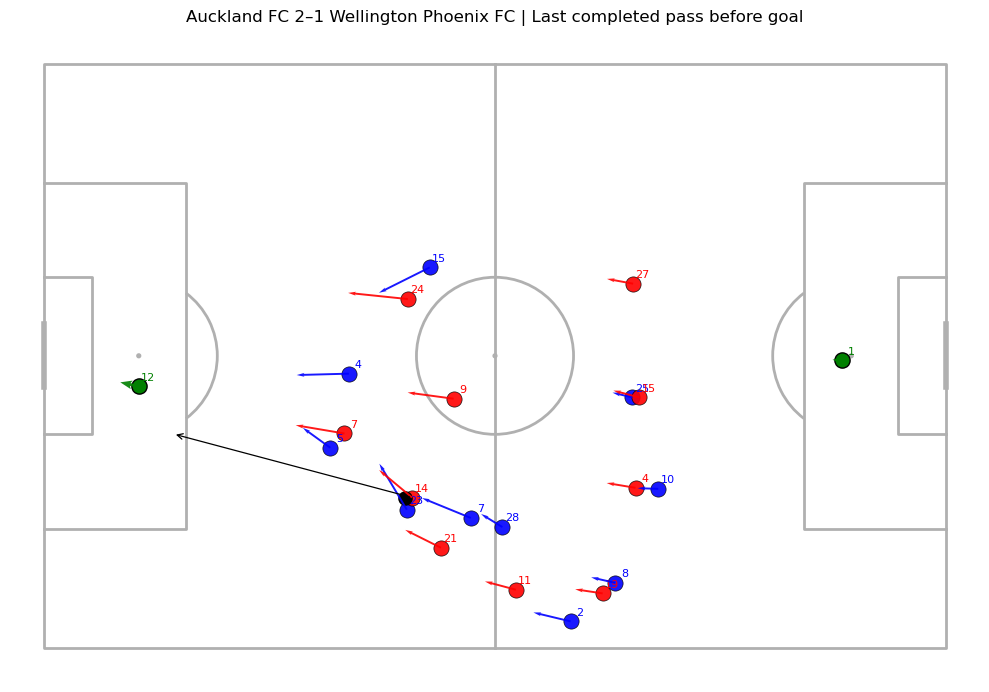

In [25]:
#1) match label
ctx = match_context(match_meta_df)

# 2) plot
fig, ax = plot_tracking_frame(
    tracking_df=enriched_tracking_norm,
    selected_frame=int(row["pass_moment_frame"]),
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    ARROW=True,
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
    pass_x_end=float(row["pass_x_end"]),
    pass_y_end=float(row["pass_y_end"]),
    SHOW_MOVEMENT=True,          # <-- toggle
    SHOW_SPEED_LABELS=False,     # <-- toggle
    movement_scale=0.8,
    movement_min_speed=0.0,
    WORKING_DIR=PROJECT_ROOT,
    SAVE=False,
    save_name=f"{MATCH_ID}_frame_{int(row['pass_moment_frame'])}_movement.png",
)
plt.show()

In [24]:
from __future__ import annotations

from pathlib import Path
from typing import Optional

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def make_pass_to_goal_video_mp4(
    *,
    tracking_df: pd.DataFrame,
    team_colors: dict[int, str],
    row: pd.Series,
    fps_in: int = 10,
    stride: int = 2,
    extra_seconds_before_pass: float = 1.0,
    extra_seconds_after_goal: float = 3.0,  # <-- 3 sek ekstra etter mål (default)
    freeze_seconds_before_start: float = 1.0,  # <-- 1 sek stillbilde i start (default)
    # Optional overrides
    clip_start: Optional[int] = None,
    clip_end: Optional[int] = None,
    # Plot options
    match_label: Optional[str] = None,
    title_prefix: str = "Last completed pass before goal",
    gk_color: str = "green",
    # NEW: Movement arrows options (passed through to plot_tracking_frame)
    SHOW_MOVEMENT: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.0,
    # Output / IO
    WORKING_DIR: Optional[Path] = None,
    save_name: Optional[str] = None,
    SAVE: bool = True,
    SHOW: bool = False,
) -> Optional[Path]:
    """
    Create an MP4 clip around a pass -> goal sequence, without saving PNG frames.

    Real-time speed without all frames:
        - sample every `stride` frames
        - set output fps = fps_in / stride

    Added:
        - freeze first frame for `freeze_seconds_before_start` seconds
        - extend clip end by `extra_seconds_after_goal` seconds

    Notes:
        - Movement arrows require tracking_df to contain 'vx', 'vy', and 'speed' columns.
    """
    if stride < 1:
        raise ValueError("stride must be >= 1")

    required_row_cols = {
        "pass_moment_frame",
        "goal_frame_start",
        "pass_x_start",
        "pass_y_start",
        "pass_x_end",
        "pass_y_end",
    }
    missing = required_row_cols.difference(row.index)
    if missing:
        raise KeyError(f"Row is missing required columns: {sorted(missing)}")

    # Optional validation: only enforce if user wants movement arrows
    if SHOW_MOVEMENT:
        required_movement_cols = {"vx", "vy", "speed"}
        missing_mv = required_movement_cols.difference(tracking_df.columns)
        if missing_mv:
            raise KeyError(
                "SHOW_MOVEMENT=True requires tracking_df to contain columns "
                f"{sorted(required_movement_cols)}. Missing: {sorted(missing_mv)}"
            )

    base_dir: Path = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
    out_dir: Path = base_dir / "viz" / "videos"
    out_dir.mkdir(parents=True, exist_ok=True)

    pass_frame = int(row["pass_moment_frame"])
    goal_frame = int(row["goal_frame_start"])

    if clip_start is None:
        clip_start = pass_frame - int(round(extra_seconds_before_pass * fps_in))
    if clip_end is None:
        clip_end = goal_frame + int(round(extra_seconds_after_goal * fps_in))

    min_frame = int(tracking_df["frame"].min())
    max_frame = int(tracking_df["frame"].max())
    clip_start = max(min_frame, int(clip_start))
    clip_end = min(max_frame, int(clip_end))
    if clip_end <= clip_start:
        raise ValueError(f"Invalid clip window: clip_start={clip_start}, clip_end={clip_end}")

    frame_numbers = list(range(clip_start, clip_end + 1, stride))
    fps_out = float(fps_in) / float(stride)

    if save_name is None:
        goal_id = str(row.get("goal_event_id", "goal"))
        save_name = f"pass_to_goal_{goal_id}_frames_{clip_start}_{clip_end}_s{stride}.mp4"

    out_path = out_dir / save_name

    # How many times to repeat the first frame to create a freeze
    freeze_frames = int(round(float(freeze_seconds_before_start) * fps_out))

    if SAVE:
        with imageio.get_writer(str(out_path), fps=fps_out) as writer:
            # --- 1) Render FIRST frame once, then repeat it (freeze) ---
            first_fr = frame_numbers[0]
            fig, ax = plot_tracking_frame(
                tracking_df=tracking_df,
                selected_frame=int(first_fr),
                team_colors=team_colors,
                gk_color=gk_color,
                match_label=match_label,
                title_prefix=title_prefix,
                ARROW=False,
                pass_x_start=float(row["pass_x_start"]),
                pass_y_start=float(row["pass_y_start"]),
                pass_x_end=float(row["pass_x_end"]),
                pass_y_end=float(row["pass_y_end"]),
                # NEW: movement arrows
                SHOW_MOVEMENT=SHOW_MOVEMENT,
                movement_scale=movement_scale,
                movement_min_speed=movement_min_speed,
                SAVE=False,
            )
            first_img = fig_to_rgb_array(fig)
            plt.close(fig)

            # write freeze frames
            for _ in range(max(0, freeze_frames)):
                writer.append_data(first_img)

            # --- 2) Then write the rest of the clip normally ---
            # (include first_fr too? usually no, since we already froze on it)
            for fr in frame_numbers:
                snap = tracking_df.loc[tracking_df["frame"] == int(fr)]
                if snap.empty:
                    continue

                fig, ax = plot_tracking_frame(
                    tracking_df=tracking_df,
                    selected_frame=int(fr),
                    team_colors=team_colors,
                    gk_color=gk_color,
                    match_label=match_label,
                    title_prefix=title_prefix,
                    ARROW=False,
                    pass_x_start=float(row["pass_x_start"]),
                    pass_y_start=float(row["pass_y_start"]),
                    pass_x_end=float(row["pass_x_end"]),
                    pass_y_end=float(row["pass_y_end"]),
                    # NEW: movement arrows
                    SHOW_MOVEMENT=SHOW_MOVEMENT,
                    movement_scale=movement_scale,
                    movement_min_speed=movement_min_speed,
                    SAVE=False,
                )

                img = fig_to_rgb_array(fig)
                writer.append_data(img)
                plt.close(fig)

        print(f"Saved video: {out_path}")

    if SHOW:
        try:
            from IPython.display import Video, display
            display(Video(str(out_path), embed=True))
        except Exception as e:
            print(f"[INFO] Could not display inline video. Reason: {e}")

    return out_path if SAVE else None


# Example usage:
video_path = make_pass_to_goal_video_mp4(
    tracking_df=enriched_tracking_norm,
    team_colors=TEAM_COLORS,
    row=row,
    fps_in=10,
    stride=2,
    freeze_seconds_before_start=5.0,
    extra_seconds_after_goal=0.0,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    WORKING_DIR=PROJECT_ROOT,
    SAVE=False,
    SHOW=True,
    save_name=f"{MATCH_ID}_goal1_pass_to_goal.mp4",
    # NEW
    SHOW_MOVEMENT=True,
    movement_scale=0.8,
    movement_min_speed=0.0,
)

Saved pitch control plot: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\PC_match_1899585_frame_51872_grid100.png


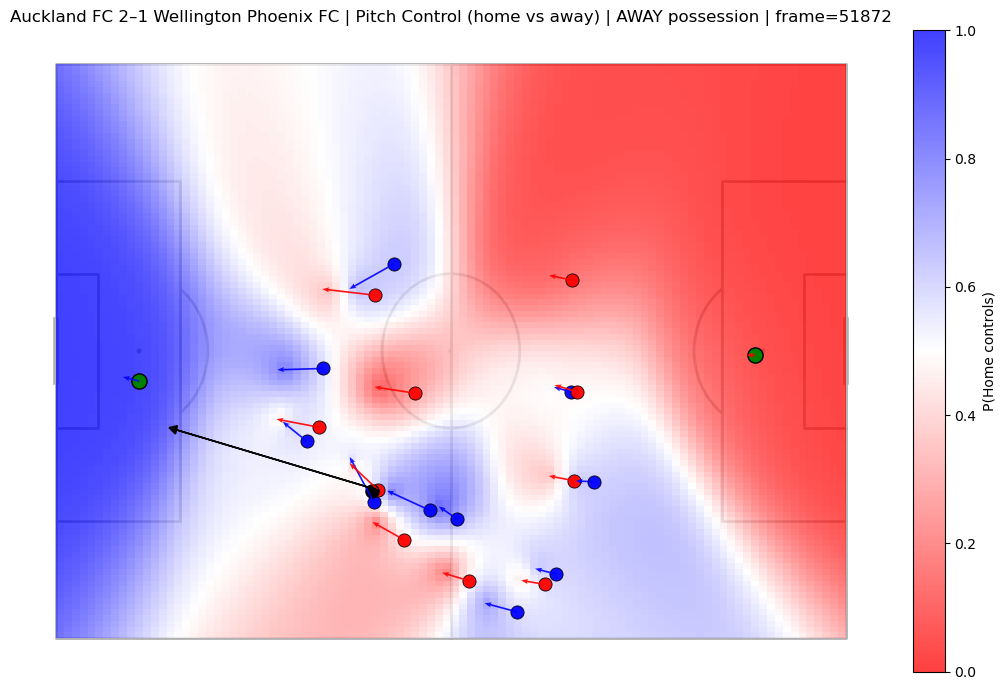

In [26]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch


# =============================================================================
# Working directory (base for saving)
# =============================================================================
PROJECT_ROOT: Path = Path.cwd()


# =============================================================================
# Pitch + data constants (SkillCorner)
# =============================================================================
PITCH_LENGTH: float = 105.0
PITCH_WIDTH: float = 68.0
FPS_IN: int = 10  # SkillCorner open data is typically 10 fps


# =============================================================================
# Utilities
# =============================================================================
def _safe_filename(text: str) -> str:
    """Return a filesystem-safe filename stem (very simple sanitizer)."""
    keep: list[str] = []
    for ch in str(text):
        if ch.isalnum() or ch in ("-", "_"):
            keep.append(ch)
        elif ch.isspace():
            keep.append("_")
    out = "".join(keep).strip("_")
    return out or "plot"


def draw_pass_arrow(
    ax: plt.Axes,
    *,
    pass_start: tuple[float, float],
    pass_end: tuple[float, float],
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    pass_zorder: int = 10,
) -> None:
    """Draw a pass arrow on an existing axis."""
    sx, sy = float(pass_start[0]), float(pass_start[1])
    ex, ey = float(pass_end[0]), float(pass_end[1])

    ax.arrow(
        sx,
        sy,
        ex - sx,
        ey - sy,
        length_includes_head=True,
        head_width=float(pass_headwidth),
        head_length=float(pass_headlength),
        linewidth=float(pass_lw),
        color=str(pass_color),
        alpha=float(pass_alpha),
        zorder=int(pass_zorder),
    )


def add_player_velocity(
    tracking_df: pd.DataFrame,
    *,
    fps: int = FPS_IN,
    x_col: str = "x",
    y_col: str = "y",
    player_id_col: str = "player_id",
    frame_col: str = "frame",
) -> pd.DataFrame:
    """
    Add per-player velocities (vx, vy) and speed using frame-to-frame diffs.

    Requirements
    ------------
    tracking_df must contain: [player_id_col, frame_col, x_col, y_col]

    Returns
    -------
    Copy of tracking_df with:
      - dx, dy (m/frame)
      - vx, vy (m/s)
      - speed (m/s)
    """
    df = tracking_df.copy()

    required = {player_id_col, frame_col, x_col, y_col}
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required tracking columns: {sorted(missing)}")

    df = df.sort_values([player_id_col, frame_col], kind="mergesort")
    df["dx"] = df.groupby(player_id_col, sort=False)[x_col].diff()
    df["dy"] = df.groupby(player_id_col, sort=False)[y_col].diff()

    df["vx"] = df["dx"] * float(fps)
    df["vy"] = df["dy"] * float(fps)
    df["speed"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2)

    for c in ["dx", "dy", "vx", "vy", "speed"]:
        df[c] = df[c].fillna(0.0)

    return df


# =============================================================================
# Pitch Control parameters
# =============================================================================
@dataclass(frozen=True)
class PitchControlParams:
    """Parameters for the pitch control model."""
    ball_speed_mps: float = 15.0
    a_max: float = 5.0
    v_max: float = 7.0
    reaction_time: float = 0.7
    lam: float = 4.30
    sigma_t: float = 0.45
    dt: float = 0.04
    t_max: float = 10.0
    tol: float = 1e-3


# =============================================================================
# Possession helper (OPTIONAL: only used for title text)
# =============================================================================
def get_possession_team_at_frame(
    de_norm: pd.DataFrame,
    *,
    frame_id: int,
    home_team_id: int,
    away_team_id: int,
    prefer_event_types: tuple[str, ...] = ("player_possession", "ball_possession"),
    team_cols_priority: tuple[str, ...] = ("team_id", "team_in_possession_id", "possession_team_id"),
) -> int:
    """
    Infer possession team at a frame from event data (de_norm).

    Used only for labeling (not for the heatmap itself).
    """
    for col in ("frame_start", "event_type"):
        if col not in de_norm.columns:
            raise KeyError(f"de_norm must contain '{col}'")

    frame_id = int(frame_id)
    home_team_id = int(home_team_id)
    away_team_id = int(away_team_id)

    has_frame_end = "frame_end" in de_norm.columns
    if has_frame_end:
        candidates = de_norm.loc[
            (de_norm["frame_start"] <= frame_id) & (de_norm["frame_end"] >= frame_id)
        ].copy()
    else:
        candidates = pd.DataFrame()

    if candidates.empty:
        candidates = de_norm.loc[de_norm["frame_start"] <= frame_id].copy()
        if candidates.empty:
            return home_team_id

    preferred = candidates.loc[candidates["event_type"].isin(prefer_event_types)].copy()
    if preferred.empty:
        preferred = candidates

    sort_cols = ["frame_start"]
    if "index" in preferred.columns:
        sort_cols.append("index")
    preferred = preferred.sort_values(sort_cols, ascending=True)

    src = preferred.iloc[-1]

    team_id: Optional[int] = None
    for col in team_cols_priority:
        if col in src.index and pd.notna(src[col]):
            team_id = int(src[col])
            break

    if team_id is None or team_id not in {home_team_id, away_team_id}:
        return home_team_id

    return int(team_id)


# =============================================================================
# Core PC model functions
# =============================================================================
def arrival_sigmoid(t: float, t_arr: np.ndarray, *, sigma_t: float) -> np.ndarray:
    """Sigmoid smoothing of player availability around arrival time."""
    z = (float(t) - t_arr) / max(float(sigma_t), 1e-6)
    z = np.clip(z, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))


def player_arrival_time_to_point(
    px: float,
    py: float,
    vx: float,
    vy: float,
    tx: float,
    ty: float,
    *,
    reaction_time: float,
    v_max: float,
    a_max: float,
) -> float:
    """
    Earliest arrival time to (tx, ty).

    Model:
      - Continue current velocity for reaction_time
      - Then accelerate towards target (a_max) up to v_max, then cruise
    """
    x_r = float(px) + float(vx) * float(reaction_time)
    y_r = float(py) + float(vy) * float(reaction_time)

    dist = float(np.hypot(float(tx) - x_r, float(ty) - y_r))
    if dist < 1e-6:
        return float(reaction_time)

    t_to_vmax = float(v_max) / max(float(a_max), 1e-6)
    d_accel = 0.5 * float(a_max) * (t_to_vmax ** 2)

    if dist <= d_accel:
        t_run = float(np.sqrt(2.0 * dist / max(float(a_max), 1e-6)))
    else:
        d_cruise = dist - d_accel
        t_run = t_to_vmax + (d_cruise / max(float(v_max), 1e-6))

    return float(reaction_time + t_run)


def pitch_control_at_point(
    players_home: pd.DataFrame,
    players_away: pd.DataFrame,
    *,
    ball_xy: tuple[float, float],
    point_xy: tuple[float, float],
    params: PitchControlParams,
) -> float:
    """Competing-hazards integration to compute P(home controls point) in [0,1]."""
    bx, by = float(ball_xy[0]), float(ball_xy[1])
    x, y = float(point_xy[0]), float(point_xy[1])

    t_ball = float(np.hypot(x - bx, y - by)) / max(float(params.ball_speed_mps), 1e-6)

    t_arr_home = np.array(
        [
            player_arrival_time_to_point(
                p.x, p.y, p.vx, p.vy, x, y,
                reaction_time=params.reaction_time,
                v_max=params.v_max,
                a_max=params.a_max,
            )
            for p in players_home.itertuples(index=False)
        ],
        dtype=float,
    )
    t_arr_away = np.array(
        [
            player_arrival_time_to_point(
                p.x, p.y, p.vx, p.vy, x, y,
                reaction_time=params.reaction_time,
                v_max=params.v_max,
                a_max=params.a_max,
            )
            for p in players_away.itertuples(index=False)
        ],
        dtype=float,
    )

    t = float(t_ball)
    p_home = 0.0
    p_away = 0.0

    while t < t_ball + float(params.t_max):
        a_home = float(np.sum(arrival_sigmoid(t, t_arr_home, sigma_t=params.sigma_t)))
        a_away = float(np.sum(arrival_sigmoid(t, t_arr_away, sigma_t=params.sigma_t)))

        r_home = float(params.lam) * a_home
        r_away = float(params.lam) * a_away

        p_free = max(0.0, 1.0 - p_home - p_away)
        p_home += p_free * r_home * float(params.dt)
        p_away += p_free * r_away * float(params.dt)

        if (1.0 - (p_home + p_away)) < float(params.tol):
            break

        t += float(params.dt)

    if (p_home + p_away) < 1e-9:
        return 0.5

    return float(p_home / (p_home + p_away))


def compute_pitch_control_grid(
    enriched_tracking_norm: pd.DataFrame,
    *,
    frame_id: int,
    home_team_id: int,
    away_team_id: int,
    grid_n: int = 50,
    pitch_length: float = PITCH_LENGTH,
    pitch_width: float = PITCH_WIDTH,
    params: PitchControlParams = PitchControlParams(),
) -> tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
    """
    Compute PC grid for one frame: grid[y, x] = P(home controls).
    """
    df = enriched_tracking_norm.copy()

    required = {"frame", "team_id", "x", "y", "ball_x", "ball_y", "player_id"}
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required columns in enriched_tracking_norm: {sorted(missing)}")

    if "is_gk" not in df.columns:
        df["is_gk"] = False

    if not {"vx", "vy", "speed"}.issubset(df.columns):
        df = add_player_velocity(df, fps=FPS_IN)

    frame_id = int(frame_id)
    frame_df = df.loc[df["frame"] == frame_id].copy()
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={frame_id}")

    ball_xy = (float(frame_df["ball_x"].iloc[0]), float(frame_df["ball_y"].iloc[0]))

    players_home = frame_df.loc[
        frame_df["team_id"] == int(home_team_id), ["x", "y", "vx", "vy", "is_gk"]
    ]
    players_away = frame_df.loc[
        frame_df["team_id"] == int(away_team_id), ["x", "y", "vx", "vy", "is_gk"]
    ]
    if players_home.empty or players_away.empty:
        raise ValueError(f"Missing players for one team at frame={frame_id}")

    x_grid = np.linspace(-pitch_length / 2.0, pitch_length / 2.0, int(grid_n))
    y_grid = np.linspace(-pitch_width / 2.0, pitch_width / 2.0, int(grid_n))
    grid = np.zeros((int(grid_n), int(grid_n)), dtype=float)

    for ix, x in enumerate(x_grid):
        for iy, y in enumerate(y_grid):
            grid[iy, ix] = pitch_control_at_point(
                players_home,
                players_away,
                ball_xy=ball_xy,
                point_xy=(float(x), float(y)),
                params=params,
            )

    meta = {
        "frame_id": frame_id,
        "ball_xy": ball_xy,
        "home_team_id": int(home_team_id),
        "away_team_id": int(away_team_id),
        "grid_n": int(grid_n),
        "params": params.__dict__,
    }
    return grid, x_grid, y_grid, meta


# =============================================================================
# Plotting (HOME vs AWAY in one heatmap)
# =============================================================================
def plot_pitch_control_home_away_heatmap(
    *,
    pc_home_grid: np.ndarray,  # P(home controls) in [0,1]
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    frame_df: pd.DataFrame,
    team_colors: dict[int, str],
    gk_color: str,
    home_team_id: int,
    away_team_id: int,
    title: str,
    alpha: float = 0.75,
    # movement
    show_movement: bool = False,
    movement_scale: float = 1.0,
    movement_min_speed: float = 0.0,
    # pass
    show_pass: bool = False,
    pass_start: Optional[tuple[float, float]] = None,
    pass_end: Optional[tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
) -> tuple[plt.Figure, plt.Axes]:
    """
    Heatmap shows BOTH teams at once via P(home controls):

      - Blue-ish areas => high P(home controls)
      - Red-ish areas  => low P(home controls) => away controls

    Uses cmap="bwr", vmin=0..1.
    """
    pitch = Pitch(pitch_type="skillcorner", pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH)
    fig, ax = pitch.draw(figsize=(10, 7))

    if "is_gk" not in frame_df.columns:
        frame_df = frame_df.copy()
        frame_df["is_gk"] = False

    if show_movement:
        needed = {"vx", "vy", "speed"}
        miss = needed.difference(frame_df.columns)
        if miss:
            raise KeyError(
                f"show_movement=True requires {sorted(needed)} in frame_df. "
                "Compute velocities with add_player_velocity(...) first."
            )

    extent = [float(x_grid.min()), float(x_grid.max()), float(y_grid.min()), float(y_grid.max())]
    im = ax.imshow(
        pc_home_grid,
        origin="lower",
        extent=extent,
        aspect="auto",
        cmap="bwr_r",
        vmin=0.0,
        vmax=1.0,
        alpha=float(alpha),
        zorder=1,
    )
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="P(Home controls)")

    # Players + movement arrows (arrows match scatter color)
    for team_id in [int(home_team_id), int(away_team_id)]:
        color = team_colors.get(int(team_id), "gray")
        team_rows = frame_df.loc[frame_df["team_id"] == int(team_id)]
        if team_rows.empty:
            continue

        outfield = team_rows.loc[~team_rows["is_gk"]]
        gks = team_rows.loc[team_rows["is_gk"]]

        if not outfield.empty:
            ax.scatter(
                outfield["x"], outfield["y"],
                s=90,
                color=color,
                edgecolors="black",
                linewidth=0.6,
                alpha=0.95,
                zorder=5,
            )

        if not gks.empty:
            ax.scatter(
                gks["x"], gks["y"],
                s=120,
                color=str(gk_color),
                edgecolors="black",
                linewidth=1.0,
                alpha=1.0,
                zorder=6,
            )

        if show_movement and not team_rows.empty:
            moving = team_rows.loc[team_rows["speed"].astype(float) >= float(movement_min_speed)]
            if not moving.empty:
                ax.quiver(
                    moving["x"].astype(float).to_numpy(),
                    moving["y"].astype(float).to_numpy(),
                    (moving["vx"].astype(float).to_numpy() * float(movement_scale)),
                    (moving["vy"].astype(float).to_numpy() * float(movement_scale)),
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    width=0.002,
                    headwidth=3,
                    headlength=4,
                    headaxislength=3.5,
                    color=color,
                    alpha=0.9,
                    zorder=8,
                )

    # Ball
    ax.scatter(
        float(frame_df["ball_x"].iloc[0]),
        float(frame_df["ball_y"].iloc[0]),
        s=90,
        color="black",
        zorder=7,
    )

    # Pass arrow
    if bool(show_pass):
        if pass_start is None or pass_end is None:
            raise ValueError("show_pass=True requires pass_start and pass_end.")
        draw_pass_arrow(
            ax,
            pass_start=pass_start,
            pass_end=pass_end,
            pass_color=str(pass_color),
            pass_lw=float(pass_lw),
            pass_headwidth=float(pass_headwidth),
            pass_headlength=float(pass_headlength),
            pass_alpha=float(pass_alpha),
            pass_zorder=10,
        )

    ax.set_title(title)
    return fig, ax


# =============================================================================
# Runner
# =============================================================================
def run_pitch_control_frame(
    *,
    enriched_tracking_norm: pd.DataFrame,
    de_norm: pd.DataFrame,  # only used for title text (optional)
    frame_id: int,
    match_meta_df: pd.DataFrame,
    team_colors: dict[int, str],
    gk_color: str,
    grid_n: int = 50,
    params: PitchControlParams = PitchControlParams(),
    match_label: Optional[str] = None,
    title_prefix: Optional[str] = None,
    include_possession_in_title: bool = True,
    # movement
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.0,
    # pass
    show_pass: bool = False,
    pass_start: Optional[tuple[float, float]] = None,
    pass_end: Optional[tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    # saving
    SAVE: bool = False,
    WORKING_DIR: Optional[Path] = None,
    save_prefix: Optional[str] = None,
    dpi: int = 200,
    SHOW: bool = True,
) -> dict:
    """
    Compute + plot Pitch Control for BOTH teams in one heatmap (blue home / red away).

    Notes
    -----
    - Heatmap is ALWAYS P(home controls) with cmap bwr_r, vmin=0..1.
    - Possession (from de_norm) is OPTIONAL and used only for title text.
    - Auto save filename includes "PC" + frame_id => unique per frame.
    """
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])
    frame_id = int(frame_id)

    # Ensure velocity columns exist if movement is requested
    df = enriched_tracking_norm
    if show_movement and not {"vx", "vy", "speed"}.issubset(df.columns):
        df = add_player_velocity(df, fps=FPS_IN)

    # Compute PC home grid
    pc_home_grid, x_grid, y_grid, meta = compute_pitch_control_grid(
        df,
        frame_id=frame_id,
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        grid_n=int(grid_n),
        params=params,
    )

    # Frame slice for plotting
    frame_df = df.loc[df["frame"] == frame_id].copy()
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={frame_id}")

    # Title
    parts: list[str] = []
    if match_label:
        parts.append(str(match_label))
    parts.append(str(title_prefix) if title_prefix else "Pitch Control")
    base_title = " | ".join([p for p in parts if p])

    if include_possession_in_title:
        poss_team = get_possession_team_at_frame(
            de_norm,
            frame_id=frame_id,
            home_team_id=home_team_id,
            away_team_id=away_team_id,
        )
        poss_txt = "HOME possession" if poss_team == home_team_id else "AWAY possession"
        title = f"{base_title} | {poss_txt} | frame={frame_id}"
    else:
        title = f"{base_title} | frame={frame_id}"

    fig, _ax = plot_pitch_control_home_away_heatmap(
        pc_home_grid=pc_home_grid,
        x_grid=x_grid,
        y_grid=y_grid,
        frame_df=frame_df,
        team_colors=team_colors,
        gk_color=gk_color,
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        title=title,
        alpha=0.75,
        show_movement=bool(show_movement),
        movement_scale=float(movement_scale),
        movement_min_speed=float(movement_min_speed),
        show_pass=bool(show_pass),
        pass_start=pass_start,
        pass_end=pass_end,
        pass_color=str(pass_color),
        pass_lw=float(pass_lw),
        pass_headwidth=float(pass_headwidth),
        pass_headlength=float(pass_headlength),
        pass_alpha=float(pass_alpha),
    )

    out_path: Optional[Path] = None
    if SAVE:
        base_dir = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
        out_dir = base_dir / "viz"
        out_dir.mkdir(parents=True, exist_ok=True)

        prefix = save_prefix or "plot"
        filename_stem = _safe_filename(f"PC_{prefix}_frame_{frame_id}_grid{int(grid_n)}")
        out_path = out_dir / f"{filename_stem}.png"

        fig.savefig(out_path, dpi=int(dpi), bbox_inches="tight")
        print(f"Saved pitch control plot: {out_path}")

    if SHOW:
        plt.show()
    else:
        plt.close(fig)

    return {
        "pc_home_grid": pc_home_grid,
        "x_grid": x_grid,
        "y_grid": y_grid,
        "meta": meta,
        "out_path": str(out_path) if out_path else None,
    }


# =============================================================================
# Example usage
# =============================================================================
pc_out = run_pitch_control_frame(
     enriched_tracking_norm=enriched_tracking_norm,
     de_norm=de_norm,
     frame_id=int(row["pass_moment_frame"]), # or put in any frame_id 
     match_meta_df=match_meta_df,
     team_colors=TEAM_COLORS,
     gk_color=GK_COLOR,
     grid_n=100,
     params=PitchControlParams(),
     match_label=ctx["match_label"],
     title_prefix="Pitch Control (home vs away)",
     include_possession_in_title=True,
     show_movement=True,
     show_pass=True,
     pass_start=(-9.66, -16.51),
     pass_end=(-37.49, -9.10),
     SAVE=True,
     WORKING_DIR=PROJECT_ROOT,
     save_prefix=f"match_{MATCH_ID}",
     dpi=200,
     SHOW=True,
 )


In [157]:
from __future__ import annotations

from pathlib import Path
from typing import Optional, Tuple, List

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NOTE:
# This video code assumes you already have these from your PC code in scope:
# - PITCH_LENGTH, PITCH_WIDTH, FPS_IN
# - _safe_filename
# - add_player_velocity
# - compute_pitch_control_grid
# - plot_pitch_control_home_away_heatmap
# - PitchControlParams
# - fig_to_rgb_array


def make_pitch_control_video_mp4(
    *,
    enriched_tracking_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    team_colors: dict[int, str],
    clip_start: int,
    clip_end: int,
    fps_in: int = FPS_IN,
    stride: int = 2,
    grid_n: int = 60,
    pc_params: "PitchControlParams" = None,  # type: ignore[name-defined]
    # Smoothness
    interpolate_between_computed_frames: bool = True,
    interp_steps_between: int = 1,
    # Plot
    gk_color: str = "gold",
    alpha: float = 0.75,
    # Optional overlays
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.0,
    show_pass: bool = False,
    pass_start: Optional[Tuple[float, float]] = None,
    pass_end: Optional[Tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    # Title options
    match_label: Optional[str] = None,
    title_prefix: Optional[str] = None,
    include_frame_in_title: bool = True,
    # Output
    WORKING_DIR: Optional[Path] = None,
    save_name: Optional[str] = None,
    SAVE: bool = True,
    SHOW: bool = False,
) -> Optional[Path]:
    """
    Create an MP4 pitch-control video for frames [clip_start, clip_end] using your *current* PC code.

    This version uses:
      - compute_pitch_control_grid(...)  (your PC compute function)
      - plot_pitch_control_home_away_heatmap(...) (your PC plot function)

    Notes
    -----
    - If show_movement=True, vx/vy/speed must exist; we compute them once for the whole tracking_df if missing.
    - If interpolate_between_computed_frames=True, we linearly blend PC grids between computed frames.
      The player/ball positions for in-between frames are taken from the nearest real frame (cheap + consistent).
    """
    if pc_params is None:
        pc_params = PitchControlParams()  # type: ignore[name-defined]

    if clip_end <= clip_start:
        raise ValueError("clip_end must be > clip_start")
    if stride < 1:
        raise ValueError("stride must be >= 1")
    if interp_steps_between < 0:
        raise ValueError("interp_steps_between must be >= 0")
    if show_pass and (pass_start is None or pass_end is None):
        raise ValueError("show_pass=True requires pass_start and pass_end.")

    # Home/away IDs
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])

    # Output paths
    base_dir: Path = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
    out_dir: Path = base_dir / "viz" / "videos"
    out_dir.mkdir(parents=True, exist_ok=True)

    if save_name is None:
        stem = _safe_filename(
            f"pitch_control_{clip_start}_{clip_end}_s{stride}_grid{grid_n}"
        )
        save_name = f"{stem}.mp4"
    out_path = out_dir / save_name

    # Build static title base (frame suffix optionally added per frame)
    title_parts: List[str] = []
    if match_label:
        title_parts.append(str(match_label))
    if title_prefix:
        title_parts.append(str(title_prefix))
    base_title = " | ".join(title_parts) if title_parts else "Pitch Control"

    # Frames we actually compute PC for
    compute_frames = list(range(int(clip_start), int(clip_end) + 1, int(stride)))
    if compute_frames[-1] != int(clip_end):
        compute_frames.append(int(clip_end))

    # Output fps
    fps_base = float(fps_in) / float(stride)
    fps_out = fps_base * (interp_steps_between + 1) if interpolate_between_computed_frames else fps_base

    if not SAVE and not SHOW:
        return None

    # If user wants SHOW, we must write it first
    if SHOW and not SAVE:
        SAVE = True

    # Prepare tracking (compute velocities once if needed)
    tracking = enriched_tracking_norm.copy()
    if show_movement and not {"vx", "vy", "speed"}.issubset(tracking.columns):
        tracking = add_player_velocity(tracking, fps=int(fps_in))

    writer = None
    if SAVE:
        writer = imageio.get_writer(
            str(out_path),
            fps=fps_out,
            format="ffmpeg",
            codec="libx264",
        )

    def _render_frame_from_grid(
        *,
        pc_grid: np.ndarray,
        x_grid: np.ndarray,
        y_grid: np.ndarray,
        frame_df: pd.DataFrame,
        frame_id: int,
    ) -> np.ndarray:
        title = base_title
        if include_frame_in_title:
            title = f"{base_title} | frame={int(frame_id)}"

        fig, _ax = plot_pitch_control_home_away_heatmap(
            pc_home_grid=pc_grid,
            x_grid=x_grid,
            y_grid=y_grid,
            frame_df=frame_df,
            team_colors=team_colors,
            gk_color=GK_COLOR,
            home_team_id=home_team_id,
            away_team_id=away_team_id,
            title=title,
            alpha=float(alpha),
            show_movement=bool(show_movement),
            movement_scale=float(movement_scale),
            movement_min_speed=float(movement_min_speed),
            show_pass=bool(show_pass),
            pass_start=pass_start,
            pass_end=pass_end,
            pass_color=str(pass_color),
            pass_lw=float(pass_lw),
            pass_headwidth=float(pass_headwidth),
            pass_headlength=float(pass_headlength),
            pass_alpha=float(pass_alpha),
        )
        img = fig_to_rgb_array(fig)
        plt.close(fig)
        return img

    try:
        # ---- First computed frame ----
        first_frame = int(compute_frames[0])

        pc_prev, x_grid, y_grid, _meta = compute_pitch_control_grid(
            tracking,
            frame_id=first_frame,
            home_team_id=home_team_id,
            away_team_id=away_team_id,
            grid_n=int(grid_n),
            params=pc_params,
        )
        frame_df_prev = tracking.loc[tracking["frame"] == first_frame].copy()
        if frame_df_prev.empty:
            raise ValueError(f"No tracking rows found for frame_id={first_frame}")

        img = _render_frame_from_grid(
            pc_grid=pc_prev,
            x_grid=x_grid,
            y_grid=y_grid,
            frame_df=frame_df_prev,
            frame_id=first_frame,
        )
        if writer is not None:
            writer.append_data(img)

        # ---- Subsequent computed frames ----
        for next_frame in compute_frames[1:]:
            next_frame = int(next_frame)

            pc_next, x_grid2, y_grid2, _meta2 = compute_pitch_control_grid(
                tracking,
                frame_id=next_frame,
                home_team_id=home_team_id,
                away_team_id=away_team_id,
                grid_n=int(grid_n),
                params=pc_params,
            )
            frame_df_next = tracking.loc[tracking["frame"] == next_frame].copy()
            if frame_df_next.empty:
                raise ValueError(f"No tracking rows found for frame_id={next_frame}")

            same_axes = (np.allclose(x_grid, x_grid2) and np.allclose(y_grid, y_grid2))

            # Interpolated in-between grids (optional)
            if interpolate_between_computed_frames and interp_steps_between > 0 and same_axes:
                for k in range(1, interp_steps_between + 1):
                    w = k / float(interp_steps_between + 1)
                    pc_mid = (1.0 - w) * pc_prev + w * pc_next

                    # Cheap and consistent: use nearest frame for players/ball
                    frame_df_use = frame_df_prev if w < 0.5 else frame_df_next
                    frame_id_use = first_frame if w < 0.5 else next_frame

                    img_mid = _render_frame_from_grid(
                        pc_grid=pc_mid,
                        x_grid=x_grid,
                        y_grid=y_grid,
                        frame_df=frame_df_use,
                        frame_id=frame_id_use,
                    )
                    if writer is not None:
                        writer.append_data(img_mid)

            # Render the actual next computed frame
            img_next = _render_frame_from_grid(
                pc_grid=pc_next,
                x_grid=x_grid2,
                y_grid=y_grid2,
                frame_df=frame_df_next,
                frame_id=next_frame,
            )
            if writer is not None:
                writer.append_data(img_next)

            # Advance state
            pc_prev = pc_next
            x_grid, y_grid = x_grid2, y_grid2
            frame_df_prev = frame_df_next
            first_frame = next_frame

    finally:
        if writer is not None:
            writer.close()

    if SAVE:
        print(f"Saved video: {out_path}")

    if SHOW:
        try:
            from IPython.display import Video, display  # type: ignore
            display(Video(str(out_path), embed=True))
        except Exception as e:
            print(f"[INFO] Could not display inline video. Reason: {e}")

    return out_path if SAVE else None


# ---------------------------
# Example usage
# ---------------------------
video_path = make_pitch_control_video_mp4(
    enriched_tracking_norm=enriched_tracking_norm,
    match_meta_df=match_meta_df,
    team_colors=TEAM_COLORS,
    clip_start=int(row["pass_moment_frame"]) - 30,  
    clip_end=int(row["pass_moment_frame"]) + 40,
    fps_in=10,
    stride=2,
    grid_n=50,
    pc_params=PitchControlParams(),  # tweak here if needed
    interpolate_between_computed_frames=True,
    interp_steps_between=1,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before third goal",
    include_frame_in_title=True,
    # overlays (optional)
    show_movement=True,
    show_pass=False,
    pass_start=(-9.66, -16.51),
    pass_end=(-37.49, -9.10),
    WORKING_DIR=PROJECT_ROOT,
    SAVE=True,
    SHOW=True,
    save_name="pitch_control_clip__last_goal.mp4",
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 700) to (1008, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved video: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\videos\pitch_control_clip__last_goal.mp4


In [154]:
# result fra de_norm
#result = get_last_completed_pass_before_all_goals(de_norm)
#row = result.loc[2] #second goal
#frame_id=int(row["pass_moment_frame"]) #Change if need to see another frame

Saved RPC plot: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\RPC_plot_frame_51872_grid100_facing_True.png


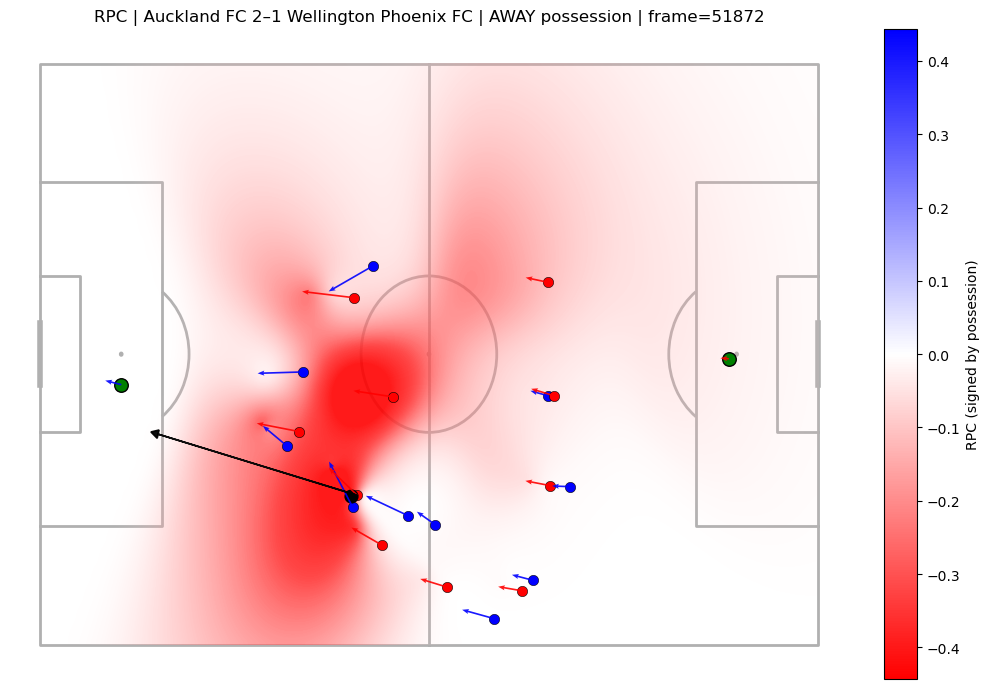

In [38]:
# =============================================================================
# RPC (Relevant Pitch Control) — computes Pitch Control internally
# NOTE: pc_gamma REMOVED (no sharpening of possession control)
#       tau_seconds DEFAULT set to 2.0
# =============================================================================
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch

# Optional plot-smoothing (plot-only)
try:
    from scipy.ndimage import gaussian_filter  # type: ignore
    _HAS_SCIPY = True
except Exception:
    gaussian_filter = None  # type: ignore
    _HAS_SCIPY = False

# =============================================================================
# Working directory (base for saving)
# =============================================================================
PROJECT_ROOT: Path = Path.cwd()

# =============================================================================
# Pitch + data constants (SkillCorner)
# =============================================================================
PITCH_LENGTH: float = 105.0
PITCH_WIDTH: float = 68.0
FPS_IN: int = 10


# =============================================================================
# Utilities
# =============================================================================
def _safe_filename(text: str) -> str:
    """Return a filesystem-safe filename stem (very simple sanitizer)."""
    keep: list[str] = []
    for ch in str(text):
        if ch.isalnum() or ch in ("-", "_"):
            keep.append(ch)
        elif ch.isspace():
            keep.append("_")
    out = "".join(keep).strip("_")
    return out or "plot"


def draw_pass_arrow(
    ax: plt.Axes,
    *,
    pass_start: tuple[float, float],
    pass_end: tuple[float, float],
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    pass_zorder: int = 10,
) -> None:
    """Draw a pass arrow on an existing axis."""
    sx, sy = float(pass_start[0]), float(pass_start[1])
    ex, ey = float(pass_end[0]), float(pass_end[1])

    ax.arrow(
        sx,
        sy,
        ex - sx,
        ey - sy,
        length_includes_head=True,
        head_width=float(pass_headwidth),
        head_length=float(pass_headlength),
        linewidth=float(pass_lw),
        color=str(pass_color),
        alpha=float(pass_alpha),
        zorder=int(pass_zorder),
    )


def add_player_velocity(
    tracking_df: pd.DataFrame,
    *,
    fps: int = FPS_IN,
    x_col: str = "x",
    y_col: str = "y",
    player_id_col: str = "player_id",
    frame_col: str = "frame",
) -> pd.DataFrame:
    """
    Add per-player velocities (vx, vy) and speed (m/s) using frame-to-frame diffs.

    Requirements
    ------------
    tracking_df must contain: [player_id_col, frame_col, x_col, y_col]
    """
    df = tracking_df.copy()
    required = {player_id_col, frame_col, x_col, y_col}
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required tracking columns: {sorted(missing)}")

    df = df.sort_values([player_id_col, frame_col], kind="mergesort")
    df["dx"] = df.groupby(player_id_col, sort=False)[x_col].diff()
    df["dy"] = df.groupby(player_id_col, sort=False)[y_col].diff()

    df["vx"] = df["dx"] * float(fps)
    df["vy"] = df["dy"] * float(fps)
    df["speed"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2)

    for c in ["dx", "dy", "vx", "vy", "speed"]:
        df[c] = df[c].fillna(0.0)

    return df


# =============================================================================
# Pitch Control (PC) — minimal subset used by RPC
# =============================================================================
@dataclass(frozen=True)
class PitchControlParams:
    """
    Parameters for Pitch Control (PC).

    Notes
    -----
    These match your PC implementation, so RPC can compute PC internally.
    """
    ball_speed_mps: float = 15.0
    a_max: float = 5.0
    v_max: float = 7.0
    reaction_time: float = 0.7
    lam: float = 4.30
    sigma_t: float = 0.45
    dt: float = 0.04
    t_max: float = 10.0
    tol: float = 1e-3


def arrival_sigmoid(t: float, t_arr: np.ndarray, *, sigma_t: float) -> np.ndarray:
    """Sigmoid smoothing of player availability around arrival time."""
    z = (float(t) - t_arr) / max(float(sigma_t), 1e-6)
    z = np.clip(z, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))


def player_arrival_time_to_point(
    px: float,
    py: float,
    vx: float,
    vy: float,
    tx: float,
    ty: float,
    *,
    reaction_time: float,
    v_max: float,
    a_max: float,
) -> float:
    """
    Earliest arrival time to (tx, ty).

    Model
    -----
    - Continue current velocity for reaction_time
    - Then accelerate towards target (a_max) up to v_max, then cruise
    """
    x_r = float(px) + float(vx) * float(reaction_time)
    y_r = float(py) + float(vy) * float(reaction_time)

    dist = float(np.hypot(float(tx) - x_r, float(ty) - y_r))
    if dist < 1e-6:
        return float(reaction_time)

    t_to_vmax = float(v_max) / max(float(a_max), 1e-6)
    d_accel = 0.5 * float(a_max) * (t_to_vmax ** 2)

    if dist <= d_accel:
        t_run = float(np.sqrt(2.0 * dist / max(float(a_max), 1e-6)))
    else:
        d_cruise = dist - d_accel
        t_run = t_to_vmax + (d_cruise / max(float(v_max), 1e-6))

    return float(reaction_time + t_run)


def pitch_control_at_point(
    players_home: pd.DataFrame,
    players_away: pd.DataFrame,
    *,
    ball_xy: tuple[float, float],
    point_xy: tuple[float, float],
    params: PitchControlParams,
) -> float:
    """Competing-hazards integration to compute P(home controls point) in [0,1]."""
    bx, by = float(ball_xy[0]), float(ball_xy[1])
    x, y = float(point_xy[0]), float(point_xy[1])

    t_ball = float(np.hypot(x - bx, y - by)) / max(float(params.ball_speed_mps), 1e-6)

    t_arr_home = np.array(
        [
            player_arrival_time_to_point(
                p.x, p.y, p.vx, p.vy, x, y,
                reaction_time=params.reaction_time,
                v_max=params.v_max,
                a_max=params.a_max,
            )
            for p in players_home.itertuples(index=False)
        ],
        dtype=float,
    )
    t_arr_away = np.array(
        [
            player_arrival_time_to_point(
                p.x, p.y, p.vx, p.vy, x, y,
                reaction_time=params.reaction_time,
                v_max=params.v_max,
                a_max=params.a_max,
            )
            for p in players_away.itertuples(index=False)
        ],
        dtype=float,
    )

    t = float(t_ball)
    p_home = 0.0
    p_away = 0.0

    while t < t_ball + float(params.t_max):
        a_home = float(np.sum(arrival_sigmoid(t, t_arr_home, sigma_t=params.sigma_t)))
        a_away = float(np.sum(arrival_sigmoid(t, t_arr_away, sigma_t=params.sigma_t)))

        r_home = float(params.lam) * a_home
        r_away = float(params.lam) * a_away

        p_free = max(0.0, 1.0 - p_home - p_away)
        p_home += p_free * r_home * float(params.dt)
        p_away += p_free * r_away * float(params.dt)

        if (1.0 - (p_home + p_away)) < float(params.tol):
            break

        t += float(params.dt)

    if (p_home + p_away) < 1e-9:
        return 0.5

    return float(p_home / (p_home + p_away))


def compute_pitch_control_grid(
    enriched_tracking_norm: pd.DataFrame,
    *,
    frame_id: int,
    home_team_id: int,
    away_team_id: int,
    grid_n: int = 100,
    pitch_length: float = PITCH_LENGTH,
    pitch_width: float = PITCH_WIDTH,
    params: PitchControlParams = PitchControlParams(),
    ensure_velocity: bool = True,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
    """
    Compute PC grid for one frame: grid[y, x] = P(home controls).

    Requirements
    ------------
    - enriched_tracking_norm must include: frame, team_id, x, y, ball_x, ball_y, player_id
    - If ensure_velocity=True, vx/vy/speed will be computed if missing.
    """
    df = enriched_tracking_norm.copy()

    required = {"frame", "team_id", "x", "y", "ball_x", "ball_y", "player_id"}
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required columns in enriched_tracking_norm: {sorted(missing)}")

    if ensure_velocity and not {"vx", "vy", "speed"}.issubset(df.columns):
        df = add_player_velocity(df, fps=FPS_IN)

    frame_id = int(frame_id)
    frame_df = df.loc[df["frame"] == frame_id].copy()
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={frame_id}")

    ball_xy = (float(frame_df["ball_x"].iloc[0]), float(frame_df["ball_y"].iloc[0]))

    players_home = frame_df.loc[
        frame_df["team_id"] == int(home_team_id), ["x", "y", "vx", "vy"]
    ]
    players_away = frame_df.loc[
        frame_df["team_id"] == int(away_team_id), ["x", "y", "vx", "vy"]
    ]
    if players_home.empty or players_away.empty:
        raise ValueError(f"Missing players for one team at frame={frame_id}")

    x_grid = np.linspace(-pitch_length / 2.0, pitch_length / 2.0, int(grid_n))
    y_grid = np.linspace(-pitch_width / 2.0, pitch_width / 2.0, int(grid_n))
    grid = np.zeros((int(grid_n), int(grid_n)), dtype=float)

    for ix, x in enumerate(x_grid):
        for iy, y in enumerate(y_grid):
            grid[iy, ix] = pitch_control_at_point(
                players_home,
                players_away,
                ball_xy=ball_xy,
                point_xy=(float(x), float(y)),
                params=params,
            )

    meta = {
        "frame_id": frame_id,
        "ball_xy": ball_xy,
        "home_team_id": int(home_team_id),
        "away_team_id": int(away_team_id),
        "grid_n": int(grid_n),
        "pc_params": params.__dict__,
    }
    return grid, x_grid, y_grid, meta


# =============================================================================
# RPC (Relevant Pitch Control) — pc_gamma REMOVED
# =============================================================================
@dataclass(frozen=True)
class RPCParams:
    """
    Parameters for Relevant Pitch Control (RPC).

    Model
    -----
    RPC(x,y) = PC_poss(x,y) * w_ball(x,y) * w_face(x,y)  (optional)

    - PC_poss is pitch-control probability for the team in possession.
    - w_ball decays with ball travel time.
    - w_face optionally boosts points in the player-in-possession's facing direction.
    """
    # Ball relevance
    ball_speed_mps: float = 15.0
    tau_seconds: float = 2.0  # UPDATED default

    # Facing (optional)
    use_facing: bool = False
    facing_strength: float = 0.8
    facing_gamma: float = 0.5
    facing_min_speed: float = 0.1


# =============================================================================
# Event helpers (possession + optional player in possession)
# =============================================================================
def get_possession_team_at_frame(
    de_norm: pd.DataFrame,
    *,
    frame_id: int,
    home_team_id: int,
    away_team_id: int,
    prefer_event_types: tuple[str, ...] = ("player_possession", "ball_possession"),
    team_cols_priority: tuple[str, ...] = ("team_id", "team_in_possession_id", "possession_team_id"),
) -> int:
    """Infer possession team at a frame from dynamic events."""
    for col in ("frame_start", "event_type"):
        if col not in de_norm.columns:
            raise KeyError(f"de_norm must contain '{col}'")

    frame_id = int(frame_id)
    has_frame_end = "frame_end" in de_norm.columns

    if has_frame_end:
        candidates = de_norm.loc[
            (de_norm["frame_start"] <= frame_id) & (de_norm["frame_end"] >= frame_id)
        ].copy()
    else:
        candidates = pd.DataFrame()

    if candidates.empty:
        candidates = de_norm.loc[de_norm["frame_start"] <= frame_id].copy()
        if candidates.empty:
            raise ValueError(f"No dynamic events found with frame_start <= {frame_id}")

    preferred = candidates.loc[candidates["event_type"].isin(prefer_event_types)].copy()
    if preferred.empty:
        preferred = candidates

    sort_cols = ["frame_start"]
    if "index" in preferred.columns:
        sort_cols.append("index")
    preferred = preferred.sort_values(sort_cols, ascending=True)

    src = preferred.iloc[-1]

    team_id: Optional[int] = None
    for col in team_cols_priority:
        if col in src.index and pd.notna(src[col]):
            team_id = int(src[col])
            break

    if team_id is None:
        raise ValueError("Could not infer possession team_id from de_norm.")

    if team_id not in {int(home_team_id), int(away_team_id)}:
        team_id = int(home_team_id)

    return int(team_id)


def get_player_in_possession_at_frame(
    de_norm: pd.DataFrame,
    *,
    frame_id: int,
    prefer_event_types: tuple[str, ...] = ("player_possession",),
    player_cols_priority: tuple[str, ...] = ("player_in_possession_id", "player_id", "player_in_possession"),
) -> Optional[int]:
    """Infer player in possession at frame if available."""
    if "frame_start" not in de_norm.columns or "event_type" not in de_norm.columns:
        return None

    frame_id = int(frame_id)
    has_frame_end = "frame_end" in de_norm.columns

    if has_frame_end:
        candidates = de_norm.loc[
            (de_norm["frame_start"] <= frame_id) & (de_norm["frame_end"] >= frame_id)
        ].copy()
    else:
        candidates = pd.DataFrame()

    if candidates.empty:
        candidates = de_norm.loc[de_norm["frame_start"] <= frame_id].copy()
        if candidates.empty:
            return None

    preferred = candidates.loc[candidates["event_type"].isin(prefer_event_types)].copy()
    if preferred.empty:
        preferred = candidates

    sort_cols = ["frame_start"]
    if "index" in preferred.columns:
        sort_cols.append("index")
    preferred = preferred.sort_values(sort_cols, ascending=True)

    src = preferred.iloc[-1]
    for col in player_cols_priority:
        if col in src.index and pd.notna(src[col]):
            try:
                return int(src[col])
            except Exception:
                return None
    return None


# =============================================================================
# Stable possession used by BOTH run_rpc_frame + video
# =============================================================================
def infer_possession_team_stable(
    de_norm: pd.DataFrame,
    tracking: pd.DataFrame,
    *,
    frame_id: int,
    prev_team_in_possession_id: int,
    home_team_id: int,
    away_team_id: int,
) -> tuple[int, Optional[int]]:
    """
    Stable possession inference to avoid flicker during passes.

    Rules
    -----
    1) Prefer explicit 'player_possession' events (ignore 'ball_possession').
    2) If player_id found, map player -> team via tracking at this frame.
    3) If no reliable signal, keep previous team_in_possession_id.

    Returns
    -------
    (team_in_possession_id, player_in_possession_id_or_None)
    """
    fid = int(frame_id)
    prev_team = int(prev_team_in_possession_id)

    player_id = get_player_in_possession_at_frame(
        de_norm,
        frame_id=fid,
        prefer_event_types=("player_possession",),
    )

    if player_id is not None:
        team_row = tracking.loc[
            (tracking["frame"] == fid) & (tracking["player_id"] == int(player_id)),
            ["team_id"],
        ]
        if not team_row.empty:
            team_id = int(team_row["team_id"].iloc[0])
            if team_id in {int(home_team_id), int(away_team_id)}:
                return team_id, int(player_id)

    return prev_team, (int(player_id) if player_id is not None else None)


def to_possession_control_grid(
    pc_home_grid: np.ndarray,
    *,
    team_in_possession_id: int,
    home_team_id: int,
) -> np.ndarray:
    """Convert P(home controls) -> P(possession team controls)."""
    pc_home_grid = np.asarray(pc_home_grid, dtype=np.float64)
    if int(team_in_possession_id) == int(home_team_id):
        return pc_home_grid
    return 1.0 - pc_home_grid


def compute_rpc_grid(
    *,
    pc_poss: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    enriched_tracking_norm: pd.DataFrame,
    frame_id: int,
    params: RPCParams = RPCParams(),
    player_in_possession_id: Optional[int] = None,
) -> np.ndarray:
    """
    Compute RPC in [0,1].

    RPC(x,y) = PC_poss(x,y) * exp( -t_ball(x,y) / tau ) * (optional facing)

    Notes
    -----
    - pc_gamma was removed; no exponentiation/sharpening is applied to PC_poss.
    """
    frame_id = int(frame_id)
    frame_df = enriched_tracking_norm.loc[enriched_tracking_norm["frame"] == frame_id]
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={frame_id}")

    bx = float(frame_df["ball_x"].iloc[0])
    by = float(frame_df["ball_y"].iloc[0])

    x_grid = np.asarray(x_grid, dtype=np.float64)
    y_grid = np.asarray(y_grid, dtype=np.float64)
    pc_poss = np.asarray(pc_poss, dtype=np.float64)

    X, Y = np.meshgrid(x_grid, y_grid)
    dist = np.sqrt((X - bx) ** 2 + (Y - by) ** 2)

    t_ball = dist / max(float(params.ball_speed_mps), 1e-6)
    w_ball = np.exp(-t_ball / max(float(params.tau_seconds), 1e-6))

    pc_linear = np.clip(pc_poss, 0.0, 1.0)
    rpc = pc_linear * w_ball

    if params.use_facing:
        needed = {"vx", "vy", "x", "y", "player_id"}
        if player_in_possession_id is None or not needed.issubset(frame_df.columns):
            return np.clip(rpc, 0.0, 1.0)

        p = frame_df.loc[frame_df["player_id"] == int(player_in_possession_id)]
        if p.empty:
            return np.clip(rpc, 0.0, 1.0)

        px = float(p["x"].iloc[0])
        py = float(p["y"].iloc[0])
        vx = float(p["vx"].iloc[0])
        vy = float(p["vy"].iloc[0])

        spd = float(np.hypot(vx, vy))
        if spd < float(params.facing_min_speed):
            return np.clip(rpc, 0.0, 1.0)

        facing_angle = float(np.arctan2(vy, vx))
        theta_to = np.arctan2(Y - py, X - px)

        delta = theta_to - facing_angle
        delta = (delta + np.pi) % (2 * np.pi) - np.pi

        w_raw = (1.0 + np.cos(delta)) / 2.0
        w_raw = np.clip(w_raw, 0.0, 1.0)

        alpha_ = float(np.clip(params.facing_strength, 0.0, 1.0))
        gamma = max(float(params.facing_gamma), 1e-6)
        w_face = (1.0 - alpha_) + alpha_ * (w_raw ** gamma)

        rpc = rpc * w_face

    return np.clip(rpc, 0.0, 1.0)


# =============================================================================
# Plot helpers (optional)
# =============================================================================
def bilinear_resample_grid(
    src_grid: np.ndarray,
    *,
    src_x: np.ndarray,
    src_y: np.ndarray,
    dst_x: np.ndarray,
    dst_y: np.ndarray,
) -> np.ndarray:
    """Separable bilinear resampling (plot-only)."""
    src_grid = np.asarray(src_grid, dtype=np.float64)
    src_x = np.asarray(src_x, dtype=np.float64)
    src_y = np.asarray(src_y, dtype=np.float64)
    dst_x = np.asarray(dst_x, dtype=np.float64)
    dst_y = np.asarray(dst_y, dtype=np.float64)

    inter_x = np.empty((src_grid.shape[0], dst_x.shape[0]), dtype=np.float64)
    for iy in range(src_grid.shape[0]):
        inter_x[iy, :] = np.interp(dst_x, src_x, src_grid[iy, :])

    out = np.empty((dst_y.shape[0], dst_x.shape[0]), dtype=np.float64)
    for ix in range(inter_x.shape[1]):
        out[:, ix] = np.interp(dst_y, src_y, inter_x[:, ix])

    return out


def plot_rpc_signed_heatmap(
    *,
    rpc_01: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    frame_df: pd.DataFrame,
    team_colors: dict[int, str],
    gk_color: str,
    title: str,
    team_in_possession_id: int,
    home_team_id: int,
    # movement
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.0,
    # pass
    show_pass: bool = False,
    pass_start: Optional[tuple[float, float]] = None,
    pass_end: Optional[tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    # plot controls
    alpha: float = 0.90,
    eps: float = 0.05,
    use_log: bool = False,
    scale_percentile: float = 90.0,
    vlim_percentile: float = 99.0,
    upsample: int = 1,
    apply_gaussian_blur: bool = False,
    gaussian_sigma: float = 0.8,
    imshow_interpolation: str = "bicubic",
    cmap: str = "bwr_r",
) -> tuple[plt.Figure, plt.Axes]:
    """Plot signed RPC: home possession => blue; away possession => red."""
    pitch = Pitch(pitch_type="skillcorner", pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH)
    fig, ax = pitch.draw(figsize=(10, 7))

    rpc_01 = np.asarray(rpc_01, dtype=np.float64)
    x_grid = np.asarray(x_grid, dtype=np.float64)
    y_grid = np.asarray(y_grid, dtype=np.float64)

    vals = rpc_01[rpc_01 > float(eps)]
    scale = float(np.nanpercentile(vals, float(scale_percentile))) if vals.size else 1.0
    scale = max(scale, 1e-12)

    plot_base = np.log1p(rpc_01 / scale) if use_log else rpc_01

    sign = +1.0 if int(team_in_possession_id) == int(home_team_id) else -1.0
    signed_plot = sign * plot_base

    if upsample and int(upsample) > 1:
        dst_ny = int(signed_plot.shape[0] * int(upsample))
        dst_nx = int(signed_plot.shape[1] * int(upsample))
        dst_x = np.linspace(x_grid.min(), x_grid.max(), dst_nx, dtype=np.float64)
        dst_y = np.linspace(y_grid.min(), y_grid.max(), dst_ny, dtype=np.float64)
        signed_plot = bilinear_resample_grid(signed_plot, src_x=x_grid, src_y=y_grid, dst_x=dst_x, dst_y=dst_y)
        x_plot, y_plot = dst_x, dst_y
    else:
        x_plot, y_plot = x_grid, y_grid

    signed_vis = signed_plot
    if apply_gaussian_blur and _HAS_SCIPY and gaussian_filter is not None:
        signed_vis = gaussian_filter(signed_vis, sigma=float(gaussian_sigma))

    val_abs = np.abs(signed_vis)
    alpha_map = np.clip((val_abs - float(eps)) / max(6.0 * float(eps), 1e-12), 0.0, 1.0) * float(alpha)

    plot_vals = np.abs(signed_vis[np.abs(signed_vis) > float(eps)])
    vlim = float(np.nanpercentile(plot_vals, float(vlim_percentile))) if plot_vals.size else 1.0
    vlim = max(vlim, 1e-12)

    extent = [x_plot.min(), x_plot.max(), y_plot.min(), y_plot.max()]
    im = ax.imshow(
        signed_vis,
        origin="lower",
        extent=extent,
        aspect="auto",
        cmap=str(cmap),
        vmin=-vlim,
        vmax=+vlim,
        alpha=alpha_map,
        interpolation=str(imshow_interpolation),
        zorder=1,
    )
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="RPC (signed by possession)")

    if "is_gk" not in frame_df.columns:
        frame_df = frame_df.copy()
        frame_df["is_gk"] = False

    if show_movement:
        needed = {"vx", "vy", "speed"}
        miss = needed.difference(frame_df.columns)
        if miss:
            raise KeyError(f"show_movement=True requires {sorted(needed)} in frame_df.")

    for team_id, color in team_colors.items():
        team_rows = frame_df.loc[frame_df["team_id"] == int(team_id)]
        if team_rows.empty:
            continue

        outfield = team_rows.loc[~team_rows["is_gk"]]
        gks = team_rows.loc[team_rows["is_gk"]]

        if not outfield.empty:
            ax.scatter(outfield["x"], outfield["y"], s=55, color=color, edgecolors="black", linewidth=0.4, zorder=5)

        if not gks.empty:
            ax.scatter(gks["x"], gks["y"], s=95, color=str(gk_color), edgecolors="black", linewidth=1.0, zorder=6)

        if show_movement:
            moving = team_rows.loc[team_rows["speed"].astype(float) >= float(movement_min_speed)]
            if not moving.empty:
                ax.quiver(
                    moving["x"].astype(float).to_numpy(),
                    moving["y"].astype(float).to_numpy(),
                    (moving["vx"].astype(float).to_numpy() * float(movement_scale)),
                    (moving["vy"].astype(float).to_numpy() * float(movement_scale)),
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    width=0.002,
                    headwidth=3,
                    headlength=4,
                    headaxislength=3.5,
                    color=color,
                    alpha=0.9,
                    zorder=8,
                )

    ax.scatter(float(frame_df["ball_x"].iloc[0]), float(frame_df["ball_y"].iloc[0]), s=85, color="black", zorder=7)

    if bool(show_pass):
        if pass_start is None or pass_end is None:
            raise ValueError("show_pass=True requires pass_start and pass_end.")
        draw_pass_arrow(
            ax,
            pass_start=pass_start,
            pass_end=pass_end,
            pass_color=str(pass_color),
            pass_lw=float(pass_lw),
            pass_headwidth=float(pass_headwidth),
            pass_headlength=float(pass_headlength),
            pass_alpha=float(pass_alpha),
            pass_zorder=10,
        )

    ax.set_title(title)
    return fig, ax


# =============================================================================
# Runner — RPC computes PC internally (stable possession)
# =============================================================================
def run_rpc_frame(
    *,
    frame_id: int,
    enriched_tracking_norm: pd.DataFrame,
    de_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    team_colors: dict[int, str],
    gk_color: str,
    # PC config (computed internally)
    pc_grid_n: int = 100,
    pc_params: PitchControlParams = PitchControlParams(),
    # RPC config
    rpc_params: RPCParams = RPCParams(),
    match_label: Optional[str] = None,
    # movement
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.0,
    # pass
    show_pass: bool = False,
    pass_start: Optional[tuple[float, float]] = None,
    pass_end: Optional[tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    # saving
    SAVE: bool = False,
    WORKING_DIR: Optional[Path] = None,
    save_prefix: Optional[str] = None,
    dpi: int = 200,
    SHOW: bool = True,
) -> dict:
    """
    Compute + plot RPC for a frame, including computing PC internally.

    Notes
    -----
    - Uses infer_possession_team_stable() (same as video) to avoid mid-pass flips.
    - pc_gamma removed: RPC uses linear PC_poss (no exponentiation).
    """
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])
    frame_id = int(frame_id)

    # Ensure velocity exists if needed (movement or facing) OR for PC computation
    df = enriched_tracking_norm
    need_vel = show_movement or rpc_params.use_facing or (not {"vx", "vy", "speed"}.issubset(df.columns))
    if need_vel and not {"vx", "vy", "speed"}.issubset(df.columns):
        df = add_player_velocity(df, fps=FPS_IN)

    # Frame slice (for plotting + ball reference)
    frame_df = df.loc[df["frame"] == frame_id].copy()
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={frame_id}")

    # --- 1) Compute PC_home for this frame ---
    pc_home_grid, x_grid, y_grid, pc_meta = compute_pitch_control_grid(
        df,
        frame_id=frame_id,
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        grid_n=int(pc_grid_n),
        params=pc_params,
        ensure_velocity=False,  # already ensured above if needed
    )

    # --- 2) Stable possession (hysteresis) seed ---
    prev_seed = int(home_team_id)
    try:
        prev_seed = get_possession_team_at_frame(
            de_norm,
            frame_id=max(0, frame_id - 1),
            home_team_id=home_team_id,
            away_team_id=away_team_id,
        )
    except Exception:
        prev_seed = int(home_team_id)

    team_in_possession_id, player_in_possession_id = infer_possession_team_stable(
        de_norm,
        df,
        frame_id=frame_id,
        prev_team_in_possession_id=int(prev_seed),
        home_team_id=home_team_id,
        away_team_id=away_team_id,
    )

    # If facing disabled, do not pass player_id
    if not rpc_params.use_facing:
        player_in_possession_id = None

    # --- 3) PC_home -> PC_poss ---
    pc_poss = to_possession_control_grid(
        pc_home_grid,
        team_in_possession_id=int(team_in_possession_id),
        home_team_id=int(home_team_id),
    )

    # --- 4) RPC grid ---
    rpc_grid = compute_rpc_grid(
        pc_poss=pc_poss,
        x_grid=x_grid,
        y_grid=y_grid,
        enriched_tracking_norm=df,
        frame_id=frame_id,
        params=rpc_params,
        player_in_possession_id=player_in_possession_id,
    )

    # --- 5) Title + plot ---
    poss_txt = "HOME possession" if int(team_in_possession_id) == int(home_team_id) else "AWAY possession"
    label = f"RPC | {match_label}" if match_label else "RPC"
    title = f"{label} | {poss_txt} | frame={frame_id}"

    fig, _ = plot_rpc_signed_heatmap(
        rpc_01=rpc_grid,
        x_grid=x_grid,
        y_grid=y_grid,
        frame_df=frame_df,
        team_colors=team_colors,
        gk_color=gk_color,
        title=title,
        team_in_possession_id=int(team_in_possession_id),
        home_team_id=int(home_team_id),
        show_movement=bool(show_movement),
        movement_scale=float(movement_scale),
        movement_min_speed=float(movement_min_speed),
        show_pass=bool(show_pass),
        pass_start=pass_start,
        pass_end=pass_end,
        pass_color=str(pass_color),
        pass_lw=float(pass_lw),
        pass_headwidth=float(pass_headwidth),
        pass_headlength=float(pass_headlength),
        pass_alpha=float(pass_alpha),
        use_log=False,
        upsample=1,
        apply_gaussian_blur=False,
        gaussian_sigma=0.8,
        imshow_interpolation="bicubic",
        cmap="bwr_r",
    )

    out_path: Optional[Path] = None
    if SAVE:
        base_dir = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
        out_dir = base_dir / "viz"
        out_dir.mkdir(parents=True, exist_ok=True)

        prefix = save_prefix or "plot"
        filename_stem = _safe_filename(f"RPC_{prefix}_frame_{frame_id}_grid{int(pc_grid_n)}_facing_{rpc_params.use_facing}")
        out_path = out_dir / f"{filename_stem}.png"

        fig.savefig(out_path, dpi=int(dpi), bbox_inches="tight")
        print(f"Saved RPC plot: {out_path}")

    if SHOW:
        plt.show()
    else:
        plt.close(fig)

    return {
        # RPC outputs
        "rpc_grid": rpc_grid,
        "rpc_params": rpc_params.__dict__,
        "team_in_possession_id": int(team_in_possession_id),
        "player_in_possession_id": player_in_possession_id,
        # PC outputs used internally (useful for debugging)
        "pc_home_grid": pc_home_grid,
        "pc_poss_grid": pc_poss,
        "x_grid": x_grid,
        "y_grid": y_grid,
        "pc_meta": pc_meta,
        "out_path": str(out_path) if out_path else None,
    }


# =============================================================================
# Example usage 
# =============================================================================
rpc_out = run_rpc_frame(
    frame_id=int(row["pass_moment_frame"]),  
    enriched_tracking_norm=enriched_tracking_norm,
    de_norm=de_norm,
    match_meta_df=match_meta_df,
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    pc_grid_n=100,
    pc_params=PitchControlParams(),
    rpc_params=RPCParams(
        ball_speed_mps=15.0,
        tau_seconds=2.3,     
        use_facing=True
    ),
    match_label=ctx["match_label"],
    show_movement=True,
    show_pass=True,
    pass_start=(float(row["pass_x_start"]), float(row["pass_y_start"])),
    pass_end=(float(row["pass_x_end"]), float(row["pass_y_end"])),
    SAVE=True,
    WORKING_DIR=PROJECT_ROOT,
    dpi=200,
    SHOW=True,
)


In [40]:
from __future__ import annotations

from pathlib import Path
from typing import Optional, Tuple, List, Any

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# NOTE
# ----
# - tau_seconds is now 2.3 (default + used in example)
# - pc_gamma is REMOVED from:
#   * RPCParams
#   * compute_rpc_grid()
#   * example call
# =============================================================================


def infer_possession_team_stable(
    de_norm: pd.DataFrame,
    tracking: pd.DataFrame,
    *,
    frame_id: int,
    prev_team_in_possession_id: int,
    home_team_id: int,
    away_team_id: int,
) -> tuple[int, Optional[int]]:
    """
    Stable possession inference to avoid flicker during passes.

    Rules
    -----
    1) Prefer explicit 'player_possession' events (ignore 'ball_possession' to avoid mid-pass flips).
    2) If a player in possession is found, map that player -> team via tracking at this frame.
    3) If no reliable signal is found, keep previous team_in_possession_id.

    Returns
    -------
    (team_in_possession_id, player_in_possession_id_or_None)
    """
    fid = int(frame_id)
    prev_team = int(prev_team_in_possession_id)

    # 1) Get player in possession from events (ONLY player_possession)
    player_id = get_player_in_possession_at_frame(
        de_norm,
        frame_id=fid,
        prefer_event_types=("player_possession",),
    )

    if player_id is not None:
        # 2) Map player -> team at this frame using tracking
        team_row = tracking.loc[
            (tracking["frame"] == fid) & (tracking["player_id"] == int(player_id)),
            ["team_id"],
        ]
        if not team_row.empty:
            team_id = int(team_row["team_id"].iloc[0])
            if team_id in {int(home_team_id), int(away_team_id)}:
                return team_id, int(player_id)

    # 3) Fallback: keep previous possession team
    return prev_team, (int(player_id) if player_id is not None else None)


def make_rpc_video_mp4(
    *,
    enriched_tracking_norm: pd.DataFrame,
    de_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    team_colors: dict[int, str],
    # Anchor frame (used to derive clip window)
    frame_id: int,
    seconds_before: float = 1.5,
    seconds_after: float = 4.0,
    # Optional manual override (if provided, these win)
    clip_start: Optional[int] = None,
    clip_end: Optional[int] = None,
    fps_in: int = FPS_IN,
    stride: int = 2,
    # PC config (computed internally for each computed frame)
    pc_grid_n: int = 60,
    pc_params: "PitchControlParams" = None,  # type: ignore[name-defined]
    # RPC config
    rpc_params: "RPCParams" = None,  # type: ignore[name-defined]
    # Smoothness between computed frames
    interpolate_between_computed_frames: bool = True,
    interp_steps_between: int = 1,
    # Plot settings
    gk_color: str = "gold",
    # Movement overlay
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.0,
    # Pass overlay (static arrow)
    show_pass: bool = False,
    pass_start: Optional[Tuple[float, float]] = None,
    pass_end: Optional[Tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    # Heatmap controls (forwarded to plot_rpc_signed_heatmap)
    use_log: bool = False,
    eps: float = 0.01,
    alpha: float = 0.90,
    scale_percentile: float = 90.0,
    vlim_percentile: float = 99.0,
    upsample: int = 1,
    apply_gaussian_blur: bool = False,
    gaussian_sigma: float = 0.8,
    imshow_interpolation: str = "bicubic",
    cmap: str = "bwr_r",
    # Title options
    match_label: Optional[str] = None,
    title_prefix: Optional[str] = None,
    include_frame_in_title: bool = True,
    include_possession_in_title: bool = True,
    # Output
    WORKING_DIR: Optional[Path] = None,
    save_name: Optional[str] = None,
    SAVE: bool = True,
    SHOW: bool = False,
) -> Optional[Path]:
    """
    Create an MP4 video for RPC centered around frame_id.

    Pipeline per computed frame
    ---------------------------
    1) Compute PC_home grid for frame
    2) Infer possession team using stable hysteresis:
       - only 'player_possession'
       - otherwise carry forward previous team
       - validate team using tracking player->team mapping
    3) Convert PC_home -> PC_poss
    4) Compute RPC grid
    5) Plot signed RPC (home possession => blue, away possession => red)

    Notes
    -----
    - PC computation is expensive. Start with pc_grid_n ~ 50-70 and stride >= 2.
    - If interpolate_between_computed_frames=True, we linearly blend RPC grids between computed frames.
      For in-between frames we reuse the nearest frame_df overlays.
    """
    # Defaults
    if pc_params is None:
        pc_params = PitchControlParams()  # type: ignore[name-defined]
    if rpc_params is None:
        rpc_params = RPCParams()  # type: ignore[name-defined]

    anchor_frame = int(frame_id)

    # Derive clip window unless overridden
    if clip_start is None:
        clip_start = anchor_frame - int(round(float(seconds_before) * float(fps_in)))
    if clip_end is None:
        clip_end = anchor_frame + int(round(float(seconds_after) * float(fps_in)))

    clip_start = int(clip_start)
    clip_end = int(clip_end)

    if clip_end <= clip_start:
        raise ValueError("clip_end must be > clip_start")
    if stride < 1:
        raise ValueError("stride must be >= 1")
    if interp_steps_between < 0:
        raise ValueError("interp_steps_between must be >= 0")
    if show_pass and (pass_start is None or pass_end is None):
        raise ValueError("show_pass=True requires pass_start and pass_end.")

    # Home/away IDs
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])

    # Output paths
    base_dir: Path = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
    out_dir: Path = base_dir / "viz" / "videos"
    out_dir.mkdir(parents=True, exist_ok=True)

    if save_name is None:
        stem = _safe_filename(f"rpc_{clip_start}_{clip_end}_s{stride}_pcgrid{pc_grid_n}")
        save_name = f"{stem}.mp4"
    out_path = out_dir / save_name

    # Frames we compute for
    compute_frames = list(range(int(clip_start), int(clip_end) + 1, int(stride)))
    if compute_frames[-1] != int(clip_end):
        compute_frames.append(int(clip_end))

    # Output fps
    fps_base = float(fps_in) / float(stride)
    fps_out = fps_base * (interp_steps_between + 1) if interpolate_between_computed_frames else fps_base

    if not SAVE and not SHOW:
        return None
    if SHOW and not SAVE:
        SAVE = True

    # Prepare tracking (compute velocities once if needed)
    tracking = enriched_tracking_norm.copy()
    need_vel = show_movement or bool(getattr(rpc_params, "use_facing", False))
    if need_vel and not {"vx", "vy", "speed"}.issubset(tracking.columns):
        tracking = add_player_velocity(tracking, fps=int(fps_in))

    # Writer
    writer = None
    if SAVE:
        writer = imageio.get_writer(
            str(out_path),
            fps=fps_out,
            format="ffmpeg",
            codec="libx264",
        )

    # Title base
    title_parts: List[str] = []
    if match_label:
        title_parts.append(str(match_label))
    if title_prefix:
        title_parts.append(str(title_prefix))
    base_title = " | ".join(title_parts) if title_parts else "RPC"

    def _compute_rpc_for_frame(
        fid: int,
        *,
        prev_team_in_possession_id: int,
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, dict[str, Any]]:
        """Compute RPC grid + axes for a single frame."""
        fid = int(fid)

        # 1) PC_home
        pc_home_grid, x_grid, y_grid, pc_meta = compute_pitch_control_grid(
            tracking,
            frame_id=fid,
            home_team_id=home_team_id,
            away_team_id=away_team_id,
            grid_n=int(pc_grid_n),
            params=pc_params,
            ensure_velocity=False,
        )

        # 2) Stable possession (hysteresis)
        team_in_possession_id, player_in_possession_id = infer_possession_team_stable(
            de_norm,
            tracking,
            frame_id=fid,
            prev_team_in_possession_id=int(prev_team_in_possession_id),
            home_team_id=home_team_id,
            away_team_id=away_team_id,
        )

        # Only pass player id to RPC if facing is enabled
        if not bool(getattr(rpc_params, "use_facing", False)):
            player_in_possession_id = None

        # 3) PC_poss
        pc_poss = to_possession_control_grid(
            pc_home_grid,
            team_in_possession_id=int(team_in_possession_id),
            home_team_id=int(home_team_id),
        )

        # 4) RPC (pc_gamma removed: linear PC_poss)
        rpc_grid = compute_rpc_grid(
            pc_poss=pc_poss,
            x_grid=x_grid,
            y_grid=y_grid,
            enriched_tracking_norm=tracking,
            frame_id=fid,
            params=rpc_params,
            player_in_possession_id=player_in_possession_id,
        )

        meta: dict[str, Any] = {
            "frame_id": fid,
            "team_in_possession_id": int(team_in_possession_id),
            "player_in_possession_id": player_in_possession_id,
            "pc_meta": pc_meta,
            "rpc_params": rpc_params.__dict__,
        }
        return rpc_grid, x_grid, y_grid, meta

    def _render_frame(
        *,
        rpc_grid: np.ndarray,
        x_grid: np.ndarray,
        y_grid: np.ndarray,
        frame_df: pd.DataFrame,
        frame_id: int,
        team_in_possession_id: int,
    ) -> np.ndarray:
        """Render one image frame for the video."""
        title = base_title

        if include_possession_in_title:
            poss_txt = "HOME possession" if int(team_in_possession_id) == int(home_team_id) else "AWAY possession"
            title = f"{title} | {poss_txt}"

        if include_frame_in_title:
            title = f"{title} | frame={int(frame_id)}"

        fig, _ax = plot_rpc_signed_heatmap(
            rpc_01=rpc_grid,
            x_grid=x_grid,
            y_grid=y_grid,
            frame_df=frame_df,
            team_colors=team_colors,
            gk_color=str(gk_color),
            title=title,
            team_in_possession_id=int(team_in_possession_id),
            home_team_id=int(home_team_id),
            # overlays
            show_movement=bool(show_movement),
            movement_scale=float(movement_scale),
            movement_min_speed=float(movement_min_speed),
            show_pass=bool(show_pass),
            pass_start=pass_start,
            pass_end=pass_end,
            pass_color=str(pass_color),
            pass_lw=float(pass_lw),
            pass_headwidth=float(pass_headwidth),
            pass_headlength=float(pass_headlength),
            pass_alpha=float(pass_alpha),
            # heatmap controls
            alpha=float(alpha),
            eps=float(eps),
            use_log=bool(use_log),
            scale_percentile=float(scale_percentile),
            vlim_percentile=float(vlim_percentile),
            upsample=int(upsample),
            apply_gaussian_blur=bool(apply_gaussian_blur),
            gaussian_sigma=float(gaussian_sigma),
            imshow_interpolation=str(imshow_interpolation),
            cmap=str(cmap),
        )
        img = fig_to_rgb_array(fig)
        plt.close(fig)
        return img

    try:
        # Initialize possession state at ANCHOR frame (stable method)
        team_poss_state, _ = infer_possession_team_stable(
            de_norm,
            tracking,
            frame_id=anchor_frame,
            prev_team_in_possession_id=int(home_team_id),  # safe initial fallback
            home_team_id=home_team_id,
            away_team_id=away_team_id,
        )

        # ---- First computed frame ----
        first_frame = int(compute_frames[0])

        rpc_prev, x_grid, y_grid, meta_prev = _compute_rpc_for_frame(
            first_frame,
            prev_team_in_possession_id=int(team_poss_state),
        )
        team_poss_state = int(meta_prev["team_in_possession_id"])

        frame_df_prev = tracking.loc[tracking["frame"] == first_frame].copy()
        if frame_df_prev.empty:
            raise ValueError(f"No tracking rows found for frame_id={first_frame}")

        img0 = _render_frame(
            rpc_grid=rpc_prev,
            x_grid=x_grid,
            y_grid=y_grid,
            frame_df=frame_df_prev,
            frame_id=first_frame,
            team_in_possession_id=int(meta_prev["team_in_possession_id"]),
        )
        if writer is not None:
            writer.append_data(img0)

        # ---- Subsequent computed frames ----
        for next_frame in compute_frames[1:]:
            next_frame = int(next_frame)

            rpc_next, x_grid2, y_grid2, meta_next = _compute_rpc_for_frame(
                next_frame,
                prev_team_in_possession_id=int(team_poss_state),
            )
            team_poss_state = int(meta_next["team_in_possession_id"])

            frame_df_next = tracking.loc[tracking["frame"] == next_frame].copy()
            if frame_df_next.empty:
                raise ValueError(f"No tracking rows found for frame_id={next_frame}")

            same_axes = (np.allclose(x_grid, x_grid2) and np.allclose(y_grid, y_grid2))

            # Interpolated in-between grids (optional)
            if interpolate_between_computed_frames and interp_steps_between > 0 and same_axes:
                for k in range(1, interp_steps_between + 1):
                    w = k / float(interp_steps_between + 1)
                    rpc_mid = (1.0 - w) * rpc_prev + w * rpc_next

                    if w < 0.5:
                        frame_df_use = frame_df_prev
                        frame_id_use = first_frame
                        team_poss_use = int(meta_prev["team_in_possession_id"])
                    else:
                        frame_df_use = frame_df_next
                        frame_id_use = next_frame
                        team_poss_use = int(meta_next["team_in_possession_id"])

                    img_mid = _render_frame(
                        rpc_grid=rpc_mid,
                        x_grid=x_grid,
                        y_grid=y_grid,
                        frame_df=frame_df_use,
                        frame_id=frame_id_use,
                        team_in_possession_id=team_poss_use,
                    )
                    if writer is not None:
                        writer.append_data(img_mid)

            # Render actual next computed frame
            img_next = _render_frame(
                rpc_grid=rpc_next,
                x_grid=x_grid2,
                y_grid=y_grid2,
                frame_df=frame_df_next,
                frame_id=next_frame,
                team_in_possession_id=int(meta_next["team_in_possession_id"]),
            )
            if writer is not None:
                writer.append_data(img_next)

            # Advance state
            rpc_prev = rpc_next
            x_grid, y_grid = x_grid2, y_grid2
            frame_df_prev = frame_df_next
            meta_prev = meta_next
            first_frame = next_frame

    finally:
        if writer is not None:
            writer.close()

    if SAVE:
        print(f"Saved RPC video: {out_path}")

    if SHOW:
        try:
            from IPython.display import Video, display  # type: ignore
            display(Video(str(out_path), embed=True))
        except Exception as e:
            print(f"[INFO] Could not display inline video. Reason: {e}")

    return out_path if SAVE else None


# =============================================================================
# RPCParams (UPDATED): 
# =============================================================================
class RPCParams:  # keep as class if your original is dataclass elsewhere; OK either way
    """
    Parameters for Relevant Pitch Control (RPC).

    Model
    -----
    RPC(x,y) = PC_poss(x,y) * exp( -t_ball(x,y) / tau ) * (optional facing)
    """
    def __init__(
        self,
        *,
        ball_speed_mps: float = 15.0,
        tau_seconds: float = 2.3,  # UPDATED
        use_facing: bool = False,
        facing_strength: float = 0.8,
        facing_gamma: float = 0.5,
        facing_min_speed: float = 0.1,
    ) -> None:
        self.ball_speed_mps = float(ball_speed_mps)
        self.tau_seconds = float(tau_seconds)
        self.use_facing = bool(use_facing)
        self.facing_strength = float(facing_strength)
        self.facing_gamma = float(facing_gamma)
        self.facing_min_speed = float(facing_min_speed)

    @property
    def __dict__(self) -> dict[str, Any]:  # type: ignore[override]
        return {
            "ball_speed_mps": self.ball_speed_mps,
            "tau_seconds": self.tau_seconds,
            "use_facing": self.use_facing,
            "facing_strength": self.facing_strength,
            "facing_gamma": self.facing_gamma,
            "facing_min_speed": self.facing_min_speed,
        }


# =============================================================================
# compute_rpc_grid 
# =============================================================================
def compute_rpc_grid(
    *,
    pc_poss: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    enriched_tracking_norm: pd.DataFrame,
    frame_id: int,
    params: RPCParams,
    player_in_possession_id: Optional[int] = None,
) -> np.ndarray:
    """
    Compute RPC in [0,1].

    RPC(x,y) = PC_poss(x,y) * exp( -t_ball(x,y) / tau ) * (optional facing)

    Notes
    -----
    - pc_gamma removed; no exponentiation/sharpening is applied to PC_poss.
    """
    fid = int(frame_id)
    frame_df = enriched_tracking_norm.loc[enriched_tracking_norm["frame"] == fid]
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={fid}")

    bx = float(frame_df["ball_x"].iloc[0])
    by = float(frame_df["ball_y"].iloc[0])

    xg = np.asarray(x_grid, dtype=np.float64)
    yg = np.asarray(y_grid, dtype=np.float64)
    pc = np.asarray(pc_poss, dtype=np.float64)

    X, Y = np.meshgrid(xg, yg)
    dist = np.sqrt((X - bx) ** 2 + (Y - by) ** 2)

    t_ball = dist / max(float(params.ball_speed_mps), 1e-6)
    w_ball = np.exp(-t_ball / max(float(params.tau_seconds), 1e-6))

    rpc = np.clip(pc, 0.0, 1.0) * w_ball

    if params.use_facing:
        needed = {"vx", "vy", "x", "y", "player_id"}
        if player_in_possession_id is None or not needed.issubset(frame_df.columns):
            return np.clip(rpc, 0.0, 1.0)

        p = frame_df.loc[frame_df["player_id"] == int(player_in_possession_id)]
        if p.empty:
            return np.clip(rpc, 0.0, 1.0)

        px = float(p["x"].iloc[0])
        py = float(p["y"].iloc[0])
        vx = float(p["vx"].iloc[0])
        vy = float(p["vy"].iloc[0])

        spd = float(np.hypot(vx, vy))
        if spd < float(params.facing_min_speed):
            return np.clip(rpc, 0.0, 1.0)

        facing_angle = float(np.arctan2(vy, vx))
        theta_to = np.arctan2(Y - py, X - px)

        delta = theta_to - facing_angle
        delta = (delta + np.pi) % (2 * np.pi) - np.pi

        w_raw = (1.0 + np.cos(delta)) / 2.0
        w_raw = np.clip(w_raw, 0.0, 1.0)

        alpha_ = float(np.clip(params.facing_strength, 0.0, 1.0))
        gamma = max(float(params.facing_gamma), 1e-6)
        w_face = (1.0 - alpha_) + alpha_ * (w_raw ** gamma)

        rpc = rpc * w_face

    return np.clip(rpc, 0.0, 1.0)


# =============================================================================
# Example usage (UPDATED): tau_seconds=2.3, pc_gamma removed
# =============================================================================
rpc_video_path = make_rpc_video_mp4(
    enriched_tracking_norm=enriched_tracking_norm,
    de_norm=de_norm,
    match_meta_df=match_meta_df,
    team_colors=TEAM_COLORS,
    frame_id=int(row["pass_moment_frame"]),  
    seconds_before=1.5,
    seconds_after=4.0,
    fps_in=10,
    stride=2,
    pc_grid_n=60,
    pc_params=PitchControlParams(),
    rpc_params=RPCParams(
        ball_speed_mps=15.0,
        tau_seconds=2.3,   
        use_facing=True,
    ),
    interpolate_between_computed_frames=True,
    interp_steps_between=1,
    match_label=ctx["match_label"],
    title_prefix="RPC video clip",
    include_frame_in_title=True,
    include_possession_in_title=True,
    show_movement=True,
    show_pass=False,
    pass_start=(float(row["pass_x_start"]), float(row["pass_y_start"])),
    pass_end=(float(row["pass_x_end"]), float(row["pass_y_end"])),
    WORKING_DIR=PROJECT_ROOT,
    SAVE=False,
    SHOW=True,
    save_name="rpc_clip_one.mp4",
)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 700) to (1008, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved RPC video: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\videos\rpc_clip_one.mp4


Loaded xT_grid_ltr: XTGridMeta(source_path='C:\\Users\\henri\\Desktop\\Fotballanalyser\\Ball\\projects\\skillcorner-trackingdata\\data\\EPV_grid.csv', shape=(32, 50), assumed_orientation='LTR', flipped_to_ltr=False)
Saved: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\xt\xt_frame_51872_pass.png


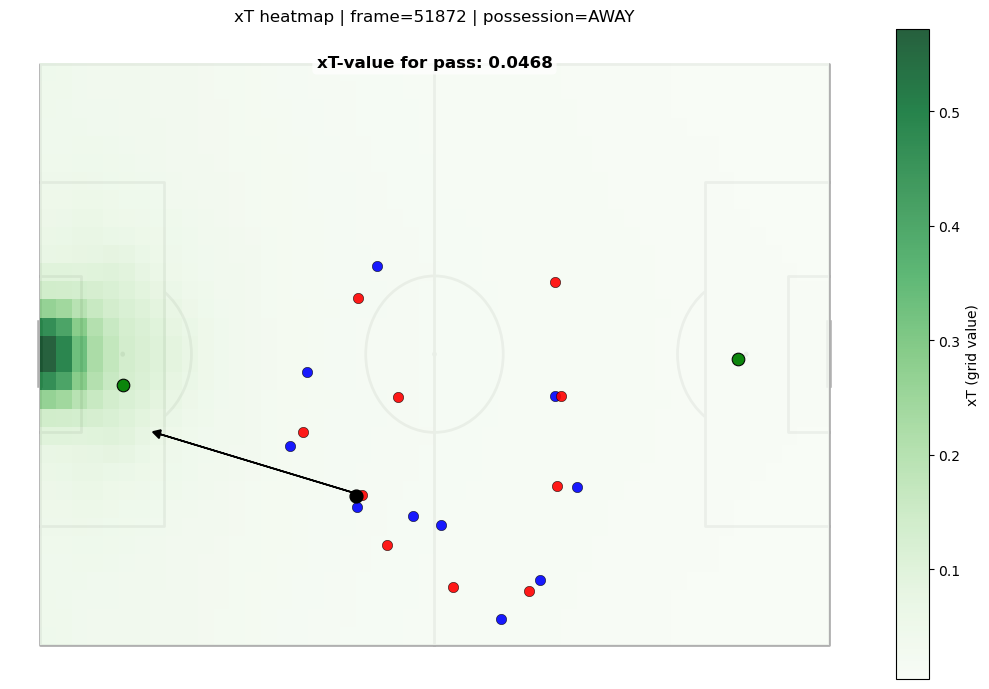

In [43]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch

# =============================================================================
# Working directory
# =============================================================================
PROJECT_ROOT: Path = Path.cwd()

# =============================================================================
# Pitch constants (SkillCorner)
# =============================================================================
PITCH_LENGTH: float = 105.0
PITCH_WIDTH: float = 68.0


# =============================================================================
# xT Grid: Load + preprocess to LTR (REUSABLE MODULE)
# =============================================================================
@dataclass(frozen=True)
class XTGridMeta:
    """Metadata for the xT grid (debug helper)."""
    source_path: str
    shape: Tuple[int, int]
    assumed_orientation: str  # "LTR"
    flipped_to_ltr: bool


def load_and_prepare_xt_grid_ltr(
    *,
    path: Path,
    assume_csv_is_ltr: bool = True,
) -> tuple[np.ndarray, XTGridMeta]:
    """
    Load xT grid from CSV and return a LEFT-TO-RIGHT (LTR) oriented grid.

    Parameters
    ----------
    path:
        Path to CSV file containing a 2D numeric grid (ny, nx).
    assume_csv_is_ltr:
        If False, the loaded grid is assumed RTL and will be flipped to LTR.

    Returns
    -------
    xT_grid_ltr:
        np.ndarray (ny, nx) representing xT when attacking LTR.
    meta:
        XTGridMeta with debug info.
    """
    path = Path(path)
    grid = np.loadtxt(path, delimiter=",")

    if grid.ndim != 2:
        raise ValueError(f"xT grid must be 2D. Got shape={grid.shape} from {path}")

    flipped_to_ltr = False
    if not assume_csv_is_ltr:
        grid = np.fliplr(grid)
        flipped_to_ltr = True

    meta = XTGridMeta(
        source_path=str(path),
        shape=(int(grid.shape[0]), int(grid.shape[1])),
        assumed_orientation="LTR",
        flipped_to_ltr=bool(flipped_to_ltr),
    )
    return grid.astype(np.float64, copy=False), meta


# =============================================================================
# Stable possession inference (same idea as your RPC/video hysteresis)
# =============================================================================
def infer_possession_team_stable(
    de_norm: pd.DataFrame,
    tracking_df: pd.DataFrame,
    *,
    frame_id: int,
    prev_team_in_possession_id: int,
    home_team_id: int,
    away_team_id: int,
    prefer_event_types: tuple[str, ...] = ("player_possession",),
    player_cols_priority: tuple[str, ...] = ("player_in_possession_id", "player_id", "player_in_possession"),
) -> tuple[int, Optional[int]]:
    """
    Stable possession inference to avoid flicker during passes.

    Rules
    -----
    1) Prefer 'player_possession' events (ignore 'ball_possession' to avoid mid-pass flips).
    2) If player in possession is found, map player_id -> team_id using tracking at this frame.
    3) If no reliable signal is found, keep previous team_in_possession_id (carry forward).

    Requirements
    ------------
    - de_norm must include: frame_start, event_type (and optionally frame_end)
    - tracking_df must include: frame, player_id, team_id
    """
    fid = int(frame_id)
    prev_team = int(prev_team_in_possession_id)

    # --- Find candidate event row(s) covering this frame ---
    if "frame_start" not in de_norm.columns or "event_type" not in de_norm.columns:
        return prev_team, None

    has_frame_end = "frame_end" in de_norm.columns

    if has_frame_end:
        candidates = de_norm.loc[(de_norm["frame_start"] <= fid) & (de_norm["frame_end"] >= fid)].copy()
    else:
        candidates = pd.DataFrame()

    if candidates.empty:
        candidates = de_norm.loc[de_norm["frame_start"] <= fid].copy()
        if candidates.empty:
            return prev_team, None

    preferred = candidates.loc[candidates["event_type"].isin(prefer_event_types)].copy()
    if preferred.empty:
        # No player_possession at this frame -> carry forward
        return prev_team, None

    # Sort so "latest" event wins
    sort_cols = ["frame_start"]
    if "index" in preferred.columns:
        sort_cols.append("index")
    preferred = preferred.sort_values(sort_cols, ascending=True)
    src = preferred.iloc[-1]

    # --- Extract player_id from event row ---
    player_id: Optional[int] = None
    for col in player_cols_priority:
        if col in src.index and pd.notna(src[col]):
            try:
                player_id = int(src[col])
            except Exception:
                player_id = None
            break

    if player_id is None:
        return prev_team, None

    # --- Map player_id -> team_id using tracking at this frame (authoritative) ---
    if not {"frame", "player_id", "team_id"}.issubset(tracking_df.columns):
        return prev_team, player_id

    team_row = tracking_df.loc[
        (tracking_df["frame"] == fid) & (tracking_df["player_id"] == int(player_id)),
        ["team_id"],
    ]
    if team_row.empty:
        return prev_team, player_id

    team_id = int(team_row["team_id"].iloc[0])
    if team_id not in {int(home_team_id), int(away_team_id)}:
        return prev_team, player_id

    return team_id, player_id


# =============================================================================
# Orientation to possession (frame-level)
# =============================================================================
def xt_grid_oriented_to_possession_attack(
    xT_grid_ltr: np.ndarray,
    *,
    possession_team_id: int,
    home_team_id: int,
) -> np.ndarray:
    """
    Coordinates normalized such that HOME attacks LTR.
    If AWAY is in possession -> flip so possession attacks LTR for plot + lookup.
    """
    grid = np.asarray(xT_grid_ltr, dtype=np.float64)
    return grid if int(possession_team_id) == int(home_team_id) else np.fliplr(grid)


def get_xT_at_location_from_grid(
    x: float,
    y: float,
    *,
    xT_grid_oriented: np.ndarray,
    pitch_length: float = PITCH_LENGTH,
    pitch_width: float = PITCH_WIDTH,
) -> float:
    """Map (x,y) SkillCorner coords -> xT value from an oriented grid."""
    x = float(x)
    y = float(y)

    if abs(x) > pitch_length / 2.0 or abs(y) > pitch_width / 2.0:
        return 0.0

    grid = np.asarray(xT_grid_oriented, dtype=np.float64)
    ny, nx = grid.shape

    dx = pitch_length / float(nx)
    dy = pitch_width / float(ny)

    ix = int((x + pitch_length / 2.0 - 1e-6) / dx)
    iy = int((y + pitch_width / 2.0 - 1e-6) / dy)

    ix = max(0, min(nx - 1, ix))
    iy = max(0, min(ny - 1, iy))

    return float(grid[iy, ix])


# =============================================================================
# Plot helpers
# =============================================================================
def _plot_base_frame_with_xt(
    *,
    frame_id: int,
    tracking_df: pd.DataFrame,
    xt_plot: np.ndarray,
    team_colors: Dict[int, str],
    gk_color: str,
    alpha: float,
    player_size: float,
    ball_size: float,
    show_colorbar: bool,
    vmin: float,
    vmax: float,
    title: str,
) -> tuple[plt.Figure, plt.Axes]:
    """Draw pitch + xT heatmap + players + ball."""
    fid = int(frame_id)

    frame_df = tracking_df.loc[tracking_df["frame"].eq(fid)].copy()
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={fid}.")

    pitch = Pitch(pitch_type="skillcorner", pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH)
    fig, ax = pitch.draw(figsize=(10, 7))

    extent = [-PITCH_LENGTH / 2.0, PITCH_LENGTH / 2.0, -PITCH_WIDTH / 2.0, PITCH_WIDTH / 2.0]

    im = ax.imshow(
        np.asarray(xt_plot, dtype=np.float64),
        origin="lower",
        extent=extent,
        aspect="auto",
        cmap="Greens",
        alpha=float(alpha),
        vmin=float(vmin),
        vmax=float(vmax),
        zorder=1,
        interpolation="nearest",
    )
    if show_colorbar:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="xT (grid value)")

    # Ensure GK flag exists
    if "is_gk" not in frame_df.columns:
        frame_df["is_gk"] = False

    # Players
    for tid, color in team_colors.items():
        team_rows = frame_df.loc[frame_df["team_id"].eq(int(tid))]
        if team_rows.empty:
            continue

        outfield = team_rows.loc[~team_rows["is_gk"]]
        gks = team_rows.loc[team_rows["is_gk"]]

        if not outfield.empty:
            ax.scatter(
                outfield["x"],
                outfield["y"],
                s=float(player_size),
                color=str(color),
                edgecolors="black",
                linewidth=0.4,
                alpha=0.90,
                zorder=5,
            )
        if not gks.empty:
            ax.scatter(
                gks["x"],
                gks["y"],
                s=float(player_size) * 1.5,
                color=str(gk_color),
                edgecolors="black",
                linewidth=0.8,
                alpha=0.95,
                zorder=6,
            )

    # Ball
    ax.scatter(
        float(frame_df["ball_x"].iloc[0]),
        float(frame_df["ball_y"].iloc[0]),
        s=float(ball_size),
        color="black",
        zorder=7,
    )

    ax.set_title(title)
    return fig, ax


def _maybe_save_fig(
    fig: plt.Figure,
    *,
    SAVE: bool,
    save_path: Optional[Path],
    WORKING_DIR: Path,
    subdir: str,
    filename: str,
    dpi: int,
) -> Optional[Path]:
    """Save helper (optional)."""
    if not SAVE:
        return None

    WORKING_DIR = Path(WORKING_DIR)
    if save_path is None:
        out_dir = WORKING_DIR / "viz" / subdir
        out_dir.mkdir(parents=True, exist_ok=True)
        save_path = out_dir / filename

    fig.savefig(save_path, dpi=int(dpi), bbox_inches="tight")
    print("Saved:", save_path)
    return save_path


# =============================================================================
# Public: xT plotting for a frame (stable possession)
# =============================================================================
def plot_frame_xt(
    *,
    frame_id: int,
    enriched_tracking_norm: pd.DataFrame,
    de_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    xT_grid_ltr: np.ndarray,
    team_colors: Dict[int, str],
    gk_color: str,
    # Stable possession state (optional, but recommended if you call this in a loop/video)
    prev_team_in_possession_id: Optional[int] = None,
    # Viz options
    alpha: float = 0.85,
    player_size: float = 55,
    ball_size: float = 85,
    show_colorbar: bool = True,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    # Pass options
    show_pass: bool = False,
    pass_start: Tuple[float, float] = (0.0, 0.0),
    pass_end: Tuple[float, float] = (0.0, 0.0),
    arrow_lw: float = 1.2,
    arrow_headwidth: float = 1.0,
    arrow_headlength: float = 1.0,
    # Saving
    SAVE: bool = False,
    save_path: Optional[Path] = None,
    dpi: int = 200,
    WORKING_DIR: Path = PROJECT_ROOT,
) -> tuple[plt.Figure, plt.Axes, Optional[float], int]:
    """
    Plot xT heatmap for a frame using stable possession inference.

    Stable possession (“hysteresis”)
    --------------------------------
    - Prefer 'player_possession' events.
    - Map player_id -> team_id via tracking at this frame.
    - If no reliable signal -> keep previous team (carry forward).

    Returns
    -------
    fig, ax, xT_value_or_None, team_in_possession_id
    """
    fid = int(frame_id)

    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.loc[0, "home_team.id"])
    away_team_id = int(match_meta_df.loc[0, "away_team.id"])

    # Initialize stable state if not provided
    prev_team = int(prev_team_in_possession_id) if prev_team_in_possession_id is not None else int(home_team_id)

    team_in_possession_id, _player_id = infer_possession_team_stable(
        de_norm,
        enriched_tracking_norm,
        frame_id=fid,
        prev_team_in_possession_id=prev_team,
        home_team_id=home_team_id,
        away_team_id=away_team_id,
    )

    xt_plot = xt_grid_oriented_to_possession_attack(
        xT_grid_ltr,
        possession_team_id=int(team_in_possession_id),
        home_team_id=int(home_team_id),
    )

    vmin_use = float(np.min(xT_grid_ltr)) if vmin is None else float(vmin)
    vmax_use = float(np.max(xT_grid_ltr)) if vmax is None else float(vmax)

    poss_txt = "HOME" if int(team_in_possession_id) == int(home_team_id) else "AWAY"
    title = f"xT heatmap | frame={fid} | possession={poss_txt}"

    fig, ax = _plot_base_frame_with_xt(
        frame_id=fid,
        tracking_df=enriched_tracking_norm,
        xt_plot=xt_plot,
        team_colors=team_colors,
        gk_color=str(gk_color),
        alpha=float(alpha),
        player_size=float(player_size),
        ball_size=float(ball_size),
        show_colorbar=bool(show_colorbar),
        vmin=float(vmin_use),
        vmax=float(vmax_use),
        title=title,
    )

    xT_value: Optional[float] = None
    if show_pass:
        sx, sy = float(pass_start[0]), float(pass_start[1])
        ex, ey = float(pass_end[0]), float(pass_end[1])

        xT_start = get_xT_at_location_from_grid(sx, sy, xT_grid_oriented=xt_plot)
        xT_end = get_xT_at_location_from_grid(ex, ey, xT_grid_oriented=xt_plot)
        xT_value = float(xT_end - xT_start)

        ax.arrow(
            sx,
            sy,
            ex - sx,
            ey - sy,
            length_includes_head=True,
            head_width=float(arrow_headwidth),
            head_length=float(arrow_headlength),
            linewidth=float(arrow_lw),
            color="black",
            zorder=10,
        )

        ax.text(
            0.5,
            0.96,
            f"xT-value for pass: {xT_value:.4f}",
            transform=ax.transAxes,
            ha="center",
            va="top",
            fontsize=12,
            color="black",
            fontweight="bold",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.25"),
            zorder=11,
        )

    fname = f"xt_frame_{fid}.png" if not show_pass else f"xt_frame_{fid}_pass.png"
    _maybe_save_fig(
        fig,
        SAVE=bool(SAVE),
        save_path=save_path,
        WORKING_DIR=Path(WORKING_DIR),
        subdir="xt",
        filename=fname,
        dpi=int(dpi),
    )

    return fig, ax, xT_value, int(team_in_possession_id)


# =============================================================================
# Example usage
# =============================================================================
if __name__ == "__main__":
    # Assumes these are defined earlier in your notebook/script:
    # HOME_TEAM_ID, AWAY_TEAM_ID, TEAM_COLORS, GK_COLOR

    xT_grid_path = PROJECT_ROOT / "data" / "EPV_grid.csv"
    xT_grid_ltr, xT_meta = load_and_prepare_xt_grid_ltr(path=xT_grid_path, assume_csv_is_ltr=True)
    print("Loaded xT_grid_ltr:", xT_meta)

    # Stable state example (carry forward)
    prev_poss_team = HOME_TEAM_ID

    fig, ax, xT_val, prev_poss_team = plot_frame_xt(
        frame_id=int(row["pass_moment_frame"]),
        enriched_tracking_norm=enriched_tracking_norm,
        de_norm=de_norm,
        match_meta_df=match_meta_df,
        xT_grid_ltr=xT_grid_ltr,
        team_colors=TEAM_COLORS,
        gk_color=GK_COLOR,
        prev_team_in_possession_id=prev_poss_team,
        show_pass=True,
        pass_start=(float(row["pass_x_start"]), float(row["pass_y_start"])),
        pass_end=(float(row["pass_x_end"]), float(row["pass_y_end"])),
        SAVE=True,
        WORKING_DIR=PROJECT_ROOT,
    )
    plt.show()


Saved RSV plot: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\rsv\RSV_added_match__rsv_1899585_frame_51872_grid100.png


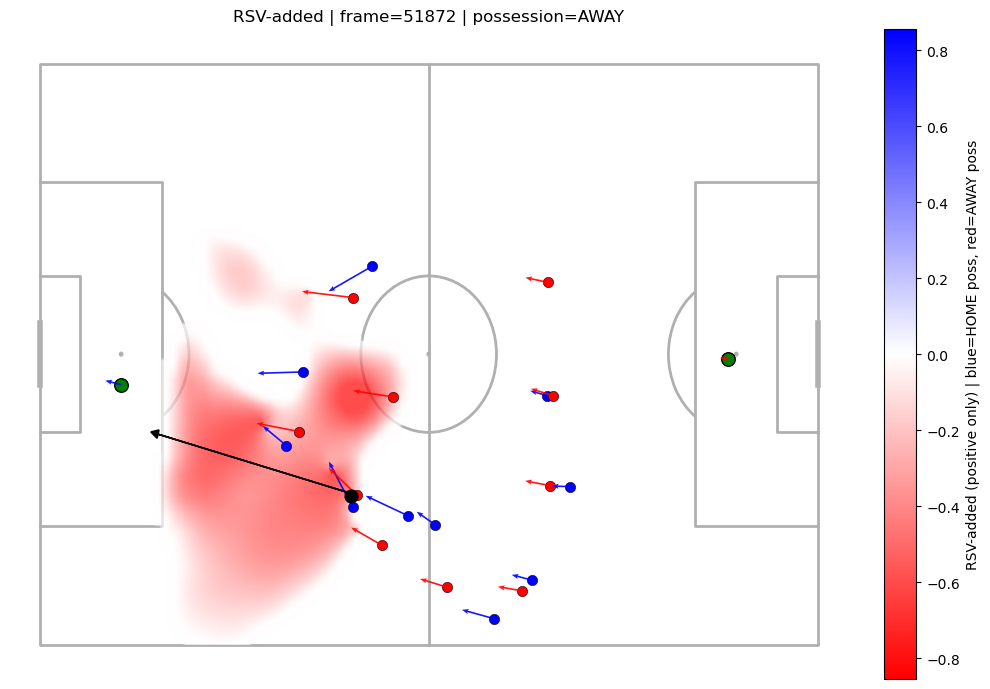

In [45]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch

# Optional plot-smoothing (plot-only)
try:
    from scipy.ndimage import gaussian_filter  # type: ignore
    _HAS_SCIPY = True
except Exception:
    gaussian_filter = None  # type: ignore
    _HAS_SCIPY = False


# =============================================================================
# Working directory (base for saving)
# =============================================================================
WORKING_DIR: Path = Path.cwd()
PROJECT_ROOT: Path = WORKING_DIR  # alias if you prefer this name


# =============================================================================
# Pitch constants (SkillCorner)
# =============================================================================
PITCH_LENGTH: float = 105.0
PITCH_WIDTH: float = 68.0
FPS_IN: int = 10


# =============================================================================
# Utilities
# =============================================================================
def _safe_filename(text: str) -> str:
    """Return a filesystem-safe filename stem (very simple sanitizer)."""
    keep: list[str] = []
    for ch in str(text):
        if ch.isalnum() or ch in ("-", "_"):
            keep.append(ch)
        elif ch.isspace():
            keep.append("_")
    out = "".join(keep).strip("_")
    return out or "plot"


def draw_pass_arrow(
    ax: plt.Axes,
    *,
    pass_start: Tuple[float, float],
    pass_end: Tuple[float, float],
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    pass_zorder: int = 12,
) -> None:
    """
    Draw a pass arrow on an existing axis.

    Parameters
    ----------
    ax:
        Matplotlib axis to draw onto.
    pass_start, pass_end:
        (x,y) coordinates for start/end in SkillCorner pitch coordinates.
    """
    sx, sy = float(pass_start[0]), float(pass_start[1])
    ex, ey = float(pass_end[0]), float(pass_end[1])

    ax.arrow(
        sx,
        sy,
        ex - sx,
        ey - sy,
        length_includes_head=True,
        head_width=float(pass_headwidth),
        head_length=float(pass_headlength),
        linewidth=float(pass_lw),
        color=str(pass_color),
        alpha=float(pass_alpha),
        zorder=int(pass_zorder),
    )


def bilinear_resample_grid(
    src_grid: np.ndarray,
    *,
    src_x: np.ndarray,
    src_y: np.ndarray,
    dst_x: np.ndarray,
    dst_y: np.ndarray,
) -> np.ndarray:
    """
    Resample a 2D grid from (src_y, src_x) -> (dst_y, dst_x) using separable 1D interpolation.

    Notes
    -----
    - Pure numerical interpolation (fast).
    - Suitable for aligning xT-grid to RPC-grid.
    """
    src_grid = np.asarray(src_grid, dtype=np.float64)
    src_x = np.asarray(src_x, dtype=np.float64)
    src_y = np.asarray(src_y, dtype=np.float64)
    dst_x = np.asarray(dst_x, dtype=np.float64)
    dst_y = np.asarray(dst_y, dtype=np.float64)

    # Interpolate along x for each y
    inter_x = np.empty((src_grid.shape[0], dst_x.shape[0]), dtype=np.float64)
    for iy in range(src_grid.shape[0]):
        inter_x[iy, :] = np.interp(dst_x, src_x, src_grid[iy, :])

    # Interpolate along y for each x
    out = np.empty((dst_y.shape[0], dst_x.shape[0]), dtype=np.float64)
    for ix in range(inter_x.shape[1]):
        out[:, ix] = np.interp(dst_y, src_y, inter_x[:, ix])

    return out


def get_grid_value_at_xy(
    x: float,
    y: float,
    *,
    grid: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
) -> float:
    """
    Nearest-cell lookup: map (x,y) -> value from grid[y_idx, x_idx].

    Parameters
    ----------
    x, y:
        Location in SkillCorner coordinates.
    grid:
        2D grid indexed as [y_idx, x_idx].
    x_grid, y_grid:
        1D coordinate axes for the grid.
    """
    x = float(x)
    y = float(y)
    x_grid = np.asarray(x_grid, dtype=np.float64)
    y_grid = np.asarray(y_grid, dtype=np.float64)
    grid = np.asarray(grid, dtype=np.float64)

    ix = int(np.argmin(np.abs(x_grid - x)))
    iy = int(np.argmin(np.abs(y_grid - y)))

    ix = max(0, min(grid.shape[1] - 1, ix))
    iy = max(0, min(grid.shape[0] - 1, iy))

    return float(grid[iy, ix])


# =============================================================================
# External dependencies expected in your environment (from your other modules)
# =============================================================================
# REQUIRED to be available in the notebook/session:
# - get_player_in_possession_at_frame
# - compute_pitch_control_grid
# - to_possession_control_grid
# - xt_grid_oriented_to_possession_attack
#
# OPTIONAL but recommended:
# - add_player_velocity (if your RPC/facing/movement depends on velocities)


# =============================================================================
# RPC (UPDATED): pc_gamma removed, tau_seconds set to 2.3
# =============================================================================
@dataclass(frozen=True)
class RPCParams:
    """
    Parameters for Relevant Pitch Control (RPC).

    Model
    -----
    RPC(x,y) = PC_poss(x,y) * exp( -t_ball(x,y) / tau ) * w_face(x,y)  (optional)

    Notes
    -----
    - pc_gamma has been removed: no exponentiation/sharpening of PC_poss.
    """
    ball_speed_mps: float = 15.0
    tau_seconds: float = 2.3  # UPDATED (was 2.0 in your example)

    # Facing (optional)
    use_facing: bool = False
    facing_strength: float = 0.8
    facing_gamma: float = 0.5
    facing_min_speed: float = 0.1


def compute_rpc_grid(
    *,
    pc_poss: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    enriched_tracking_norm: pd.DataFrame,
    frame_id: int,
    params: RPCParams,
    player_in_possession_id: Optional[int] = None,
) -> np.ndarray:
    """
    Compute RPC in [0,1].

    Model
    -----
    RPC(x,y) = PC_poss(x,y) * exp( -t_ball(x,y) / tau ) * (optional facing)

    """
    fid = int(frame_id)
    frame_df = enriched_tracking_norm.loc[enriched_tracking_norm["frame"] == fid]
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={fid}")

    bx = float(frame_df["ball_x"].iloc[0])
    by = float(frame_df["ball_y"].iloc[0])

    x_grid = np.asarray(x_grid, dtype=np.float64)
    y_grid = np.asarray(y_grid, dtype=np.float64)
    pc_poss = np.asarray(pc_poss, dtype=np.float64)

    X, Y = np.meshgrid(x_grid, y_grid)
    dist = np.sqrt((X - bx) ** 2 + (Y - by) ** 2)

    t_ball = dist / max(float(params.ball_speed_mps), 1e-6)
    w_ball = np.exp(-t_ball / max(float(params.tau_seconds), 1e-6))

    rpc = np.clip(pc_poss, 0.0, 1.0) * w_ball

    # Optional facing
    if params.use_facing:
        needed = {"vx", "vy", "x", "y", "player_id"}
        if player_in_possession_id is None or not needed.issubset(frame_df.columns):
            return np.clip(rpc, 0.0, 1.0)

        p = frame_df.loc[frame_df["player_id"] == int(player_in_possession_id)]
        if p.empty:
            return np.clip(rpc, 0.0, 1.0)

        px = float(p["x"].iloc[0])
        py = float(p["y"].iloc[0])
        vx = float(p["vx"].iloc[0])
        vy = float(p["vy"].iloc[0])

        spd = float(np.hypot(vx, vy))
        if spd < float(params.facing_min_speed):
            return np.clip(rpc, 0.0, 1.0)

        facing_angle = float(np.arctan2(vy, vx))
        theta_to = np.arctan2(Y - py, X - px)

        delta = theta_to - facing_angle
        delta = (delta + np.pi) % (2 * np.pi) - np.pi

        w_raw = (1.0 + np.cos(delta)) / 2.0
        w_raw = np.clip(w_raw, 0.0, 1.0)

        alpha_ = float(np.clip(params.facing_strength, 0.0, 1.0))
        gamma = max(float(params.facing_gamma), 1e-6)
        w_face = (1.0 - alpha_) + alpha_ * (w_raw ** gamma)

        rpc = rpc * w_face

    return np.clip(rpc, 0.0, 1.0)


# =============================================================================
# Stable possession (unchanged)
# =============================================================================
def infer_possession_team_stable(
    de_norm: pd.DataFrame,
    tracking: pd.DataFrame,
    *,
    frame_id: int,
    prev_team_in_possession_id: int,
    home_team_id: int,
    away_team_id: int,
) -> tuple[int, Optional[int]]:
    """
    Stable possession inference to avoid flicker during passes.

    Rules
    -----
    1) Prefer explicit 'player_possession' events (ignore 'ball_possession' to avoid mid-pass flips).
    2) If a player in possession is found, map that player -> team via tracking at this frame.
    3) If no reliable signal is found, keep previous team_in_possession_id.

    Returns
    -------
    (team_in_possession_id, player_in_possession_id_or_None)
    """
    fid = int(frame_id)
    prev_team = int(prev_team_in_possession_id)

    # 1) Get player in possession from events (ONLY player_possession)
    player_id = get_player_in_possession_at_frame(
        de_norm,
        frame_id=fid,
        prefer_event_types=("player_possession",),
    )

    if player_id is not None:
        # 2) Map player -> team at this frame using tracking
        team_row = tracking.loc[
            (tracking["frame"] == fid) & (tracking["player_id"] == int(player_id)),
            ["team_id"],
        ]
        if not team_row.empty:
            team_id = int(team_row["team_id"].iloc[0])
            if team_id in {int(home_team_id), int(away_team_id)}:
                return team_id, int(player_id)

    # 3) Fallback: keep previous possession team
    return prev_team, (int(player_id) if player_id is not None else None)


# =============================================================================
# RSV
# =============================================================================
@dataclass(frozen=True)
class RSVParams:
    """
    RSV model parameters.

    Model
    -----
    RSV(x,y) = RPC(x,y) * xT(x,y)

    Notes
    -----
    - xT is oriented so that the possession team attacks LTR at the frame.
    - xT is resampled to match the RPC grid resolution before multiplication.

    IMPORTANT
    ---------
    Parameters in this class are plotting-only (they do NOT change model outputs),
    except for the conceptual definition of RSV itself which is fixed above.
    """

    # Plot-only knobs (do NOT change model outputs)
    use_log: bool = True
    eps: float = 1e-10
    scale_percentile: float = 90.0
    vlim_percentile: float = 99.0
    upsample: int = 4
    apply_gaussian_blur: bool = True
    gaussian_sigma: float = 0.8
    imshow_interpolation: str = "bicubic"


def resample_xt_to_rpc_grid(
    xT_plot: np.ndarray,
    *,
    rpc_x_grid: np.ndarray,
    rpc_y_grid: np.ndarray,
    pitch_length: float = PITCH_LENGTH,
    pitch_width: float = PITCH_WIDTH,
) -> np.ndarray:
    """
    Resample oriented xT grid (ny,nx) to match RPC grid axes (rpc_y_grid, rpc_x_grid).

    Requirements
    ------------
    - xT_plot spans the full pitch extents evenly.
    - rpc_x_grid and rpc_y_grid correspond to the RPC/PC grid axes.
    """
    xT_plot = np.asarray(xT_plot, dtype=np.float64)
    ny, nx = xT_plot.shape

    # xT grid assumed to span full pitch extents evenly
    src_x = np.linspace(-pitch_length / 2.0, pitch_length / 2.0, nx, dtype=np.float64)
    src_y = np.linspace(-pitch_width / 2.0, pitch_width / 2.0, ny, dtype=np.float64)

    xT_on_rpc = bilinear_resample_grid(
        xT_plot,
        src_x=src_x,
        src_y=src_y,
        dst_x=np.asarray(rpc_x_grid, dtype=np.float64),
        dst_y=np.asarray(rpc_y_grid, dtype=np.float64),
    )
    return xT_on_rpc


def compute_rsv_grid(
    *,
    rpc_grid: np.ndarray,
    xT_on_rpc_grid: np.ndarray,
) -> np.ndarray:
    """
    Compute RSV grid on the RPC grid resolution.

    RSV(x,y) = RPC(x,y) * xT(x,y)

    Requirements
    ------------
    - rpc_grid and xT_on_rpc_grid must have the same shape.
    """
    rpc_grid = np.asarray(rpc_grid, dtype=np.float64)
    xT_on_rpc_grid = np.asarray(xT_on_rpc_grid, dtype=np.float64)

    if rpc_grid.shape != xT_on_rpc_grid.shape:
        raise ValueError(
            f"Shape mismatch: rpc_grid={rpc_grid.shape} vs xT_on_rpc_grid={xT_on_rpc_grid.shape}. "
            "Resample xT to RPC grid first."
        )

    return np.clip(rpc_grid, 0.0, 1.0) * np.clip(xT_on_rpc_grid, 0.0, np.inf)


def compute_rsv_added_from_ball(
    *,
    rsv_grid: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    ball_x: float,
    ball_y: float,
) -> Tuple[np.ndarray, float]:
    """
    Compute RSV-added surface relative to current ball location.

    Definition
    ----------
    RSV_added(x,y) = RSV(x,y) - RSV(ball_location)

    Returns
    -------
    rsv_added_grid:
        np.ndarray same shape as rsv_grid
    rsv_ball:
        float RSV value at current ball location
    """
    rsv_ball = get_grid_value_at_xy(
        float(ball_x),
        float(ball_y),
        grid=rsv_grid,
        x_grid=x_grid,
        y_grid=y_grid,
    )
    rsv_added = np.asarray(rsv_grid, dtype=np.float64) - float(rsv_ball)
    return rsv_added, float(rsv_ball)


# =============================================================================
# Plot: positive RSV-added only, sign encodes possession team (HOME blue / AWAY red)
# =============================================================================
def plot_rsv_added_pos_only_colored_by_possession(
    *,
    rsv_added_grid: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    frame_df: pd.DataFrame,
    team_colors: Dict[int, str],
    team_in_possession_id: int,
    home_team_id: int,
    gk_color: str,
    title: str,
    params: Optional[RSVParams] = None,
    heatmap_alpha: float = 0.70,
    player_size: float = 55,
    gk_size: float = 95,
    ball_size: float = 85,
    cmap: str = "bwr_r",
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.5,
    # Pass arrow
    show_pass: bool = False,
    pass_start: Optional[Tuple[float, float]] = None,
    pass_end: Optional[Tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    # Fixed color scale (useful for videos)
    fixed_vlim: Optional[float] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot only positive RSV-added values.
    Color encodes possession:
      - HOME possession -> shown as BLUE
      - AWAY possession -> shown as RED

    How it works
    ------------
    - rsv_pos = max(RSV_added, 0)
    - (optional) log1p compression for visualization
    - encode possession team as sign (+ for HOME, - for AWAY)
    - alpha fades near zero to whiten noise
    """
    if params is None:
        params = RSVParams()

    pitch = Pitch(pitch_type="skillcorner", pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH)
    fig, ax = pitch.draw(figsize=(10, 7))

    rsv_added_grid = np.asarray(rsv_added_grid, dtype=np.float64)
    x_grid = np.asarray(x_grid, dtype=np.float64)
    y_grid = np.asarray(y_grid, dtype=np.float64)

    # Keep only positive improvements
    rsv_pos = np.maximum(rsv_added_grid, 0.0)

    # Visibility scaling (plotting only)
    pos_vals = rsv_pos[rsv_pos > float(params.eps)]
    scale = float(np.nanpercentile(pos_vals, float(params.scale_percentile))) if pos_vals.size else 1.0
    scale = max(scale, 1e-12)

    # Range compression (plotting only)
    rsv_plot = np.log1p(rsv_pos / scale) if bool(params.use_log) else rsv_pos

    # Encode possession as sign
    sign = +1.0 if int(team_in_possession_id) == int(home_team_id) else -1.0
    signed_plot = sign * rsv_plot

    # Optional upsample (plotting only)
    if params.upsample and int(params.upsample) > 1:
        dst_ny = int(signed_plot.shape[0] * int(params.upsample))
        dst_nx = int(signed_plot.shape[1] * int(params.upsample))
        dst_x = np.linspace(x_grid.min(), x_grid.max(), dst_nx, dtype=np.float64)
        dst_y = np.linspace(y_grid.min(), y_grid.max(), dst_ny, dtype=np.float64)

        signed_plot = bilinear_resample_grid(
            signed_plot,
            src_x=x_grid,
            src_y=y_grid,
            dst_x=dst_x,
            dst_y=dst_y,
        )
        x_plot, y_plot = dst_x, dst_y
    else:
        x_plot, y_plot = x_grid, y_grid

    extent = [x_plot.min(), x_plot.max(), y_plot.min(), y_plot.max()]

    # Optional blur (plotting only)
    signed_vis = signed_plot
    if bool(params.apply_gaussian_blur) and _HAS_SCIPY and gaussian_filter is not None:
        signed_vis = gaussian_filter(signed_vis, sigma=float(params.gaussian_sigma))

    # Soft fade to white near zero
    val = np.abs(signed_vis)
    alpha_map = (
        np.clip((val - float(params.eps)) / max(6.0 * float(params.eps), 1e-12), 0.0, 1.0)
        * float(heatmap_alpha)
    )

    # Color scale
    if fixed_vlim is not None:
        vlim = float(fixed_vlim)
    else:
        plot_vals = np.abs(signed_vis[np.abs(signed_vis) > float(params.eps)])
        vlim = float(np.nanpercentile(plot_vals, float(params.vlim_percentile))) if plot_vals.size else 1.0
    vlim = max(vlim, 1e-12)

    im = ax.imshow(
        signed_vis,
        origin="lower",
        extent=extent,
        aspect="auto",
        cmap=str(cmap),
        vmin=-vlim,
        vmax=+vlim,
        alpha=alpha_map,
        zorder=1,
        interpolation=str(params.imshow_interpolation),
    )
    plt.colorbar(
        im,
        ax=ax,
        fraction=0.046,
        pad=0.04,
        label="RSV-added (positive only) | blue=HOME poss, red=AWAY poss",
    )

    # Players + GK + optional movement
    if "is_gk" not in frame_df.columns:
        frame_df = frame_df.copy()
        frame_df["is_gk"] = False

    if show_movement:
        needed = {"vx", "vy", "speed"}
        miss = needed.difference(frame_df.columns)
        if miss:
            raise KeyError(f"show_movement=True requires {sorted(needed)} in frame_df.")

    for team_id, color in team_colors.items():
        team_rows = frame_df.loc[frame_df["team_id"] == int(team_id)]
        if team_rows.empty:
            continue

        outfield = team_rows.loc[~team_rows["is_gk"]]
        gks = team_rows.loc[team_rows["is_gk"]]

        if not outfield.empty:
            ax.scatter(
                outfield["x"],
                outfield["y"],
                s=float(player_size),
                color=str(color),
                edgecolors="black",
                linewidth=0.4,
                zorder=5,
            )

        if not gks.empty:
            ax.scatter(
                gks["x"],
                gks["y"],
                s=float(gk_size),
                color=str(gk_color),
                edgecolors="black",
                linewidth=1.0,
                zorder=6,
            )

        if show_movement:
            moving = team_rows.loc[team_rows["speed"].astype(float) >= float(movement_min_speed)]
            if not moving.empty:
                ax.quiver(
                    moving["x"].astype(float).to_numpy(),
                    moving["y"].astype(float).to_numpy(),
                    (moving["vx"].astype(float).to_numpy() * float(movement_scale)),
                    (moving["vy"].astype(float).to_numpy() * float(movement_scale)),
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    width=0.002,
                    headwidth=3,
                    headlength=4,
                    headaxislength=3.5,
                    color=str(color),
                    alpha=0.9,
                    zorder=8,
                )

    # Ball
    if {"ball_x", "ball_y"}.issubset(frame_df.columns) and not frame_df.empty:
        ax.scatter(
            float(frame_df["ball_x"].iloc[0]),
            float(frame_df["ball_y"].iloc[0]),
            s=float(ball_size),
            color="black",
            zorder=10,
        )

    # Pass arrow
    if bool(show_pass):
        if pass_start is None or pass_end is None:
            raise ValueError("show_pass=True requires pass_start and pass_end.")
        draw_pass_arrow(
            ax,
            pass_start=pass_start,
            pass_end=pass_end,
            pass_color=str(pass_color),
            pass_lw=float(pass_lw),
            pass_headwidth=float(pass_headwidth),
            pass_headlength=float(pass_headlength),
            pass_alpha=float(pass_alpha),
            pass_zorder=12,
        )

    ax.set_title(title)
    return fig, ax


# =============================================================================
# Runner: compute RSV + RSV-added for a frame using RPC + xT
# =============================================================================
def WORKING_DIR_GLOBAL() -> Path:
    """Return the global working directory."""
    return WORKING_DIR


def run_rsv_frame(
    *,
    frame_id: int,
    enriched_tracking_norm: pd.DataFrame,
    de_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    # xT
    xT_grid_ltr: np.ndarray,
    # colors
    team_colors: Dict[int, str],
    gk_color: str,
    # stable possession
    prev_team_in_possession_id: Optional[int] = None,
    # PC/RPC configs
    pc_grid_n: int = 100,
    pc_params: Any = None,   # PitchControlParams (from your PC module)
    rpc_params: Optional[RPCParams] = None,
    # RSV params (plot-only)
    rsv_params: RSVParams = RSVParams(),
    # plot toggles
    PLOT: bool = True,
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.5,
    # pass
    show_pass: bool = False,
    pass_start: Optional[Tuple[float, float]] = None,
    pass_end: Optional[Tuple[float, float]] = None,
    pass_color: str = "black",
    pass_lw: float = 1.2,
    pass_headwidth: float = 1.0,
    pass_headlength: float = 1.0,
    pass_alpha: float = 0.95,
    # saving
    SAVE: bool = False,
    WORKING_DIR: Optional[Path] = None,
    save_prefix: Optional[str] = None,
    dpi: int = 200,
    SHOW: bool = True,
    # fixed scale (optional for consistent videos)
    fixed_vlim: Optional[float] = None,
) -> Dict[str, Any]:
    """
    Compute RSV + RSV-added for a single frame.

    Requirements
    ------------
    - match_meta_df must contain a single row with: 'home_team.id', 'away_team.id'
    - enriched_tracking_norm must contain at least: frame, team_id, x, y, ball_x, ball_y
    - External functions must exist in environment:
        compute_pitch_control_grid, to_possession_control_grid, xt_grid_oriented_to_possession_attack
    """
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])
    fid = int(frame_id)

    # Working directory for saving
    base_dir = Path(WORKING_DIR) if WORKING_DIR is not None else WORKING_DIR_GLOBAL()

    # Possession carry-forward seed
    prev_team = int(prev_team_in_possession_id) if prev_team_in_possession_id is not None else int(home_team_id)

    if pc_params is None:
        raise ValueError("pc_params must be provided (PitchControlParams from your PC module).")
    if rpc_params is None:
        rpc_params = RPCParams()  # default tau=2.3, pc_gamma removed

    frame_df = enriched_tracking_norm.loc[enriched_tracking_norm["frame"] == fid].copy()
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={fid}")

    ball_x = float(frame_df["ball_x"].iloc[0])
    ball_y = float(frame_df["ball_y"].iloc[0])

    # 1) Stable possession
    team_in_possession_id, player_in_possession_id = infer_possession_team_stable(
        de_norm,
        enriched_tracking_norm,
        frame_id=fid,
        prev_team_in_possession_id=int(prev_team),
        home_team_id=home_team_id,
        away_team_id=away_team_id,
    )

    # 2) PC -> possession control -> RPC
    pc_home_grid, x_grid, y_grid, pc_meta = compute_pitch_control_grid(  # type: ignore[name-defined]
        enriched_tracking_norm,
        frame_id=fid,
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        grid_n=int(pc_grid_n),
        params=pc_params,
        ensure_velocity=True,
    )

    pc_poss = to_possession_control_grid(  # type: ignore[name-defined]
        pc_home_grid,
        team_in_possession_id=int(team_in_possession_id),
        home_team_id=int(home_team_id),
    )

    # Only pass player_id if facing enabled
    player_for_rpc = int(player_in_possession_id) if (rpc_params.use_facing and player_in_possession_id is not None) else None

    rpc_grid = compute_rpc_grid(
        pc_poss=pc_poss,
        x_grid=x_grid,
        y_grid=y_grid,
        enriched_tracking_norm=enriched_tracking_norm,
        frame_id=fid,
        params=rpc_params,
        player_in_possession_id=player_for_rpc,
    )

    # 3) xT oriented to possession
    xT_plot = xt_grid_oriented_to_possession_attack(  # type: ignore[name-defined]
        xT_grid_ltr,
        possession_team_id=int(team_in_possession_id),
        home_team_id=int(home_team_id),
    )

    # 4) Resample xT -> RPC grid
    xT_on_rpc = resample_xt_to_rpc_grid(
        xT_plot,
        rpc_x_grid=x_grid,
        rpc_y_grid=y_grid,
        pitch_length=PITCH_LENGTH,
        pitch_width=PITCH_WIDTH,
    )

    # 5) RSV and RSV-added
    rsv_grid = compute_rsv_grid(rpc_grid=rpc_grid, xT_on_rpc_grid=xT_on_rpc)
    rsv_added_grid, rsv_ball = compute_rsv_added_from_ball(
        rsv_grid=rsv_grid,
        x_grid=x_grid,
        y_grid=y_grid,
        ball_x=ball_x,
        ball_y=ball_y,
    )

    out_path: Optional[Path] = None

    if PLOT:
        poss_txt = "HOME" if int(team_in_possession_id) == int(home_team_id) else "AWAY"
        title = f"RSV-added | frame={fid} | possession={poss_txt}"

        fig, _ax = plot_rsv_added_pos_only_colored_by_possession(
            rsv_added_grid=rsv_added_grid,
            x_grid=x_grid,
            y_grid=y_grid,
            frame_df=frame_df,
            team_colors=team_colors,
            team_in_possession_id=int(team_in_possession_id),
            home_team_id=int(home_team_id),
            gk_color=str(gk_color),
            title=title,
            params=rsv_params,
            show_movement=bool(show_movement),
            movement_scale=float(movement_scale),
            movement_min_speed=float(movement_min_speed),
            show_pass=bool(show_pass),
            pass_start=pass_start,
            pass_end=pass_end,
            pass_color=str(pass_color),
            pass_lw=float(pass_lw),
            pass_headwidth=float(pass_headwidth),
            pass_headlength=float(pass_headlength),
            pass_alpha=float(pass_alpha),
            fixed_vlim=fixed_vlim,
        )

        if SAVE:
            out_dir = base_dir / "viz" / "rsv"
            out_dir.mkdir(parents=True, exist_ok=True)

            prefix = save_prefix or "plot"
            filename_stem = _safe_filename(f"RSV_added_{prefix}_frame_{fid}_grid{int(pc_grid_n)}")
            out_path = out_dir / f"{filename_stem}.png"

            fig.savefig(out_path, dpi=int(dpi), bbox_inches="tight")
            print(f"Saved RSV plot: {out_path}")

        if SHOW:
            plt.show()
        else:
            plt.close(fig)

    return {
        # Possession
        "team_in_possession_id": int(team_in_possession_id),
        "prev_team_in_possession_id_next": int(team_in_possession_id),
        # Grids
        "rpc_grid": rpc_grid,
        "xT_plot_oriented": xT_plot,
        "xT_on_rpc_grid": xT_on_rpc,
        "rsv_grid": rsv_grid,
        "rsv_added_grid": rsv_added_grid,
        "rsv_ball": float(rsv_ball),
        # Axes
        "x_grid": x_grid,
        "y_grid": y_grid,
        # Debug/meta
        "pc_meta": pc_meta,
        "rpc_params": rpc_params.__dict__,
        "pc_params": getattr(pc_params, "__dict__", {}),
        "out_path": str(out_path) if out_path is not None else None,
    }


# =============================================================================
# Example usage (UPDATED): tau_seconds=2.3, pc_gamma REMOVED
# =============================================================================
# Assumes these exist in your environment:
# - enriched_tracking_norm, de_norm, match_meta_df, xT_grid_ltr
# - TEAM_COLORS, GK_COLOR, HOME_TEAM_ID
# - PitchControlParams
# - frame_id (int)
#
rsv_out = run_rsv_frame(
    frame_id=int(row["pass_moment_frame"]),
    enriched_tracking_norm=enriched_tracking_norm,
    de_norm=de_norm,
    match_meta_df=match_meta_df,
    xT_grid_ltr=xT_grid_ltr,
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    prev_team_in_possession_id=HOME_TEAM_ID,  
    pc_grid_n=100,
    pc_params=PitchControlParams(),  
    rpc_params=RPCParams(
        ball_speed_mps=15.0,
        tau_seconds=2.3,   
        use_facing=True,
    ),
    rsv_params=RSVParams(use_log=True, upsample=4, apply_gaussian_blur=True),
    PLOT=True,
    show_movement=True,
    show_pass=True,
    pass_start=(float(row["pass_x_start"]), float(row["pass_y_start"])),
    pass_end=(float(row["pass_x_end"]), float(row["pass_y_end"])),
    pass_color="black",
    pass_lw=1.2,
    pass_headwidth=1.0,
    pass_headlength=1.0,
    pass_alpha=0.95,
    SAVE=True,
    WORKING_DIR=PROJECT_ROOT,
    save_prefix=f"match__rsv_{MATCH_ID}" if "MATCH_ID" in globals() else "plot",
    dpi=200,
    SHOW=True,
    fixed_vlim=None,
)


In [47]:
from __future__ import annotations

from pathlib import Path
from typing import Optional, Tuple, List, Dict, Any

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional plot-smoothing (plot-only)
try:
    from scipy.ndimage import gaussian_filter  # type: ignore
    _HAS_SCIPY = True
except Exception:
    gaussian_filter = None  # type: ignore
    _HAS_SCIPY = False


# =============================================================================
# NOTE: This RSV video code assumes these are already defined in your environment:
#   - FPS_IN, PITCH_LENGTH, PITCH_WIDTH
#   - _safe_filename(text: str) -> str
#   - add_player_velocity(...)
#   - compute_pitch_control_grid(...)
#   - PitchControlParams
#   - infer_possession_team_stable(...)  (same as your RPC video)
#   - to_possession_control_grid(...)
#   - xt_grid_oriented_to_possession_attack(...)
#
# And from RSV module:
#   - RSVParams
#   - resample_xt_to_rpc_grid(...)
#   - compute_rsv_grid(...)
#   - compute_rsv_added_from_ball(...)
#   - plot_rsv_added_pos_only_colored_by_possession(...)
#
# =============================================================================


def fig_to_rgb_array(fig: plt.Figure) -> np.ndarray:
    """
    Convert a Matplotlib figure to an RGB numpy array (H, W, 3).

    Robust across Matplotlib versions:
    - Prefer canvas.buffer_rgba() (newer versions)
    - Fallback to tostring_rgb() if present
    """
    fig.canvas.draw()

    if hasattr(fig.canvas, "buffer_rgba"):
        rgba = np.asarray(fig.canvas.buffer_rgba(), dtype=np.uint8)  # (H, W, 4)
        return rgba[..., :3].copy()

    if hasattr(fig.canvas, "tostring_rgb"):
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        return buf.reshape(h, w, 3).copy()

    raise RuntimeError(
        "Could not convert figure to RGB array. "
        "Neither canvas.buffer_rgba nor canvas.tostring_rgb exists."
    )


# =============================================================================
# RPC (UPDATED): tau_seconds=2.3, pc_gamma REMOVED
# =============================================================================
from dataclasses import dataclass


@dataclass(frozen=True)
class RPCParams:
    """
    Parameters for Relevant Pitch Control (RPC).

    Model
    -----
    RPC(x,y) = PC_poss(x,y) * exp(-t_ball(x,y)/tau) * w_face(x,y) (optional)

    Notes
    -----
    - pc_gamma has been removed: no exponentiation/sharpening of PC_poss.
    """
    # Ball relevance
    ball_speed_mps: float = 15.0
    tau_seconds: float = 2.3  # <-- UPDATED

    # Facing (optional)
    use_facing: bool = False
    facing_strength: float = 0.8
    facing_gamma: float = 0.5
    facing_min_speed: float = 0.1


def compute_rpc_grid(
    *,
    pc_poss: np.ndarray,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    enriched_tracking_norm: pd.DataFrame,
    frame_id: int,
    params: RPCParams,
    player_in_possession_id: Optional[int] = None,
) -> np.ndarray:
    """
    Compute RPC in [0,1].

    Model
    -----
    RPC(x,y) = PC_poss(x,y) * exp(-t_ball(x,y)/tau) * (optional facing)

    IMPORTANT
    ---------
    - pc_gamma is NOT used (removed).
    """
    fid = int(frame_id)
    frame_df = enriched_tracking_norm.loc[enriched_tracking_norm["frame"] == fid]
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={fid}")

    bx = float(frame_df["ball_x"].iloc[0])
    by = float(frame_df["ball_y"].iloc[0])

    x_grid = np.asarray(x_grid, dtype=np.float64)
    y_grid = np.asarray(y_grid, dtype=np.float64)
    pc_poss = np.asarray(pc_poss, dtype=np.float64)

    X, Y = np.meshgrid(x_grid, y_grid)
    dist = np.sqrt((X - bx) ** 2 + (Y - by) ** 2)

    t_ball = dist / max(float(params.ball_speed_mps), 1e-6)
    w_ball = np.exp(-t_ball / max(float(params.tau_seconds), 1e-6))

    rpc = np.clip(pc_poss, 0.0, 1.0) * w_ball

    # Optional facing
    if params.use_facing:
        needed = {"vx", "vy", "x", "y", "player_id"}
        if player_in_possession_id is None or not needed.issubset(frame_df.columns):
            return np.clip(rpc, 0.0, 1.0)

        p = frame_df.loc[frame_df["player_id"] == int(player_in_possession_id)]
        if p.empty:
            return np.clip(rpc, 0.0, 1.0)

        px = float(p["x"].iloc[0])
        py = float(p["y"].iloc[0])
        vx = float(p["vx"].iloc[0])
        vy = float(p["vy"].iloc[0])

        spd = float(np.hypot(vx, vy))
        if spd < float(params.facing_min_speed):
            return np.clip(rpc, 0.0, 1.0)

        facing_angle = float(np.arctan2(vy, vx))
        theta_to = np.arctan2(Y - py, X - px)

        delta = theta_to - facing_angle
        delta = (delta + np.pi) % (2 * np.pi) - np.pi

        w_raw = (1.0 + np.cos(delta)) / 2.0
        w_raw = np.clip(w_raw, 0.0, 1.0)

        alpha_ = float(np.clip(params.facing_strength, 0.0, 1.0))
        gamma = max(float(params.facing_gamma), 1e-6)
        w_face = (1.0 - alpha_) + alpha_ * (w_raw ** gamma)

        rpc = rpc * w_face

    return np.clip(rpc, 0.0, 1.0)


# =============================================================================
# RSV VIDEO
# =============================================================================
def make_rsv_video_mp4(
    *,
    enriched_tracking_norm: pd.DataFrame,
    de_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    team_colors: dict[int, str],
    xT_grid_ltr: np.ndarray,

    # Anchor frame (used to derive clip window)
    frame_id: int,
    seconds_before: float = 1.5,
    seconds_after: float = 4.0,

    # Optional manual override (if provided, these win)
    clip_start: Optional[int] = None,
    clip_end: Optional[int] = None,

    fps_in: int = FPS_IN,  # noqa: F821 (defined in your environment)
    stride: int = 2,

    # PC config (computed internally for each computed frame)
    pc_grid_n: int = 60,
    pc_params: "PitchControlParams" = None,  # type: ignore[name-defined]

    # RPC config (used inside RSV)
    rpc_params: RPCParams = None,  # updated type

    # RSV plot controls (plot-only)
    rsv_params: "RSVParams" = None,  # type: ignore[name-defined]
    heatmap_alpha: float = 0.70,
    cmap: str = "bwr_r",

    # Smoothness between computed frames
    interpolate_between_computed_frames: bool = True,
    interp_steps_between: int = 1,

    # Overlays
    gk_color: str = "green",
    show_movement: bool = False,
    movement_scale: float = 0.8,
    movement_min_speed: float = 0.0,

    # Title options
    match_label: Optional[str] = None,
    title_prefix: Optional[str] = None,
    include_frame_in_title: bool = False,
    include_possession_in_title: bool = True,

    # Global color scale
    use_fixed_vlim: bool = True,
    fixed_vlim_percentile: float = 99.0,

    # Output
    WORKING_DIR: Optional[Path] = None,
    save_name: Optional[str] = None,
    SAVE: bool = True,
    SHOW: bool = False,
) -> Optional[Path]:
    """
    Create an MP4 video for RSV-added centered around frame_id.

    Adds option to use a *fixed* global vlim for the colorbar:
    fixed_vlim = percentile(|values|, fixed_vlim_percentile) across computed frames,
    measured in the same plotting space (after scale/log/sign and optional blur/upsample).
    """
    # Defaults
    if pc_params is None:
        pc_params = PitchControlParams()  # type: ignore[name-defined]
    if rpc_params is None:
        rpc_params = RPCParams()  # tau=2.3, pc_gamma removed
    if rsv_params is None:
        rsv_params = RSVParams()  # type: ignore[name-defined]

    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])

    anchor_frame = int(frame_id)

    # Derive clip window unless overridden
    if clip_start is None:
        clip_start = anchor_frame - int(round(float(seconds_before) * float(fps_in)))
    if clip_end is None:
        clip_end = anchor_frame + int(round(float(seconds_after) * float(fps_in)))

    clip_start = int(clip_start)
    clip_end = int(clip_end)

    if clip_end <= clip_start:
        raise ValueError("clip_end must be > clip_start")
    if stride < 1:
        raise ValueError("stride must be >= 1")
    if interp_steps_between < 0:
        raise ValueError("interp_steps_between must be >= 0")

    # Output paths
    base_dir: Path = Path(WORKING_DIR) if WORKING_DIR is not None else Path.cwd()
    out_dir: Path = base_dir / "viz" / "videos"
    out_dir.mkdir(parents=True, exist_ok=True)

    if save_name is None:
        stem = _safe_filename(f"rsv_{clip_start}_{clip_end}_s{stride}_pcgrid{pc_grid_n}")  # noqa: F821
        save_name = f"{stem}.mp4"
    out_path = out_dir / save_name

    # Frames we compute for
    compute_frames = list(range(int(clip_start), int(clip_end) + 1, int(stride)))
    if compute_frames[-1] != int(clip_end):
        compute_frames.append(int(clip_end))

    # Output fps (same as before)
    fps_base = float(fps_in) / float(stride)
    fps_out = fps_base * (interp_steps_between + 1) if interpolate_between_computed_frames else fps_base

    if not SAVE and not SHOW:
        return None
    if SHOW and not SAVE:
        SAVE = True

    # Prepare tracking (compute velocities once if needed)
    tracking = enriched_tracking_norm.copy()
    need_vel = show_movement or bool(getattr(rpc_params, "use_facing", False))
    if need_vel and not {"vx", "vy", "speed"}.issubset(tracking.columns):
        tracking = add_player_velocity(tracking, fps=int(fps_in))  # noqa: F821

    # Title base
    title_parts: List[str] = []
    if match_label:
        title_parts.append(str(match_label))
    if title_prefix:
        title_parts.append(str(title_prefix))
    base_title = " | ".join(title_parts) if title_parts else "RSV-added"

    def _compute_rsv_added_for_frame(
        fid: int,
        *,
        prev_team_in_possession_id: int,
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame, dict[str, Any]]:
        """
        Compute RSV-added grid + axes for a single frame.
        Returns (rsv_added_grid, x_grid, y_grid, frame_df, meta).
        """
        fid = int(fid)

        # 1) PC_home
        pc_home_grid, x_grid, y_grid, pc_meta = compute_pitch_control_grid(  # noqa: F821
            tracking,
            frame_id=fid,
            home_team_id=home_team_id,
            away_team_id=away_team_id,
            grid_n=int(pc_grid_n),
            params=pc_params,
            ensure_velocity=False,
        )

        # 2) Stable possession
        team_in_possession_id, player_in_possession_id = infer_possession_team_stable(  # noqa: F821
            de_norm,
            tracking,
            frame_id=fid,
            prev_team_in_possession_id=int(prev_team_in_possession_id),
            home_team_id=home_team_id,
            away_team_id=away_team_id,
        )

        if not bool(getattr(rpc_params, "use_facing", False)):
            player_in_possession_id = None

        # 3) PC_poss
        pc_poss = to_possession_control_grid(  # noqa: F821
            pc_home_grid,
            team_in_possession_id=int(team_in_possession_id),
            home_team_id=int(home_team_id),
        )

        # 4) RPC 
        rpc_grid = compute_rpc_grid(
            pc_poss=pc_poss,
            x_grid=x_grid,
            y_grid=y_grid,
            enriched_tracking_norm=tracking,
            frame_id=fid,
            params=rpc_params,
            player_in_possession_id=player_in_possession_id,
        )

        # 5) xT oriented to possession and resampled to RPC grid
        xT_plot = xt_grid_oriented_to_possession_attack(  # noqa: F821
            xT_grid_ltr,
            possession_team_id=int(team_in_possession_id),
            home_team_id=int(home_team_id),
        )

        xT_on_rpc = resample_xt_to_rpc_grid(  # noqa: F821
            xT_plot,
            rpc_x_grid=x_grid,
            rpc_y_grid=y_grid,
        )

        # 6) RSV and RSV-added relative to ball
        rsv_grid = compute_rsv_grid(rpc_grid=rpc_grid, xT_on_rpc_grid=xT_on_rpc)  # noqa: F821

        frame_df = tracking.loc[tracking["frame"] == fid].copy()
        if frame_df.empty:
            raise ValueError(f"No tracking rows found for frame_id={fid}")

        ball_x = float(frame_df["ball_x"].iloc[0])
        ball_y = float(frame_df["ball_y"].iloc[0])

        rsv_added_grid, rsv_ball = compute_rsv_added_from_ball(  # noqa: F821
            rsv_grid=rsv_grid,
            x_grid=x_grid,
            y_grid=y_grid,
            ball_x=ball_x,
            ball_y=ball_y,
        )

        meta: dict[str, Any] = {
            "frame_id": fid,
            "team_in_possession_id": int(team_in_possession_id),
            "player_in_possession_id": player_in_possession_id,
            "rsv_ball": float(rsv_ball),
            "pc_meta": pc_meta,
            "rpc_params": rpc_params.__dict__,
        }
        return rsv_added_grid, x_grid, y_grid, frame_df, meta

    def _to_plot_space_signed(
        *,
        rsv_added_grid: np.ndarray,
        x_grid: np.ndarray,
        y_grid: np.ndarray,
        team_in_possession_id: int,
    ) -> np.ndarray:
        """
        Convert a raw rsv_added_grid -> signed plot-space values,
        matching the logic in plot_rsv_added_pos_only_colored_by_possession.

        Used to compute a GLOBAL vlim across the clip.
        """
        rsv_added_grid = np.asarray(rsv_added_grid, dtype=np.float64)
        x_grid = np.asarray(x_grid, dtype=np.float64)
        y_grid = np.asarray(y_grid, dtype=np.float64)

        # Positive-only
        rsv_pos = np.maximum(rsv_added_grid, 0.0)

        # Scale (plot-only)
        pos_vals = rsv_pos[rsv_pos > float(rsv_params.eps)]
        scale = float(np.nanpercentile(pos_vals, float(rsv_params.scale_percentile))) if pos_vals.size else 1.0
        scale = max(scale, 1e-12)

        # Log compression (plot-only)
        rsv_plot = np.log1p(rsv_pos / scale) if bool(rsv_params.use_log) else rsv_pos

        # Sign by possession
        sign = +1.0 if int(team_in_possession_id) == int(home_team_id) else -1.0
        signed_plot = sign * rsv_plot

        # Optional upsample (plot-only)
        if rsv_params.upsample and int(rsv_params.upsample) > 1:
            dst_ny = int(signed_plot.shape[0] * int(rsv_params.upsample))
            dst_nx = int(signed_plot.shape[1] * int(rsv_params.upsample))
            dst_x = np.linspace(x_grid.min(), x_grid.max(), dst_nx, dtype=np.float64)
            dst_y = np.linspace(y_grid.min(), y_grid.max(), dst_ny, dtype=np.float64)

            signed_plot = bilinear_resample_grid(  # noqa: F821
                signed_plot,
                src_x=x_grid,
                src_y=y_grid,
                dst_x=dst_x,
                dst_y=dst_y,
            )

        # Optional blur (plot-only)
        if bool(rsv_params.apply_gaussian_blur) and _HAS_SCIPY and gaussian_filter is not None:
            signed_plot = gaussian_filter(signed_plot, sigma=float(rsv_params.gaussian_sigma))

        return np.asarray(signed_plot, dtype=np.float64)

    def _render_frame(
        *,
        rsv_added_grid: np.ndarray,
        x_grid: np.ndarray,
        y_grid: np.ndarray,
        frame_df: pd.DataFrame,
        frame_id: int,
        team_in_possession_id: int,
        fixed_vlim: Optional[float],
    ) -> np.ndarray:
        """Render one video frame using your RSV plot function."""
        title = base_title

        if include_possession_in_title:
            poss_txt = "HOME possession" if int(team_in_possession_id) == int(home_team_id) else "AWAY possession"
            title = f"{title} | {poss_txt}"

        if include_frame_in_title:
            title = f"{title} | frame={int(frame_id)}"

        fig, _ax = plot_rsv_added_pos_only_colored_by_possession(  # noqa: F821
            rsv_added_grid=rsv_added_grid,
            x_grid=x_grid,
            y_grid=y_grid,
            frame_df=frame_df,
            team_colors=team_colors,
            team_in_possession_id=int(team_in_possession_id),
            home_team_id=int(home_team_id),
            gk_color=str(gk_color),
            title=title,
            params=rsv_params,
            heatmap_alpha=float(heatmap_alpha),
            cmap=str(cmap),
            show_movement=bool(show_movement),
            movement_scale=float(movement_scale),
            movement_min_speed=float(movement_min_speed),
      b      fixed_vlim=fixed_vlim,  # global fixed scale (optional)
        )

        img = fig_to_rgb_array(fig)
        plt.close(fig)
        return img

    # ------------------------------------------------------------
    # PASS 1: Compute all computed frames ONCE (avoid double PC cost)
    # ------------------------------------------------------------
    computed: List[dict[str, Any]] = []

    # Initialize possession state at anchor
    team_poss_state, _ = infer_possession_team_stable(  # noqa: F821
        de_norm,
        tracking,
        frame_id=anchor_frame,
        prev_team_in_possession_id=int(home_team_id),
        home_team_id=home_team_id,
        away_team_id=away_team_id,
    )

    for fid in compute_frames:
        rsv_added, xg, yg, frame_df, meta = _compute_rsv_added_for_frame(
            int(fid),
            prev_team_in_possession_id=int(team_poss_state),
        )
        team_poss_state = int(meta["team_in_possession_id"])

        computed.append(
            {
                "frame_id": int(fid),
                "rsv_added": rsv_added,
                "x_grid": xg,
                "y_grid": yg,
                "frame_df": frame_df,
                "meta": meta,
            }
        )

    # ------------------------------------------------------------
    # PASS 2: Compute global/fixed vlim in *plot space*
    # ------------------------------------------------------------
    fixed_vlim: Optional[float] = None
    if use_fixed_vlim:
        all_abs_vals: List[np.ndarray] = []
        eps = float(rsv_params.eps)

        for item in computed:
            signed_vis = _to_plot_space_signed(
                rsv_added_grid=item["rsv_added"],
                x_grid=item["x_grid"],
                y_grid=item["y_grid"],
                team_in_possession_id=int(item["meta"]["team_in_possession_id"]),
            )
            a = np.abs(signed_vis)
            use = a[a > eps]
            if use.size:
                all_abs_vals.append(use)

        if all_abs_vals:
            stack = np.concatenate(all_abs_vals, axis=0)
            fixed_vlim = float(np.nanpercentile(stack, float(fixed_vlim_percentile)))
            fixed_vlim = max(fixed_vlim, 1e-12)
        else:
            fixed_vlim = 1.0  # safe fallback

        print(f"[INFO] Using fixed color scale: vlim={fixed_vlim:.6f} (p{fixed_vlim_percentile:.1f} over clip)")

    # ------------------------------------------------------------
    # Writer
    # ------------------------------------------------------------
    writer = None
    if SAVE:
        writer = imageio.get_writer(
            str(out_path),
            fps=fps_out,
            format="ffmpeg",
            codec="libx264",
        )

    try:
        # Render first computed frame
        first = computed[0]
        img0 = _render_frame(
            rsv_added_grid=first["rsv_added"],
            x_grid=first["x_grid"],
            y_grid=first["y_grid"],
            frame_df=first["frame_df"],
            frame_id=int(first["frame_id"]),
            team_in_possession_id=int(first["meta"]["team_in_possession_id"]),
            fixed_vlim=fixed_vlim,
        )
        if writer is not None:
            writer.append_data(img0)

        # Render remaining frames with optional interpolation
        for prev_item, next_item in zip(computed[:-1], computed[1:]):
            rsv_prev = prev_item["rsv_added"]
            rsv_next = next_item["rsv_added"]

            x_grid = prev_item["x_grid"]
            y_grid = prev_item["y_grid"]
            x_grid2 = next_item["x_grid"]
            y_grid2 = next_item["y_grid"]

            same_axes = (np.allclose(x_grid, x_grid2) and np.allclose(y_grid, y_grid2))

            # Interpolated mid frames (heatmap only)
            if interpolate_between_computed_frames and interp_steps_between > 0 and same_axes:
                for k in range(1, interp_steps_between + 1):
                    w = k / float(interp_steps_between + 1)
                    rsv_mid = (1.0 - w) * rsv_prev + w * rsv_next

                    # Overlay choice rule
                    if w < 0.5:
                        frame_df_use = prev_item["frame_df"]
                        frame_id_use = int(prev_item["frame_id"])
                        team_poss_use = int(prev_item["meta"]["team_in_possession_id"])
                    else:
                        frame_df_use = next_item["frame_df"]
                        frame_id_use = int(next_item["frame_id"])
                        team_poss_use = int(next_item["meta"]["team_in_possession_id"])

                    img_mid = _render_frame(
                        rsv_added_grid=rsv_mid,
                        x_grid=x_grid,
                        y_grid=y_grid,
                        frame_df=frame_df_use,
                        frame_id=frame_id_use,
                        team_in_possession_id=team_poss_use,
                        fixed_vlim=fixed_vlim,
                    )
                    if writer is not None:
                        writer.append_data(img_mid)

            # Render the actual next computed frame
            img_next = _render_frame(
                rsv_added_grid=next_item["rsv_added"],
                x_grid=next_item["x_grid"],
                y_grid=next_item["y_grid"],
                frame_df=next_item["frame_df"],
                frame_id=int(next_item["frame_id"]),
                team_in_possession_id=int(next_item["meta"]["team_in_possession_id"]),
                fixed_vlim=fixed_vlim,
            )
            if writer is not None:
                writer.append_data(img_next)

    finally:
        if writer is not None:
            writer.close()

    if SAVE:
        print(f"Saved RSV video: {out_path}")

    if SHOW:
        try:
            from IPython.display import Video, display  # type: ignore
            display(Video(str(out_path), embed=True))
        except Exception as e:
            print(f"[INFO] Could not display inline video. Reason: {e}")

    return out_path if SAVE else None


# =============================================================================
# Example usage:
# =============================================================================
rsv_video_path = make_rsv_video_mp4(
    enriched_tracking_norm=enriched_tracking_norm,
    de_norm=de_norm,
    match_meta_df=match_meta_df,
    team_colors=TEAM_COLORS,
    xT_grid_ltr=xT_grid_ltr,
    frame_id=int(row["pass_moment_frame"]),
    seconds_before=3.0,
    seconds_after=4.0,

    fps_in=10,
    stride=2,

    pc_grid_n=60,
    pc_params=PitchControlParams(),

    # UPDATED: tau_seconds=2.3, and NO pc_gamma argument exists anymore
    rpc_params=RPCParams(
        ball_speed_mps=15.0,
        tau_seconds=2.3,
        use_facing=True,
    ),

    rsv_params=RSVParams(use_log=True, upsample=4, apply_gaussian_blur=True),
    heatmap_alpha=0.70,
    cmap="bwr_r",

    interpolate_between_computed_frames=True,
    interp_steps_between=2,
    use_fixed_vlim=True,
    fixed_vlim_percentile=99.0,
    match_label=ctx["match_label"],
    title_prefix="RSV video clip",
    include_frame_in_title=True,
    include_possession_in_title=True,

    show_movement=True,
    gk_color="green",

    WORKING_DIR=PROJECT_ROOT,
    SAVE=True,
    SHOW=True,
    save_name="rsv_clip___one.mp4",
)


[INFO] Using fixed color scale: vlim=0.826698 (p99.0 over clip)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 700) to (1008, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved RSV video: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\videos\rsv_clip___one.mp4


In [48]:
# Choose another situation, first goal. 
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[0] #first goal. Change to select another goal

In [51]:
# =============================================================================
# Example usage
# =============================================================================
rsv_video_path = make_rsv_video_mp4(
     enriched_tracking_norm=enriched_tracking_norm,
     de_norm=de_norm,
     match_meta_df=match_meta_df,
     team_colors=TEAM_COLORS,
     xT_grid_ltr=xT_grid_ltr,
     frame_id=int(row["pass_moment_frame"]),
     seconds_before=4.0,
     seconds_after=4.0,

     fps_in=10,
     stride=2,

     pc_grid_n=60,
     pc_params=PitchControlParams(),
     rpc_params=RPCParams(
         ball_speed_mps=15.0,
         tau_seconds=2.3,
         use_facing=True,
     ),

     rsv_params=RSVParams(use_log=True, upsample=4, apply_gaussian_blur=True),
     heatmap_alpha=0.70,
     cmap="bwr_r",

     interpolate_between_computed_frames=True,
     interp_steps_between=2,
     use_fixed_vlim=True,
     fixed_vlim_percentile=99.0,
     match_label=ctx["match_label"],
     title_prefix="RSV video clip",
     include_frame_in_title=True,
     include_possession_in_title=True,

     show_movement=True,
     gk_color="green",   # <-- GK color forced to green

     WORKING_DIR=PROJECT_ROOT,
     SAVE=True,
     SHOW=True,
     save_name="rsv_clip_firstgoal.mp4",
)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 700) to (1008, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[INFO] Using fixed color scale: vlim=1.002445 (p99.0 over clip)
Saved RSV video: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\skillcorner-trackingdata\viz\videos\rsv_clip_firstgoal.mp4


In [52]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch

# Uses your existing constants:
# PITCH_LENGTH, PITCH_WIDTH

# Uses your existing functions/classes from UPDATED pipeline:
# - PitchControlParams
# - RPCParams
# - infer_possession_team_stable
# - compute_pitch_control_grid
# - to_possession_control_grid
# - compute_rpc_grid
# - xt_grid_oriented_to_possession_attack
# - resample_xt_to_rpc_grid
# - compute_rsv_grid
# - compute_rsv_added_from_ball
# - plot_rsv_added_pos_only_colored_by_possession
# - add_player_velocity (optional, but PC uses ensure_velocity=True anyway)


def debug_rsv_frame_updated(
    *,
    frame_id: int,
    enriched_tracking_norm: pd.DataFrame,
    de_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    xT_grid_ltr: np.ndarray,
    pc_grid_n: int,
    pc_params: "PitchControlParams",  # type: ignore[name-defined]
    rpc_params: "RPCParams",          # type: ignore[name-defined]
    rsv_params: "RSVParams",          # type: ignore[name-defined]
    team_colors: Dict[int, str],
    gk_color: str = "green",
    prev_team_in_possession_id: Optional[int] = None,
    # Plot toggles
    show_plots: bool = True,
    show_pos_only_plot: bool = True,
) -> Dict[str, Any]:
    """
    Debug helper for UPDATED RSV pipeline.

    What it does
    ------------
    1) Global sanity checks for xT_grid_ltr (LTR expectation)
    2) Computes:
       - PC_home (grid)
       - stable possession (team + optional player)
       - PC_poss
       - RPC
       - xT oriented to possession + resampled to RPC grid
       - RSV = RPC * xT
       - RSV-added = RSV - RSV(ball)
    3) Prints numeric ranges and key percentiles
    4) Shows diagnostic plots (raw imshow, no alpha tricks), plus optional "final look" plot.

    Returns
    -------
    dict with all intermediate arrays + meta.
    """
    fid = int(frame_id)

    # --- Validate match_meta_df
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])

    # --- xT global sanity check
    xT_grid_ltr = np.asarray(xT_grid_ltr, dtype=np.float64)
    ny, nx = xT_grid_ltr.shape
    left_third = xT_grid_ltr[:, : max(1, nx // 3)]
    right_third = xT_grid_ltr[:, -max(1, nx // 3):]

    print("\n=== xT_grid_ltr (global) ===")
    print(f"shape={xT_grid_ltr.shape}")
    print(f"min={xT_grid_ltr.min():.6f} max={xT_grid_ltr.max():.6f} mean={xT_grid_ltr.mean():.6f}")
    print(f"mean(left_third)={left_third.mean():.6f} mean(right_third)={right_third.mean():.6f}")
    if right_third.mean() <= left_third.mean():
        print("WARNING: xT right_third mean <= left_third mean. Grid may be flipped vs expectation (not always wrong).")

    # --- Frame slice (ball)
    frame_df = enriched_tracking_norm.loc[enriched_tracking_norm["frame"] == fid].copy()
    if frame_df.empty:
        raise ValueError(f"No tracking rows found for frame_id={fid}")

    if not {"ball_x", "ball_y"}.issubset(frame_df.columns):
        raise KeyError("enriched_tracking_norm must contain ball_x, ball_y.")

    ball_x = float(frame_df["ball_x"].iloc[0])
    ball_y = float(frame_df["ball_y"].iloc[0])

    # --- Stable possession
    prev_team = int(prev_team_in_possession_id) if prev_team_in_possession_id is not None else int(home_team_id)

    team_in_possession_id, player_in_possession_id = infer_possession_team_stable(  # noqa: F821
        de_norm,
        enriched_tracking_norm,
        frame_id=fid,
        prev_team_in_possession_id=prev_team,
        home_team_id=home_team_id,
        away_team_id=away_team_id,
    )

    # If facing disabled, do not carry player_id into RPC
    if not bool(getattr(rpc_params, "use_facing", False)):
        player_in_possession_id = None

    # --- PC
    pc_home_grid, x_grid, y_grid, pc_meta = compute_pitch_control_grid(  # noqa: F821
        enriched_tracking_norm,
        frame_id=fid,
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        grid_n=int(pc_grid_n),
        params=pc_params,
        ensure_velocity=True,
    )

    # --- PC_poss
    pc_poss_grid = to_possession_control_grid(  # noqa: F821
        pc_home_grid,
        team_in_possession_id=int(team_in_possession_id),
        home_team_id=int(home_team_id),
    )

    # --- RPC
    rpc_grid = compute_rpc_grid(  # noqa: F821
        pc_poss=pc_poss_grid,
        x_grid=x_grid,
        y_grid=y_grid,
        enriched_tracking_norm=enriched_tracking_norm,
        frame_id=fid,
        params=rpc_params,
        player_in_possession_id=player_in_possession_id,
    )

    # --- xT oriented to possession + resample to RPC
    xT_plot_oriented = xt_grid_oriented_to_possession_attack(  # noqa: F821
        xT_grid_ltr,
        possession_team_id=int(team_in_possession_id),
        home_team_id=int(home_team_id),
    )

    xT_on_rpc_grid = resample_xt_to_rpc_grid(  # noqa: F821
        xT_plot_oriented,
        rpc_x_grid=x_grid,
        rpc_y_grid=y_grid,
        pitch_length=float(PITCH_LENGTH),
        pitch_width=float(PITCH_WIDTH),
    )

    # --- RSV + RSV-added
    rsv_grid = compute_rsv_grid(rpc_grid=rpc_grid, xT_on_rpc_grid=xT_on_rpc_grid)  # noqa: F821
    rsv_added_grid, rsv_ball = compute_rsv_added_from_ball(  # noqa: F821
        rsv_grid=rsv_grid,
        x_grid=x_grid,
        y_grid=y_grid,
        ball_x=ball_x,
        ball_y=ball_y,
    )

    # --- Stats helper
    def _stats(name: str, a: np.ndarray) -> None:
        a = np.asarray(a, dtype=np.float64)
        finite = a[np.isfinite(a)]
        if finite.size == 0:
            print(f"{name:>14s}: all NaN/inf")
            return
        print(
            f"{name:>14s}: "
            f"min={np.nanmin(finite):.6f} "
            f"max={np.nanmax(finite):.6f} "
            f"mean={np.nanmean(finite):.6f} "
            f"p95={np.nanpercentile(finite, 95):.6f} "
            f"p99={np.nanpercentile(finite, 99):.6f}"
        )

    # --- Print stats
    print("\n=== Frame debug stats (UPDATED RSV pipeline) ===")
    print(f"frame_id={fid}")
    print(f"ball_xy=({ball_x:.3f}, {ball_y:.3f})")
    print(f"home_team_id={home_team_id} away_team_id={away_team_id}")
    print(f"team_in_possession_id={team_in_possession_id} player_in_possession_id={player_in_possession_id}")
    print(f"pc_grid_n={pc_grid_n}")

    _stats("PC_home", pc_home_grid)
    _stats("PC_poss", pc_poss_grid)
    _stats("RPC", rpc_grid)
    _stats("xT_on_rpc", xT_on_rpc_grid)
    _stats("RSV", rsv_grid)
    _stats("RSV_added", rsv_added_grid)

    pos = np.maximum(rsv_added_grid, 0.0)
    print(f"RSV_added positive cells: {(pos > 0).sum()} / {pos.size} ({(pos > 0).mean() * 100:.2f}%)")
    print(f"RSV_ball (baseline at ball) = {float(rsv_ball):.6f}")
    print(f"RSV_added positive max = {float(pos.max()):.6f}")
    print(f"RSV_added positive p99 = {float(np.nanpercentile(pos, 99)):.6f}")

    if not bool(show_plots):
        return {
            "frame_id": fid,
            "ball_xy": (ball_x, ball_y),
            "home_team_id": home_team_id,
            "away_team_id": away_team_id,
            "team_in_possession_id": int(team_in_possession_id),
            "player_in_possession_id": player_in_possession_id,
            "pc_home_grid": pc_home_grid,
            "pc_poss_grid": pc_poss_grid,
            "rpc_grid": rpc_grid,
            "xT_plot_oriented": xT_plot_oriented,
            "xT_on_rpc_grid": xT_on_rpc_grid,
            "rsv_grid": rsv_grid,
            "rsv_added_grid": rsv_added_grid,
            "rsv_ball": float(rsv_ball),
            "x_grid": x_grid,
            "y_grid": y_grid,
            "pc_meta": pc_meta,
        }

    # --- Diagnostic plots (raw imshow, no alpha tricks)
    pitch = Pitch(pitch_type="skillcorner", pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH)
    extent = [float(np.min(x_grid)), float(np.max(x_grid)), float(np.min(y_grid)), float(np.max(y_grid))]

    # 1) xT_on_rpc
    fig1, ax1 = pitch.draw(figsize=(10, 7))
    im1 = ax1.imshow(xT_on_rpc_grid, origin="lower", extent=extent, aspect="auto", interpolation="nearest")
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label="xT_on_rpc (oriented + resampled)")
    ax1.set_title(f"DEBUG xT_on_rpc | frame={fid}")
    plt.show()

    # 2) RPC
    fig2, ax2 = pitch.draw(figsize=(10, 7))
    im2 = ax2.imshow(rpc_grid, origin="lower", extent=extent, aspect="auto", interpolation="nearest", vmin=0.0, vmax=1.0)
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label="RPC (0..1)")
    ax2.set_title(f"DEBUG RPC | frame={fid}")
    plt.show()

    # 3) RSV
    fig3, ax3 = pitch.draw(figsize=(10, 7))
    im3 = ax3.imshow(rsv_grid, origin="lower", extent=extent, aspect="auto", interpolation="nearest")
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label="RSV = RPC * xT")
    ax3.set_title(f"DEBUG RSV | frame={fid}")
    plt.show()

    # 4) RSV_added (raw signed)
    fig4, ax4 = pitch.draw(figsize=(10, 7))
    v = float(np.nanpercentile(np.abs(rsv_added_grid), 99)) if np.isfinite(rsv_added_grid).any() else 1.0
    v = max(v, 1e-12)
    im4 = ax4.imshow(rsv_added_grid, origin="lower", extent=extent, aspect="auto", vmin=-v, vmax=+v, cmap="bwr_r")
    plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04, label="RSV-added (raw, signed)")
    ax4.set_title(f"DEBUG RSV-added raw | frame={fid}")
    plt.show()

    # 5) Final-look plot (pos-only colored by possession)
    if bool(show_pos_only_plot):
        poss_txt = "HOME" if int(team_in_possession_id) == int(home_team_id) else "AWAY"
        title = f"RSV-added (pos-only) | frame={fid} | possession={poss_txt}"

        fig5, _ax5 = plot_rsv_added_pos_only_colored_by_possession(  # noqa: F821
            rsv_added_grid=rsv_added_grid,
            x_grid=x_grid,
            y_grid=y_grid,
            frame_df=frame_df,
            team_colors=team_colors,
            team_in_possession_id=int(team_in_possession_id),
            home_team_id=int(home_team_id),
            gk_color=str(gk_color),  # your requested GK color
            title=title,
            params=rsv_params,
            heatmap_alpha=0.70,
            show_movement=False,
        )
        plt.show()

    return {
        "frame_id": fid,
        "ball_xy": (ball_x, ball_y),
        "home_team_id": home_team_id,
        "away_team_id": away_team_id,
        "team_in_possession_id": int(team_in_possession_id),
        "player_in_possession_id": player_in_possession_id,
        "pc_home_grid": pc_home_grid,
        "pc_poss_grid": pc_poss_grid,
        "rpc_grid": rpc_grid,
        "xT_plot_oriented": xT_plot_oriented,
        "xT_on_rpc_grid": xT_on_rpc_grid,
        "rsv_grid": rsv_grid,
        "rsv_added_grid": rsv_added_grid,
        "rsv_ball": float(rsv_ball),
        "x_grid": x_grid,
        "y_grid": y_grid,
        "pc_meta": pc_meta,
        "rpc_params": getattr(rpc_params, "__dict__", {}),
        "pc_params": getattr(pc_params, "__dict__", {}),
    }



=== xT_grid_ltr (global) ===
shape=(32, 50)
min=0.004100 max=0.571400 mean=0.026406
mean(left_third)=0.007204 mean(right_third)=0.059448

=== Frame debug stats (UPDATED RSV pipeline) ===
frame_id=18136
ball_xy=(28.390, -24.330)
home_team_id=4177 away_team_id=867
team_in_possession_id=4177 player_in_possession_id=50951
pc_grid_n=60
       PC_home: min=0.028707 max=0.999995 mean=0.775797 p95=0.999983 p99=0.999992
       PC_poss: min=0.028707 max=0.999995 mean=0.775797 p95=0.999983 p99=0.999992
           RPC: min=0.008012 max=0.620622 mean=0.101797 p95=0.285684 p99=0.503039
     xT_on_rpc: min=0.004100 max=0.571400 mean=0.026419 p95=0.081967 p99=0.224309
           RSV: min=0.000091 max=0.018211 mean=0.002300 p95=0.007650 p99=0.012808
     RSV_added: min=-0.004800 max=0.013320 mean=-0.002591 p95=0.002759 p99=0.007917
RSV_added positive cells: 518 / 3600 (14.39%)
RSV_ball (baseline at ball) = 0.004891
RSV_added positive max = 0.013320
RSV_added positive p99 = 0.007917


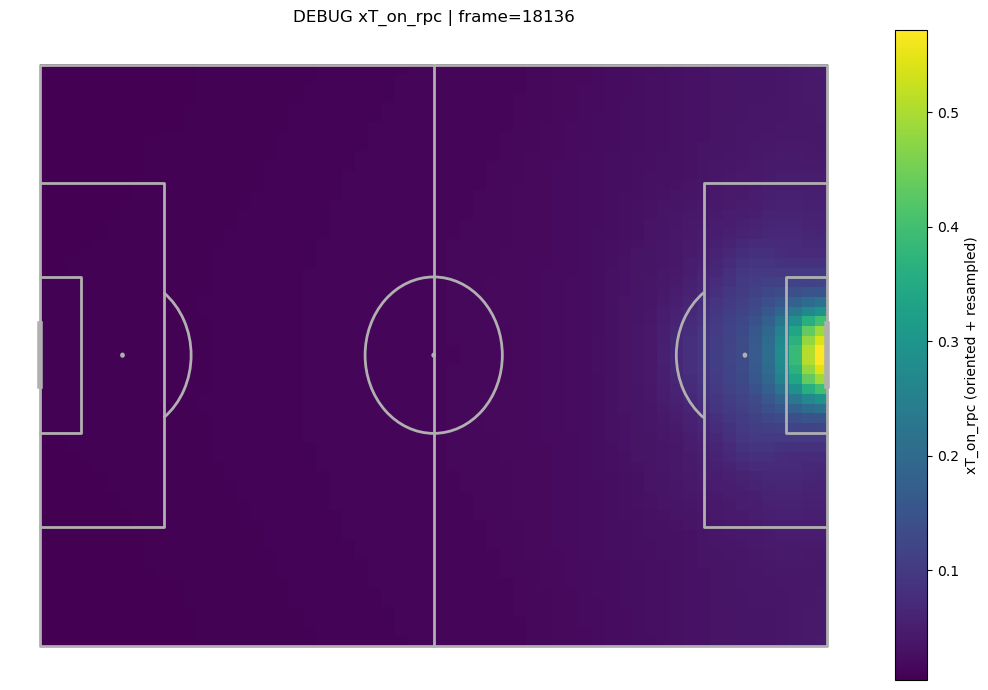

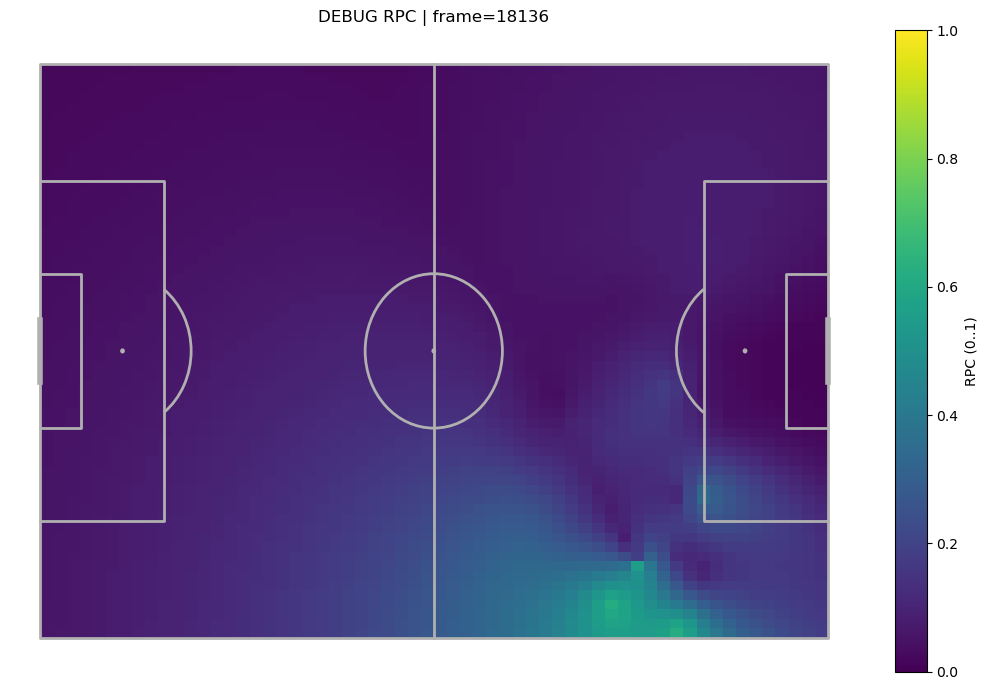

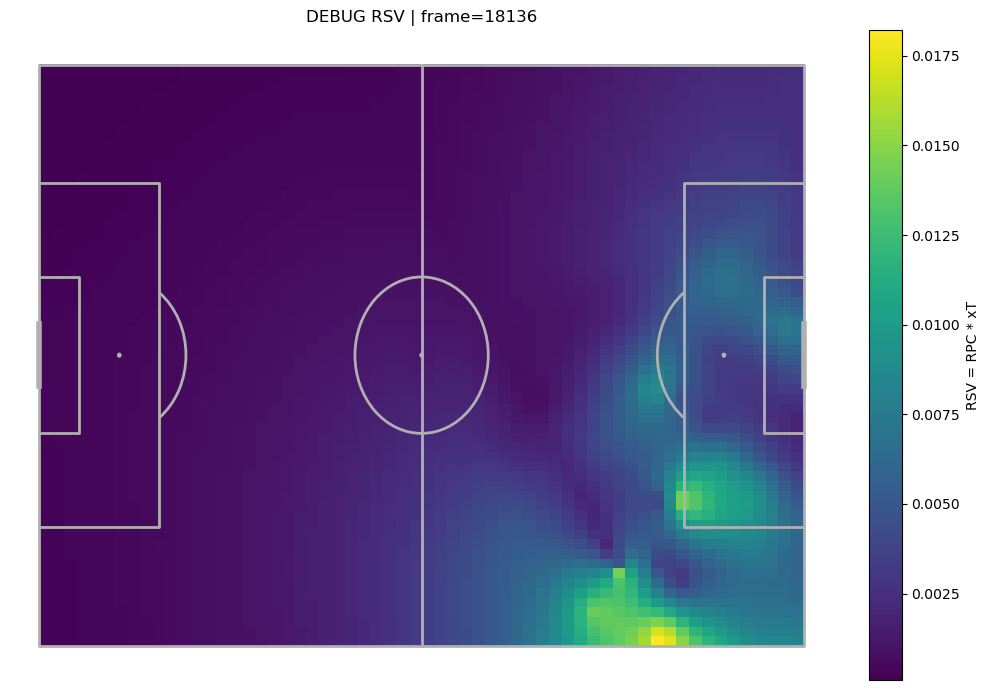

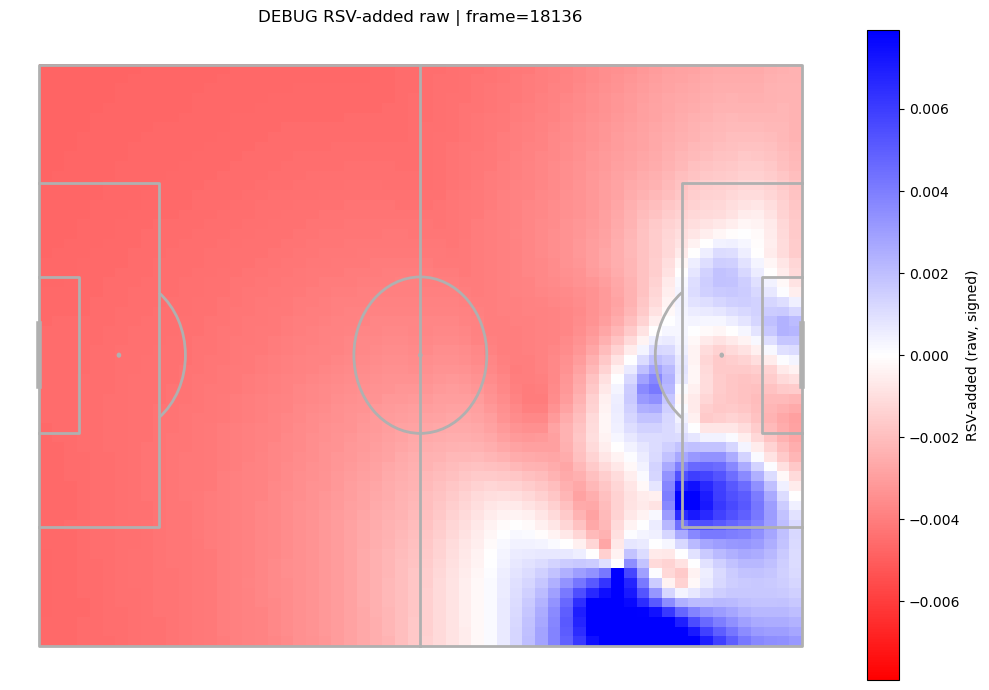

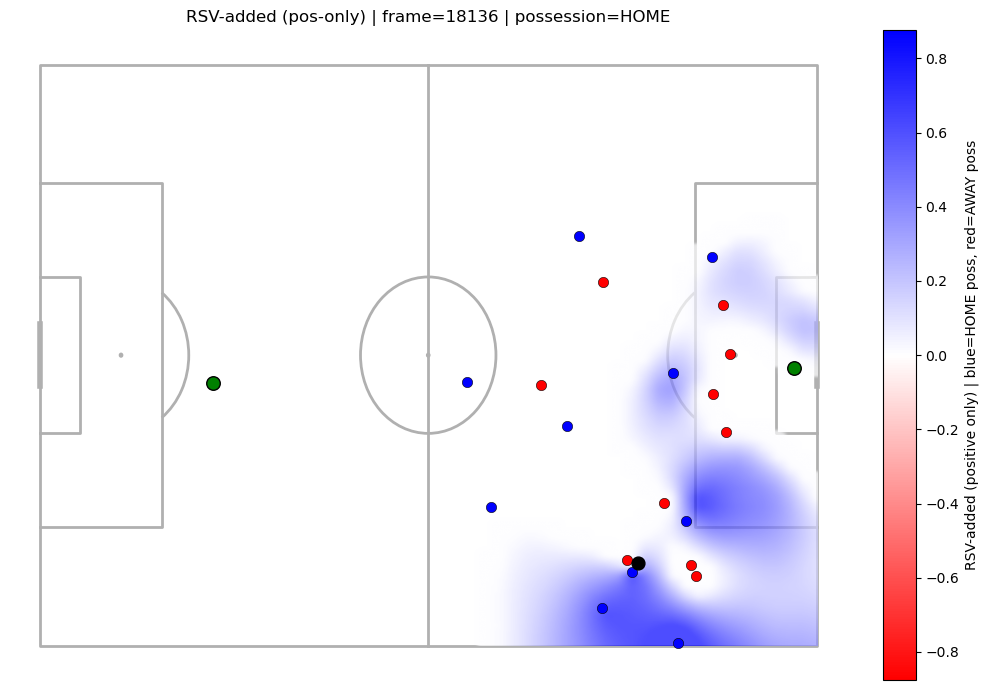

In [53]:
dbg = debug_rsv_frame_updated(
    frame_id=int(row["pass_moment_frame"]),
    enriched_tracking_norm=enriched_tracking_norm,
    de_norm=de_norm,
    match_meta_df=match_meta_df,
    xT_grid_ltr=xT_grid_ltr,
    pc_grid_n=60,
    pc_params=PitchControlParams(),
    rpc_params=RPCParams(ball_speed_mps=15.0, tau_seconds=2.3, use_facing=True),
    rsv_params=RSVParams(use_log=True, upsample=4, apply_gaussian_blur=True),
    team_colors=TEAM_COLORS,
    gk_color="green",
    prev_team_in_possession_id=HOME_TEAM_ID,
    show_plots=True,
    show_pos_only_plot=True,
)


In [59]:
# Next: Identify best RSV-passes and potential better value passes(options that are better then the pass made)

def _ensure_required_cols(df: pd.DataFrame, required: List[str], *, df_name: str) -> None:
    """Raise a helpful error if required columns are missing."""
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"{df_name} is missing required columns: {missing}")

def extract_player_possession_passes(de_norm: pd.DataFrame) -> pd.DataFrame:
    """
    Extract pass attempts from normalized Dynamic Events.

    We identify passes as:
      - event_type == 'player_possession'
      - end_type  == 'pass'
    """
    req = ["event_type", "end_type"]
    _ensure_required_cols(de_norm, req, df_name="de_norm")

    passes = de_norm.loc[
        (de_norm["event_type"].astype(str) == "player_possession")
        & (de_norm["end_type"].astype(str) == "pass")
    ].copy()

    # Deterministic ordering when possible
    sort_cols = [c for c in ["period", "index", "frame_end"] if c in passes.columns]
    if sort_cols:
        passes = passes.sort_values(sort_cols, kind="mergesort")

    return passes


# This function adds pass_moment_frame for all passes
def add_pass_moment_frame_column(de_norm: pd.DataFrame) -> pd.DataFrame:
    """
    Add pass_moment_frame to de_norm for ALL player_possession passes.

    Rule:
      pass_moment_frame = peak_passing_option_frame (if targeted_passing_option_event_id links)
                       else frame_end
    """
    df = de_norm.copy()

    # Minimal requirements
    req = ["event_type", "end_type", "frame_end"]
    _ensure_required_cols(df, req, df_name="de_norm")

    # If no passing_option rows exist, we can only fallback to frame_end
    has_po = ("event_type" in df.columns) and (df["event_type"].astype(str) == "passing_option").any()
    if not has_po:
        df["pass_moment_frame"] = np.where(
            (df["event_type"].astype(str) == "player_possession") & (df["end_type"].astype(str) == "pass"),
            df["frame_end"],
            np.nan,
        )
        return df

    # We need these to link pass -> passing_option
    # If missing, fallback to frame_end
    if "targeted_passing_option_event_id" not in df.columns or "event_id" not in df.columns:
        df["pass_moment_frame"] = np.where(
            (df["event_type"].astype(str) == "player_possession") & (df["end_type"].astype(str) == "pass"),
            df["frame_end"],
            np.nan,
        )
        return df

    # Build mapping: passing_option event_id -> peak_passing_option_frame (if exists)
    po = df.loc[df["event_type"].astype(str) == "passing_option", ["event_id"]].copy()
    if "peak_passing_option_frame" in df.columns:
        po["peak_passing_option_frame"] = df.loc[
            df["event_type"].astype(str) == "passing_option", "peak_passing_option_frame"
        ].values
    else:
        po["peak_passing_option_frame"] = np.nan

    po_map = po.set_index("event_id")["peak_passing_option_frame"]

    # Apply to player_possession passes
    is_pass = (df["event_type"].astype(str) == "player_possession") & (df["end_type"].astype(str) == "pass")
    fallback = df.loc[is_pass, "frame_end"].astype("float64")

    linked_peak = df.loc[is_pass, "targeted_passing_option_event_id"].map(po_map)

    # pass_moment_frame = linked_peak if available else frame_end
    df.loc[is_pass, "pass_moment_frame"] = np.where(
        pd.notna(linked_peak),
        linked_peak.astype("float64"),
        fallback,
    )

    # Optional: cast to Int64 (nullable int)
    df.loc[is_pass, "pass_moment_frame"] = df.loc[is_pass, "pass_moment_frame"].round().astype("Int64")

    return df
de_norm = add_pass_moment_frame_column(de_norm)

# sanity
passes = extract_player_possession_passes(de_norm)
print("pass_moment_frame in passes:", "pass_moment_frame" in passes.columns)
print("NaN share:", passes["pass_moment_frame"].isna().mean())


pass_moment_frame in passes: True
NaN share: 0.0


In [60]:
passes

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,pass_moment_frame
0,8_0,0,1899585,12,12,NaN,00:00.2,00:00.2,0,0,...,NaN,NaN,NaN,NaN,True,True,NaN,True,False,12.0
1,8_1,1,1899585,31,44,NaN,00:02.1,00:03.4,0,2,...,NaN,NaN,NaN,NaN,True,True,True,True,False,44.0
9,8_2,9,1899585,62,62,NaN,00:05.2,00:05.2,0,5,...,NaN,NaN,NaN,NaN,True,True,True,True,False,62.0
12,8_3,12,1899585,73,106,NaN,00:06.3,00:09.6,0,6,...,NaN,NaN,NaN,NaN,True,True,True,True,False,106.0
22,8_4,22,1899585,120,125,NaN,00:11.0,00:11.5,0,11,...,NaN,NaN,NaN,NaN,True,True,True,True,False,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,8_923,4678,1899585,59250,59282,NaN,94:08.0,94:11.2,94,8,...,NaN,NaN,NaN,NaN,True,True,True,NaN,False,59282.0
4686,8_924,4686,1899585,59756,59756,NaN,94:58.6,94:58.6,94,58,...,NaN,NaN,NaN,NaN,False,False,NaN,True,False,59756.0
4691,8_925,4691,1899585,59776,59776,NaN,95:00.6,95:00.6,95,0,...,NaN,NaN,NaN,NaN,True,True,False,True,False,59776.0
4695,8_926,4695,1899585,59793,59798,NaN,95:02.3,95:02.8,95,2,...,NaN,NaN,NaN,NaN,True,True,True,True,False,59798.0


In [61]:
# create two dataframes. 1:Find frames with top RSV-value passes 2:Find frames with top-RSV potential passes
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, Optional, Tuple, List

import numpy as np
import pandas as pd

# Assumes these exist in your environment (from earlier modules):
# - infer_possession_team_stable
# - compute_pitch_control_grid
# - to_possession_control_grid
# - compute_rpc_grid
# - xt_grid_oriented_to_possession_attack
# - resample_xt_to_rpc_grid
# - compute_rsv_grid
# - compute_rsv_added_from_ball
# - get_grid_value_at_xy


@dataclass(frozen=True)
class TopRSVPassesConfig:
    """Configuration for extracting and scoring top passes by RSV-added."""
    # Pass filtering
    only_successful: bool = False
    drop_missing_target_xy: bool = True

    # Frame selection
    pass_frame_col: str = "pass_moment_frame"

    # Compute controls
    pc_grid_n: int = 60
    pc_params: Any = None          # PitchControlParams()
    rpc_params: Any = None         # RPCParams(...)

    # Safety / performance
    max_passes: Optional[int] = None
    verbose: bool = True


def build_top_rsv_passes_df(
    *,
    de_norm: pd.DataFrame,
    enriched_tracking_norm: pd.DataFrame,
    match_meta_df: pd.DataFrame,
    xT_grid_ltr: np.ndarray,
    cfg: TopRSVPassesConfig,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute RSV-added for every pass in the match and return:
      - Top_RSV_passes_df (ranked by rsv_added_target_pos)
      - Potential_RSV_df (ranked by potential_RSV descending)

    Definitions
    ----------
    rsv_added_target:
        RSV-added at the pass target location.
    rsv_target:
        Absolute RSV value at target location (= rsv_ball + rsv_added_target).
    rsv_added_peak:
        Max RSV-added anywhere on the pitch in the same frame.
    potential_RSV:
        (rsv_added_peak - rsv_added_target) = "missed potential" vs the chosen target.

    Notes on interpretation
    -----------------------
    - Top_RSV_passes_df: high value means the chosen pass target location increased value vs ball location.
    - Potential_RSV_df: high value means there existed *another* location that was much better than the chosen target.
      This is closer to "state potential" / "decision quality" than pure "pass execution quality".
    """
    # ---- Validate match meta ----
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    for c in ("home_team.id", "away_team.id"):
        if c not in match_meta_df.columns:
            raise KeyError(f"match_meta_df missing required column: {c}")

    home_team_id = int(match_meta_df.iloc[0]["home_team.id"])
    away_team_id = int(match_meta_df.iloc[0]["away_team.id"])

    # ---- Validate cfg ----
    if cfg.pc_params is None:
        raise ValueError("cfg.pc_params must be provided (PitchControlParams).")
    if cfg.rpc_params is None:
        raise ValueError("cfg.rpc_params must be provided (RPCParams).")

    # ---- Extract passes from de_norm ----
    passes = extract_player_possession_passes(de_norm)

    # Must have pass_moment_frame
    if cfg.pass_frame_col not in passes.columns:
        raise KeyError(
            f"Passes missing '{cfg.pass_frame_col}'. "
            "Ensure you created pass_moment_frame for all player_possession(pass) rows."
        )

    # Optional: successful only
    if cfg.only_successful:
        if "pass_outcome" not in passes.columns:
            raise KeyError("cfg.only_successful=True requires 'pass_outcome' in de_norm.")
        passes = passes.loc[passes["pass_outcome"].astype(str) == "successful"].copy()

    # Target coordinates at pass moment
    if cfg.drop_missing_target_xy:
        for c in ("player_targeted_x_pass", "player_targeted_y_pass"):
            if c not in passes.columns:
                raise KeyError(f"drop_missing_target_xy=True requires '{c}' in de_norm.")
        passes = passes.dropna(subset=["player_targeted_x_pass", "player_targeted_y_pass"]).copy()

    # Cap for testing
    if cfg.max_passes is not None:
        passes = passes.head(int(cfg.max_passes)).copy()

    if cfg.verbose:
        print(f"[INFO] Passes to score: {len(passes)}")

    # ---- Memoize per-frame computations (big speed win) ----
    frame_cache: Dict[int, Dict[str, Any]] = {}
    prev_team_in_poss = int(home_team_id)
    out_rows: List[Dict[str, Any]] = []

    # Columns we copy if present
    optional_cols = [
        "match_id", "period", "time_start", "time_end", "minute_start", "second_start",
        "frame_start", "frame_end",
        "player_id",  # sometimes used instead of player_in_possession_id
        "player_in_possession_id", "player_in_possession_name",
        "player_targeted_id", "player_targeted_name",
        "pass_outcome", "pass_distance", "pass_angle", "pass_direction",
        "team_id", "team_shortname",
        "team_in_possession_phase_type", "team_out_of_possession_phase_type",
        "organised_defense", "furthest_line_break", "furthest_line_break_type",
        "high_pass",
        "event_id", "index",
        "targeted_passing_option_event_id", "peak_passing_option_frame",
        "passing_option_score", "player_targeted_xthreat", "xpass_completion",
    ]
    for j, (_, row) in enumerate(passes.iterrows(), start=1):
        if cfg.verbose and (j == 1 or j % 25 == 0):
            print(f"[INFO] pass {j}/{len(passes)} | cached_frames={len(frame_cache)}")
        pass_frame = int(row[cfg.pass_frame_col])

        # ---- Compute / reuse per-frame RSV-added grid ----
        if pass_frame not in frame_cache:
            try:
                # Stable possession
                team_in_possession_id, player_in_possession_id = infer_possession_team_stable(
                    de_norm,
                    enriched_tracking_norm,
                    frame_id=pass_frame,
                    prev_team_in_possession_id=int(prev_team_in_poss),
                    home_team_id=home_team_id,
                    away_team_id=away_team_id,
                )

                # PC home
                pc_home_grid, x_grid, y_grid, _pc_meta = compute_pitch_control_grid(
                    enriched_tracking_norm,
                    frame_id=pass_frame,
                    home_team_id=home_team_id,
                    away_team_id=away_team_id,
                    grid_n=int(cfg.pc_grid_n),
                    params=cfg.pc_params,
                    ensure_velocity=True,
                )

                # PC possession
                pc_poss = to_possession_control_grid(
                    pc_home_grid,
                    team_in_possession_id=int(team_in_possession_id),
                    home_team_id=int(home_team_id),
                )

                # Only pass player_id if facing is enabled
                player_for_rpc = None
                if bool(getattr(cfg.rpc_params, "use_facing", False)):
                    player_for_rpc = int(player_in_possession_id) if player_in_possession_id is not None else None

                # RPC
                rpc_grid = compute_rpc_grid(
                    pc_poss=pc_poss,
                    x_grid=x_grid,
                    y_grid=y_grid,
                    enriched_tracking_norm=enriched_tracking_norm,
                    frame_id=pass_frame,
                    params=cfg.rpc_params,
                    player_in_possession_id=player_for_rpc,
                )

                # xT oriented + resampled
                xT_plot = xt_grid_oriented_to_possession_attack(
                    xT_grid_ltr,
                    possession_team_id=int(team_in_possession_id),
                    home_team_id=int(home_team_id),
                )
                xT_on_rpc = resample_xt_to_rpc_grid(
                    xT_plot,
                    rpc_x_grid=x_grid,
                    rpc_y_grid=y_grid,
                )

                # RSV + RSV-added relative to ball
                rsv_grid = compute_rsv_grid(rpc_grid=rpc_grid, xT_on_rpc_grid=xT_on_rpc)

                frame_df = enriched_tracking_norm.loc[enriched_tracking_norm["frame"] == pass_frame]
                if frame_df.empty:
                    raise ValueError(f"No tracking rows found for frame_id={pass_frame}")

                ball_x = float(frame_df["ball_x"].iloc[0])
                ball_y = float(frame_df["ball_y"].iloc[0])

                rsv_added_grid, rsv_ball = compute_rsv_added_from_ball(
                    rsv_grid=rsv_grid,
                    x_grid=x_grid,
                    y_grid=y_grid,
                    ball_x=ball_x,
                    ball_y=ball_y,
                )

                # Peak (best theoretical improvement anywhere on grid)
                rsv_added_peak = float(np.nanmax(np.asarray(rsv_added_grid, dtype=np.float64)))

                frame_cache[pass_frame] = {
                    "team_in_possession_id": int(team_in_possession_id),
                    "rsv_added_grid": rsv_added_grid,
                    "x_grid": x_grid,
                    "y_grid": y_grid,
                    "rsv_ball": float(rsv_ball),
                    "ball_x": float(ball_x),
                    "ball_y": float(ball_y),
                    "rsv_added_peak": float(rsv_added_peak),
                }

                # Advance stable seed
                prev_team_in_poss = int(team_in_possession_id)

            except Exception as e:
                if cfg.verbose:
                    print(f"[WARN] Failed scoring pass at frame {pass_frame}: {e}")
                continue

        cached = frame_cache[pass_frame]

        # ---- Target position at pass moment ----
        tx = row.get("player_targeted_x_pass", np.nan)
        ty = row.get("player_targeted_y_pass", np.nan)
        if pd.isna(tx) or pd.isna(ty):
            continue

        rsv_added_target = get_grid_value_at_xy(
            float(tx),
            float(ty),
            grid=np.asarray(cached["rsv_added_grid"], dtype=np.float64),
            x_grid=np.asarray(cached["x_grid"], dtype=np.float64),
            y_grid=np.asarray(cached["y_grid"], dtype=np.float64),
        )

        rsv_added_target_pos = float(max(rsv_added_target, 0.0))

        # ---- Extra scores ----
        rsv_target = float(cached["rsv_ball"] + float(rsv_added_target))
        rsv_added_peak = float(cached["rsv_added_peak"])

        # Opportunity cost: how much better the best grid-cell was vs chosen target
        potential_RSV = float(rsv_added_peak - float(rsv_added_target))

        out: Dict[str, Any] = {
            "pass_moment_frame": int(pass_frame),
            "rsv_added_target": float(rsv_added_target),
            "rsv_added_target_pos": float(rsv_added_target_pos),
            "rsv_ball": float(cached["rsv_ball"]),
            "rsv_target": float(rsv_target),
            "rsv_added_peak": float(rsv_added_peak),
            "potential_RSV": float(potential_RSV),
            "ball_x": float(cached["ball_x"]),
            "ball_y": float(cached["ball_y"]),
            "target_x_pass": float(tx),
            "target_y_pass": float(ty),
            "team_in_possession_id_model": int(cached["team_in_possession_id"]),
        }

        for c in optional_cols:
            if c in passes.columns:
                out[c] = row.get(c, None)

        out_rows.append(out)

    scored_df = pd.DataFrame(out_rows)
    if scored_df.empty:
        return scored_df, scored_df.copy()

    # 1) "Best passes" by RSV-added at chosen target (positive-only ranking)
    Top_RSV_passes_df = scored_df.sort_values(
        ["rsv_added_target_pos", "rsv_added_target"],
        ascending=False
    ).reset_index(drop=True)

    # 2) "Most missed potential" by potential_RSV
    Potential_RSV_df = scored_df.copy().sort_values(
        ["potential_RSV", "rsv_added_peak"],
        ascending=False
    ).reset_index(drop=True)

    return Top_RSV_passes_df, Potential_RSV_df
    
#Code below take a lot of time to run. Should test with smaller amount of passes
# =============================================================================
# Example usage
# =============================================================================
# working directory
WORKING_DIR: Path = Path.cwd()
'''
cfg = TopRSVPassesConfig(
    only_successful=False,
    pc_grid_n=40,
    pc_params=PitchControlParams(),
    rpc_params=RPCParams(ball_speed_mps=15.0, tau_seconds=2.3, use_facing=False),
    verbose=True,
)

Top_RSV_passes_df, Potential_RSV_df = build_top_rsv_passes_df(
    de_norm=de_norm,  # <-- only use de_norm
    enriched_tracking_norm=enriched_tracking_norm,
    match_meta_df=match_meta_df,
    xT_grid_ltr=xT_grid_ltr,
    cfg=cfg,
)

display(Top_RSV_passes_df.head(20))
display(Potential_RSV_df.head(20))'''

[INFO] Passes to score: 802
[INFO] pass 1/802 | cached_frames=0
[INFO] pass 25/802 | cached_frames=24
[INFO] pass 50/802 | cached_frames=49
[INFO] pass 75/802 | cached_frames=74
[INFO] pass 100/802 | cached_frames=99
[INFO] pass 125/802 | cached_frames=124
[INFO] pass 150/802 | cached_frames=149
[INFO] pass 175/802 | cached_frames=174
[INFO] pass 200/802 | cached_frames=199
[INFO] pass 225/802 | cached_frames=224
[INFO] pass 250/802 | cached_frames=249
[INFO] pass 275/802 | cached_frames=274
[INFO] pass 300/802 | cached_frames=299
[INFO] pass 325/802 | cached_frames=324
[INFO] pass 350/802 | cached_frames=349
[INFO] pass 375/802 | cached_frames=374
[INFO] pass 400/802 | cached_frames=399
[INFO] pass 425/802 | cached_frames=424
[INFO] pass 450/802 | cached_frames=449
[INFO] pass 475/802 | cached_frames=474
[INFO] pass 500/802 | cached_frames=499
[INFO] pass 525/802 | cached_frames=524
[INFO] pass 550/802 | cached_frames=549
[INFO] pass 575/802 | cached_frames=574
[INFO] pass 600/802 | c

,pass_moment_frame,rsv_added_target,rsv_added_target_pos,rsv_ball,rsv_target,rsv_added_peak,potential_RSV,ball_x,ball_y,target_x_pass,...,furthest_line_break,furthest_line_break_type,high_pass,event_id,index,targeted_passing_option_event_id,peak_passing_option_frame,passing_option_score,player_targeted_xthreat,xpass_completion
0,27709,0.017605,0.017605,0.010712,0.028317,0.017605,0.000000,30.180000,14.430000,33.13,...,NaN,NaN,False,8_462,2338,7_1184,NaN,NaN,0.0337,NaN
1,40098,0.015472,0.015472,0.026058,0.041530,0.039857,0.024384,49.030000,-31.050000,46.00,...,NaN,NaN,True,8_614,3157,7_1583,NaN,NaN,0.0563,NaN
2,54526,0.014269,0.014269,0.013991,0.028260,0.029064,0.014795,49.860000,15.950000,39.10,...,NaN,NaN,NaN,8_847,4260,7_2151,NaN,NaN,0.0967,NaN
3,35185,0.014036,0.014036,0.021067,0.035103,0.036166,0.022129,26.370000,-13.160000,43.20,...,NaN,NaN,True,8_551,2828,7_1430,NaN,NaN,0.0304,NaN
4,18164,0.013102,0.013102,0.029190,0.042292,0.056208,0.043106,48.420000,-11.000000,44.19,...,NaN,NaN,NaN,8_302,1462,7_743,NaN,NaN,0.4653,NaN
5,8688,0.011946,0.011946,0.015670,0.027616,0.039037,0.027091,34.090000,-20.520000,40.52,...,NaN,NaN,NaN,8_182,857,7_438,NaN,NaN,0.0605,NaN
6,54356,0.011415,0.011415,0.016609,0.028024,0.018839,0.007425,42.600000,25.230000,40.92,...,NaN,NaN,True,8_837,4220,7_2138,NaN,NaN,0.0552,NaN
7,27290,0.009805,0.009805,0.017244,0.027050,0.013946,0.004141,38.090000,29.410000,38.66,...,NaN,NaN,True,8_457,2313,7_1177,NaN,NaN,0.0527,NaN
8,51535,0.009587,0.009587,0.005909,0.015496,0.016613,0.007025,32.640000,-25.490000,27.36,...,NaN,NaN,NaN,8_789,3996,7_2032,NaN,NaN,0.0053,NaN
9,26457,0.009551,0.009551,0.013405,0.022957,0.019836,0.010285,38.050361,27.053614,39.81,...,NaN,NaN,True,8_436,2182,7_1111,NaN,NaN,0.0194,NaN


,pass_moment_frame,rsv_added_target,rsv_added_target_pos,rsv_ball,rsv_target,rsv_added_peak,potential_RSV,ball_x,ball_y,target_x_pass,...,furthest_line_break,furthest_line_break_type,high_pass,event_id,index,targeted_passing_option_event_id,peak_passing_option_frame,passing_option_score,player_targeted_xthreat,xpass_completion
0,26196,-0.015698,0.000000,0.048053,0.032356,0.121416,0.137114,43.680000,9.940000,33.29,...,NaN,NaN,False,8_433,2169,7_1104,NaN,NaN,0.0219,NaN
1,3837,-0.026412,0.000000,0.026877,0.000465,0.060376,0.086788,-49.230000,17.590000,43.67,...,NaN,NaN,NaN,8_74,351,7_172,NaN,NaN,0.0389,NaN
2,25003,-0.028069,0.000000,0.028584,0.000515,0.051412,0.079482,-46.310000,16.620000,37.93,...,NaN,NaN,False,8_427,2143,7_1099,NaN,NaN,0.0460,NaN
3,18940,-0.002035,0.000000,0.011014,0.008980,0.072685,0.074719,13.745946,-2.649459,-1.86,...,NaN,NaN,NaN,8_303,1467,NaN,NaN,NaN,NaN,NaN
4,24246,-0.013874,0.000000,0.014656,0.000782,0.058118,0.071992,-37.480000,-29.080000,23.76,...,NaN,NaN,False,8_416,2070,7_1060,NaN,NaN,0.0066,NaN
5,26222,0.003447,0.003447,0.016128,0.019576,0.072157,0.068710,31.520000,3.650000,24.99,...,NaN,NaN,NaN,8_434,2173,7_1105,NaN,NaN,0.0156,NaN
6,24283,-0.007648,0.000000,0.008553,0.000905,0.058610,0.066258,-30.840000,-23.040000,40.64,...,NaN,NaN,NaN,8_417,2076,7_1066,NaN,NaN,0.0402,NaN
7,57781,-0.022261,0.000000,0.022910,0.000649,0.043793,0.066054,-43.660000,-20.430000,42.72,...,NaN,NaN,True,8_903,4568,7_2324,NaN,NaN,0.0551,NaN
8,46526,-0.027117,0.000000,0.029901,0.002784,0.038820,0.065937,-27.205806,8.026774,18.62,...,NaN,NaN,False,8_728,3710,7_1871,NaN,NaN,0.0083,NaN
9,57799,-0.034653,0.000000,0.035329,0.000675,0.029892,0.064546,-40.100000,-0.340000,43.25,...,NaN,NaN,NaN,8_904,4575,7_2325,NaN,NaN,0.1170,NaN


In [62]:
Top_RSV_passes_df.columns

Index(['pass_moment_frame', 'rsv_added_target', 'rsv_added_target_pos',
       'rsv_ball', 'rsv_target', 'rsv_added_peak', 'potential_RSV', 'ball_x',
       'ball_y', 'target_x_pass', 'target_y_pass',
       'team_in_possession_id_model', 'match_id', 'period', 'time_start',
       'time_end', 'minute_start', 'second_start', 'frame_start', 'frame_end',
       'player_id', 'player_in_possession_id', 'player_in_possession_name',
       'player_targeted_id', 'player_targeted_name', 'pass_outcome',
       'pass_distance', 'pass_angle', 'pass_direction', 'team_id',
       'team_shortname', 'team_in_possession_phase_type',
       'team_out_of_possession_phase_type', 'organised_defense',
       'furthest_line_break', 'furthest_line_break_type', 'high_pass',
       'event_id', 'index', 'targeted_passing_option_event_id',
       'peak_passing_option_frame', 'passing_option_score',
       'player_targeted_xthreat', 'xpass_completion'],
      dtype='object')

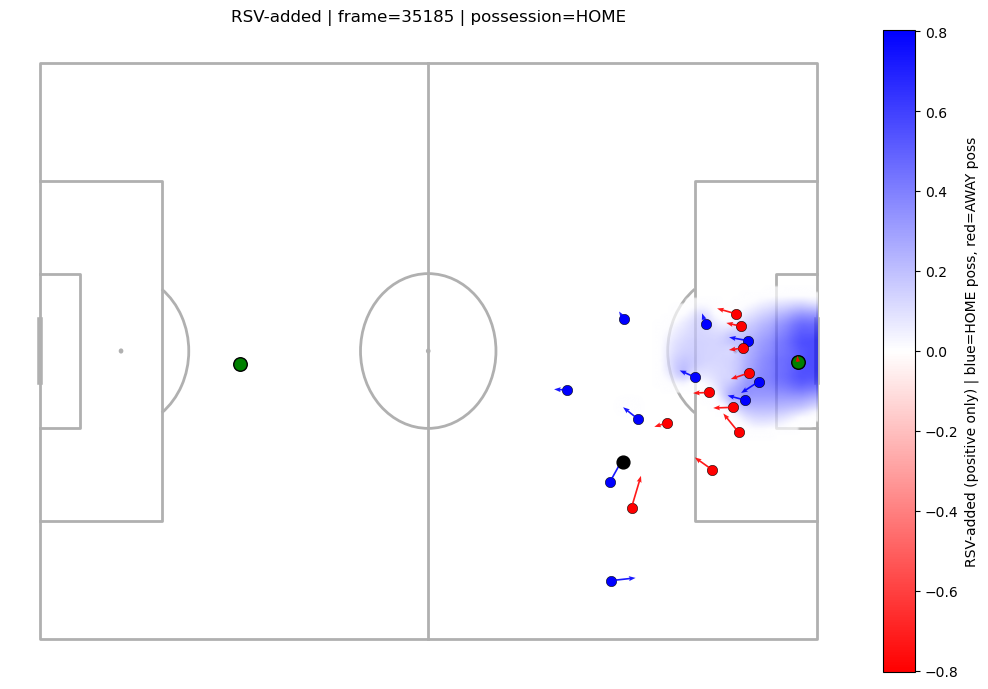

In [68]:
# =============================================================================
# RSV plot
# =============================================================================
rsv_out = run_rsv_frame(
    frame_id=27709, #set in frame_id from pass_moment frame
    enriched_tracking_norm=enriched_tracking_norm,
    de_norm=de_norm,
    match_meta_df=match_meta_df,
    xT_grid_ltr=xT_grid_ltr,
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    prev_team_in_possession_id=HOME_TEAM_ID,  
    pc_grid_n=100,
    pc_params=PitchControlParams(),  
    rpc_params=RPCParams(
        ball_speed_mps=15.0,
        tau_seconds=2.3,   
        use_facing=True,
    ),
    rsv_params=RSVParams(use_log=True, upsample=4, apply_gaussian_blur=True),
    PLOT=True,
    show_movement=True,
    show_pass=False,
    pass_start=(float(row["pass_x_start"]), float(row["pass_y_start"])),
    pass_end=(float(row["pass_x_end"]), float(row["pass_y_end"])),
    pass_color="black",
    pass_lw=1.2,
    pass_headwidth=1.0,
    pass_headlength=1.0,
    pass_alpha=0.95,
    SAVE=False,
    WORKING_DIR=PROJECT_ROOT,
    save_prefix=f"match__rsv_top_pass{MATCH_ID}" if "MATCH_ID" in globals() else "plot",
    dpi=200,
    SHOW=True,
    fixed_vlim=None,
)
